In [1]:
# ============================
# Cell 1 — Imports + Custom Env (Continuous CartPole Swing-Up) + EDGE RESPAWN
# + TensorFlow GPU setup (for GPflow/TF compute)
# ============================

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.*", category=UserWarning)

import os
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit
from gymnasium.utils import seeding

# ---- numpy bool8 compat ----
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

# ============================================================
# TensorFlow GPU setup (THIS is what makes TF/GPflow use GPU)
# ============================================================
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # quieter TF logs (optional)

import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    # Prevent TF from grabbing all VRAM at startup
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ TF version:", tf.__version__)
    print("✅ Built with CUDA:", tf.test.is_built_with_cuda())
    print("✅ GPUs:", gpus)
else:
    print("⚠️ TF version:", tf.__version__)
    print("⚠️ Built with CUDA:", tf.test.is_built_with_cuda())
    print("⚠️ GPUs: [] (TensorFlow will run on CPU)")

# ============================================================
# Dtypes for GPU-friendly pipeline
# ============================================================
# Env can stay float32; GP features should also be float32 to avoid slow casts.
DTYPE_NP = np.float32

# ============================================================
# Angle helpers
# ============================================================
def wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def obs_to_state(obs):
    """
    obs = [x, x_dot, theta, theta_dot]
    Wrap theta to (-pi, pi] for stability.
    """
    x, xdot, th, thdot = float(obs[0]), float(obs[1]), float(obs[2]), float(obs[3])
    th = wrap_pi(th)
    return x, xdot, th, thdot
U_MIN, U_MAX = -1.0, 1.0

def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0,
                      dtype=DTYPE_NP):
    """
    GP features (D=6), bounded:
        [ tanh(x/x_scale),
          tanh(xdot/v_scale),
          sin(theta),
          cos(theta),
          tanh(thetadot/w_scale),
          u ]
    Returns float32 by default (GPU-friendly).
    """
    x_feat = np.tanh(x / x_scale)
    xdot_feat = np.tanh(xdot / v_scale)
    w_feat = np.tanh(thetadot / w_scale)
    return np.array(
        [x_feat, xdot_feat, np.sin(theta), np.cos(theta), w_feat, float(u)],
        dtype=dtype
    )

# ============================================================
# Custom Continuous CartPole Swing-Up Env (CPU physics; that's OK)
# ============================================================
class ContinuousCartPoleSwingUpEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array", "human"], "render_fps": 50}

    def __init__(self, render_mode=None, start_down=True):
        super().__init__()

        # physics
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length

        # control
        self.force_mag = 30.0
        self.tau = 0.02
        self.min_action = -1.0
        self.max_action = 1.0

        # track limits
        self.x_threshold = 2.4

        # reset mode
        self.start_down = bool(start_down)

        # render
        self.render_mode = render_mode
        self.state = None
        self.np_random = None
        self.seed()

        # spaces
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=np.array([self.min_action], dtype=np.float32),
            high=np.array([self.max_action], dtype=np.float32),
            shape=(1,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta * costheta / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        action = np.asarray(action, dtype=np.float32).reshape(1,)
        assert self.action_space.contains(action), f"{action} invalid"

        u = float(action[0])
        force = self.force_mag * u

        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state

        terminated = bool(x < -self.x_threshold or x > self.x_threshold)
        truncated = False  # TimeLimit handles truncation

        reward = (
            +1.0 * math.cos(theta)
            -0.01 * (x * x)
            -0.001 * (x_dot * x_dot)
            -0.001 * (theta_dot * theta_dot)
            -0.001 * (u * u)
        )

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        info = dict(x=x, x_dot=x_dot, theta=theta, theta_dot=theta_dot, u=u)
        return obs, float(reward), terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        x = float(self.np_random.uniform(low=-0.05, high=0.05))
        x_dot = float(self.np_random.uniform(low=-0.05, high=0.05))
        theta_dot = float(self.np_random.uniform(low=-0.05, high=0.05))

        if self.start_down:
            theta = float(math.pi + self.np_random.uniform(low=-0.10, high=0.10))
        else:
            theta = float(self.np_random.uniform(low=-0.10, high=0.10))

        self.state = (x, x_dot, theta, theta_dot)
        obs = np.array(self.state, dtype=np.float32)
        info = {}
        return obs, info

    def render(self):
        return None

    def close(self):
        return None

# ============================================================
# Edge respawn wrapper
# ============================================================
class EdgeRespawnWrapper(gym.Wrapper):
    def __init__(self, env, respawn_penalty=-2.0, reset_seed_mode="random", seed=0):
        super().__init__(env)
        self.respawn_penalty = float(respawn_penalty)
        self.reset_seed_mode = str(reset_seed_mode)
        self._rng = np.random.default_rng(seed)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        return self.env.reset(seed=seed, options=options)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        if terminated:
            info = dict(info)
            info["respawned"] = True
            reward = float(reward) + self.respawn_penalty

            seed = int(self._rng.integers(0, 10**9)) if self.reset_seed_mode == "random" else None
            obs, _ = self.env.reset(seed=seed)

            terminated = False
            truncated = False

        return obs, float(reward), bool(terminated), bool(truncated), info

# ============================================================
# Environment factory
# ============================================================
MAX_EPISODE_STEPS = 600

def make_env(
    render_mode=None,
    seed=0,
    max_episode_steps=MAX_EPISODE_STEPS,
    start_down=True,
    edge_respawn=True,
    respawn_penalty=-2.0,
):
    env = ContinuousCartPoleSwingUpEnv(render_mode=render_mode, start_down=start_down)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if edge_respawn:
        env = EdgeRespawnWrapper(env, respawn_penalty=respawn_penalty, seed=seed)
    env.reset(seed=seed)
    return env

# ============================================================
# Sanity check
# ============================================================
env = make_env(render_mode=None, seed=0, start_down=True, edge_respawn=True)
obs, _ = env.reset(seed=0)
s = obs_to_state(obs)

print("✅ Env ready (edge_respawn=True)")
print("obs:", obs)
print("state:", s)
print("action space:", env.action_space)
env.close()


✅ TF version: 2.20.0
✅ Built with CUDA: True
✅ GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Env ready (edge_respawn=True)
obs: [ 0.01369617 -0.02302133  3.0448983  -0.04590265]
state: (0.013696168549358845, -0.023021329194307327, 3.044898271560669, -0.04590264707803726)
action space: Box(-1.0, 1.0, (1,), float32)


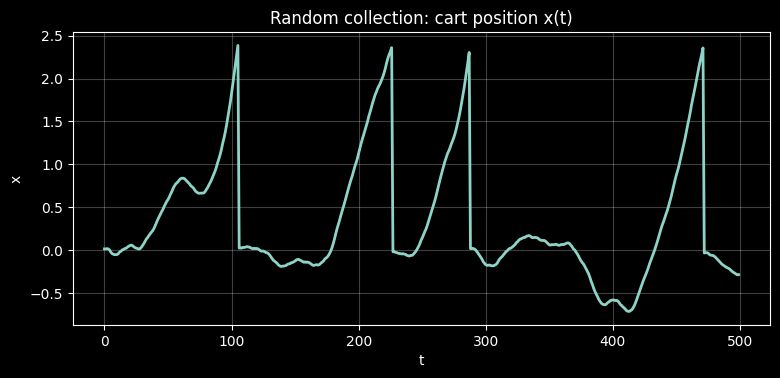

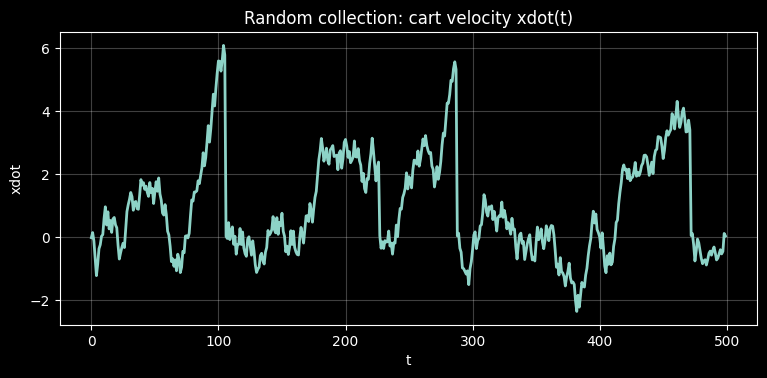

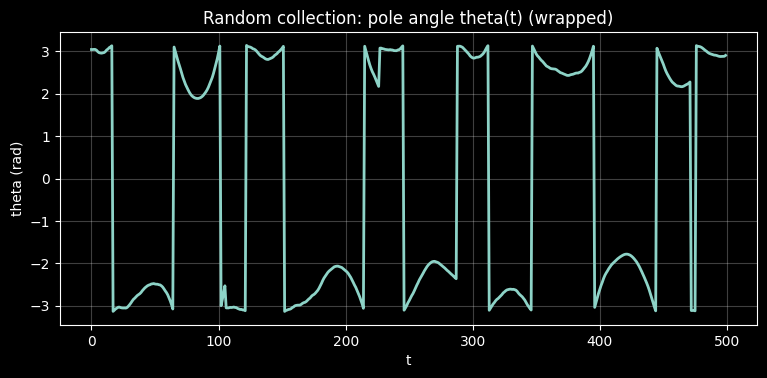

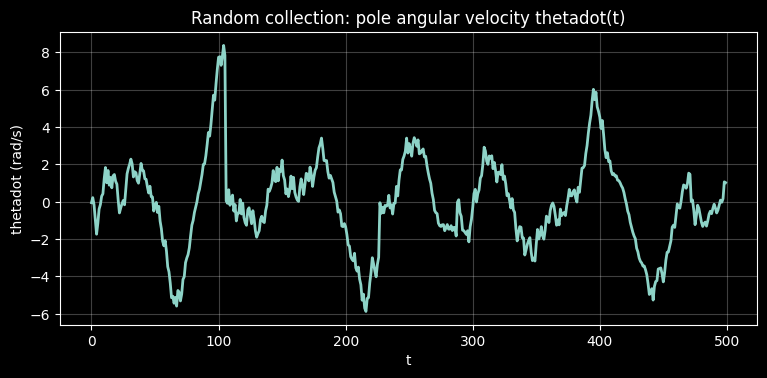

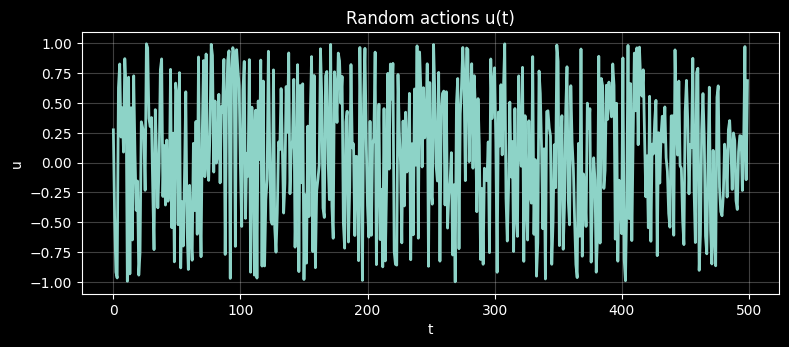

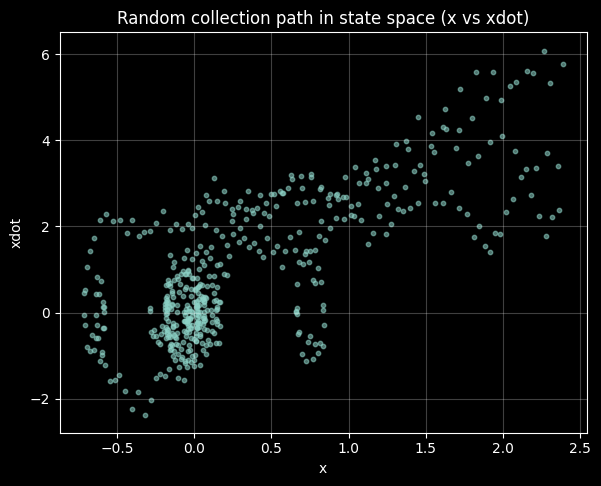

Collected X0 shape: (496, 6)  (6D features)
Targets shapes: (496, 1) (496, 1) (496, 1) (496, 1)
Kept=496  Dropped(respawn)=4  Resets=0


In [2]:

# ============================
# Cell 2 — Render the RANDOM collection path (and collect X,Y)  ✅ CartPole version
#
# Fix:
#   ✅ Adds render_cartpole_frame_from_state() (pure PIL) so the line:
#        frame = render_cartpole_frame_from_state(...)
#      actually works.
#
# What you get:
#   - Runs random actions for n_steps (with resets as needed)
#   - Collects executed transitions:
#       X0: (N,6)  = [x_feat, xdot_feat, sinθ, cosθ, w_feat, u]
#       Ydx0, Ydxdot0, Ydth0, Ydthdot0  (each (N,1))
#   - Records frames (rgb) and displays an inline animation (JS HTML)
#   - Plots trajectories:
#       x(t), xdot(t), theta(t), thetadot(t), action(t)
#       phase plot: x vs xdot
#
# IMPORTANT:
#   - We DO NOT rely on env.render() / pygame.
#   - We render from state using a self-contained PIL renderer below.
#   - If your env does edge respawn and sets info["respawned"]=True, we DROP that transition.
# ============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

from PIL import Image, ImageDraw

# ------------------------------------------------------------
# Pure-PIL renderer: (x, theta) -> RGB frame
# ------------------------------------------------------------
def render_cartpole_frame_from_state(
    x, theta,
    x_threshold=2.4,
    W=720, H=450,
    cart_width=70,
    cart_height=35,
    pole_length_px=160,
    pole_width=10,
):
    """
    Minimal CartPole render (rgb uint8) from state.
    Coordinates:
      - x in [-x_threshold, x_threshold] maps to screen track
      - theta: 0 = upright, pi = down (standard)
    """
    # background
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img)

    # track line
    y_track = int(0.72 * H)
    dr.line([(0, y_track), (W, y_track)], fill=(210, 210, 210), width=4)

    # map x -> screen px
    # keep margins so cart stays visible
    margin = 40
    x_clamped = float(np.clip(x, -x_threshold, x_threshold))
    x_norm = (x_clamped + x_threshold) / (2 * x_threshold)  # [0,1]
    cx = int(margin + x_norm * (W - 2 * margin))
    cy = y_track - cart_height // 2

    # cart rectangle
    x0 = cx - cart_width // 2
    y0 = cy - cart_height // 2
    x1 = cx + cart_width // 2
    y1 = cy + cart_height // 2
    dr.rounded_rectangle([x0, y0, x1, y1], radius=8, fill=(60, 90, 160), outline=(30, 30, 30), width=2)

    # axle point on top of cart
    ax = cx
    ay = y0 + 6

    # pole end point
    # IMPORTANT: theta=0 is upright -> pole points UP, so use -cos/sin appropriately
    # Standard cartpole uses theta from vertical; here we draw:
    #   dx =  L * sin(theta)
    #   dy = -L * cos(theta)
    dx = pole_length_px * float(np.sin(theta))
    dy = -pole_length_px * float(np.cos(theta))
    px = ax + dx
    py = ay + dy

    # pole (as thick line)
    dr.line([(ax, ay), (px, py)], fill=(180, 50, 50), width=pole_width)

    # axle circle
    r = 8
    dr.ellipse([ax - r, ay - r, ax + r, ay + r], fill=(30, 30, 30))

    return np.asarray(img, dtype=np.uint8)


# ------------------------------------------------------------
# Random collection (rendered)
# ------------------------------------------------------------
def collect_random_transitions_rendered_cartpole(
    n_steps=500,
    seed=0,
    max_episode_steps=500,
    start_down=True,
    # rendering controls
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    # edge-respawn handling (relies on your Cell 1 env.step() putting info["respawned"]=True)
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=True,
):
    rng = np.random.default_rng(seed)

    env_vis = make_env(
        render_mode=None,   # we render ourselves
        seed=seed,
        max_episode_steps=max_episode_steps,
        start_down=start_down,
        edge_respawn=edge_respawn,
        respawn_penalty=respawn_penalty,
    )

    obs, info = env_vis.reset(seed=seed)
    x, xdot, th, thdot = obs_to_state(obs)

    X_list, Ydx_list, Ydxdot_list, Ydth_list, Ydthdot_list = [], [], [], [], []

    traj_x, traj_xdot, traj_th, traj_thdot, traj_u = [], [], [], [], []
    frames = []
    dropped = 0
    resets = 0

    for t in range(n_steps):
        u = float(rng.uniform(U_MIN, U_MAX))

        obs2, reward, terminated, truncated, info = env_vis.step(np.array([u], dtype=np.float32))
        x2, xdot2, th2, thdot2 = obs_to_state(obs2)

        respawned = bool(isinstance(info, dict) and info.get("respawned", False))
        if respawned and drop_respawn_transitions:
            dropped += 1
        else:
            X_list.append(state_to_features(x, xdot, th, thdot, u))
            Ydx_list.append(x2 - x)
            Ydxdot_list.append(xdot2 - xdot)
            Ydth_list.append(wrap_pi(th2 - th))
            Ydthdot_list.append(thdot2 - thdot)

        traj_x.append(x)
        traj_xdot.append(xdot)
        traj_th.append(th)
        traj_thdot.append(thdot)
        traj_u.append(u)

        if (t % frame_stride) == 0:
            W, H = int(resize[0]), int(resize[1])
            frame = render_cartpole_frame_from_state(x2, th2, x_threshold=2.4, W=W, H=H)
            frames.append(frame)

        x, xdot, th, thdot = x2, xdot2, th2, thdot2

        if terminated or truncated:
            resets += 1
            obs, info = env_vis.reset(seed=int(seed + 123 + t))
            x, xdot, th, thdot = obs_to_state(obs)
            if verbose:
                print(f"[t={t:04d}] reset (terminated={terminated}, truncated={truncated})")

    env_vis.close()

    X0 = np.asarray(X_list, dtype=np.float64)
    Ydx0 = np.asarray(Ydx_list, dtype=np.float64).reshape(-1, 1)
    Ydxdot0 = np.asarray(Ydxdot_list, dtype=np.float64).reshape(-1, 1)
    Ydth0 = np.asarray(Ydth_list, dtype=np.float64).reshape(-1, 1)
    Ydthdot0 = np.asarray(Ydthdot_list, dtype=np.float64).reshape(-1, 1)

    traj = dict(
        x=np.asarray(traj_x, dtype=np.float64),
        xdot=np.asarray(traj_xdot, dtype=np.float64),
        theta=np.asarray(traj_th, dtype=np.float64),
        thetadot=np.asarray(traj_thdot, dtype=np.float64),
        u=np.asarray(traj_u, dtype=np.float64),
        dropped_respawn=int(dropped),
        resets=int(resets),
        steps=int(n_steps),
        kept=int(X0.shape[0]),
    )

    # ----------------------------
    # 1) show animation
    # ----------------------------
    if len(frames) > 0:
        fig = plt.figure(figsize=(resize[0] / 100, resize[1] / 100), dpi=100)
        plt.axis("off")
        im = plt.imshow(frames[0])

        def animate_fn(i):
            im.set_data(frames[i])
            return [im]

        ani = animation.FuncAnimation(
            fig,
            animate_fn,
            frames=len(frames),
            interval=1000 / float(fps),
            blit=True
        )
        plt.close(fig)
        display(HTML(ani.to_jshtml()))
    else:
        print("⚠️ No frames collected (check frame_stride / resize).")

    # ----------------------------
    # 2) trajectory plots
    # ----------------------------
    tgrid = np.arange(len(traj["x"]))

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["x"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("x")
    plt.title("Random collection: cart position x(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["xdot"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("xdot")
    plt.title("Random collection: cart velocity xdot(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["theta"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("theta (rad)")
    plt.title("Random collection: pole angle theta(t) (wrapped)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["thetadot"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("thetadot (rad/s)")
    plt.title("Random collection: pole angular velocity thetadot(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.4))
    plt.plot(tgrid, traj["u"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("u")
    plt.title("Random actions u(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(6.8, 5.2))
    plt.scatter(traj["x"], traj["xdot"], s=10, alpha=0.55)
    plt.xlabel("x"); plt.ylabel("xdot")
    plt.title("Random collection path in state space (x vs xdot)")
    plt.grid(True, alpha=0.25); plt.show()

    print("Collected X0 shape:", X0.shape, " (6D features)")
    print("Targets shapes:", Ydx0.shape, Ydxdot0.shape, Ydth0.shape, Ydthdot0.shape)
    print(f"Kept={traj['kept']}  Dropped(respawn)={traj['dropped_respawn']}  Resets={traj['resets']}")

    return X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames, traj


# ---- run it ----
SEED = 0
X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames0, traj0 = collect_random_transitions_rendered_cartpole(
    n_steps=500,
    seed=SEED,
    max_episode_steps=500,
    start_down=True,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=False,
)

# Optional: quick distribution sanity
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(x=Ydth0.flatten(), nbinsx=60, name="Δtheta"))
fig.add_trace(go.Histogram(x=Ydthdot0.flatten(), nbinsx=60, name="Δthetadot"))
fig.update_layout(
    title="Initial random dataset: distribution of Δtheta and Δtheta_dot",
    barmode="overlay",
    xaxis_title="delta value",
    yaxis_title="count",
)
fig.update_traces(opacity=0.55)
fig.show()


In [3]:
# ===========================
# Cell 3 — OSGPR-VFE core (Streaming Sparse GP) + training + summaries + anchors
#
# Matches OUR pipeline:
#   - GLOBAL sparse GP lives on an inducing set Z (usually Z_GLOBAL, size M, capped)
#   - Each online update:
#       (a) extract old posterior summary at Z_old
#       (b) build a NEW OSGPR_VFE model on (X_new, Y_new) + old summary
#       (c) train a bit, then cache for fast prediction
#   - Anchors are selected FROM THE CURRENT inducing set Z (so you can reselect after updates)
#
# Provides:
#   - batch_state_to_features(): (B,4)+(B,) -> (B,6)
#   - OSGPR_VFE (single-output)
#   - train_osgpr()
#   - prior_summary(), extract_summary_from_model()
#   - greedy_dopt_anchors_from_K()
#   - rebuild_osgpr_from_old_summary(): returns (model_new, train_time, neg_obj)  ✅ fixes your unpack bug
# ===========================

import time
import copy
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.inducing_variables import InducingPoints
from gpflow.models import GPModel, InternalDataTrainingLossMixin
from gpflow import covariances

# ---- numerics ----
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")

print("TF built with CUDA:", tf.test.is_built_with_cuda())
try:
    print("GPUs visible:", tf.config.list_physical_devices("GPU"))
except Exception as e:
    print("GPU query failed:", e)

DTYPE = gpflow.default_float()

# ---------------------------
# helpers
# ---------------------------
def sym_jitter(A, jitter=1e-6):
    """Make symmetric + add jitter (numpy)."""
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    A = A + float(jitter) * np.eye(A.shape[0], dtype=np.float64)
    return A

def finite_mask(*arrs):
    """Row-wise finite mask across arrays."""
    m = None
    for a in arrs:
        a = np.asarray(a)
        mm = np.isfinite(a).all(axis=1) if a.ndim == 2 else np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m

def clone_kernel(kernel):
    """
    Clone a GPflow kernel (to avoid variable-sharing across models).
    gpflow.utilities.deepcopy exists in many versions; fallback to copy.deepcopy.
    """
    try:
        from gpflow.utilities import deepcopy as gf_deepcopy
        return gf_deepcopy(kernel)
    except Exception:
        return copy.deepcopy(kernel)

# ------------------------------------------------------------
# Batch feature map (FAST) — used by MPPI later
# ------------------------------------------------------------
def batch_state_to_features(S, U, x_scale=2.4, v_scale=3.0, w_scale=8.0):
    """
    Vectorized mapping from physical CartPole state to 6D GP features.

    S: (B,4)  [x, xdot, theta, thetadot]
    U: (B,)   action in [-1,1]
    Returns:
      Xfeat: (B,6) [tanh(x/xs), tanh(xdot/vs), sin(theta), cos(theta), tanh(thetadot/ws), u]
    """
    S = np.asarray(S, dtype=np.float64)
    U = np.asarray(U, dtype=np.float64).reshape(-1)
    assert S.ndim == 2 and S.shape[1] == 4, "S must be (B,4)"
    assert U.shape[0] == S.shape[0], "U must match batch size"

    x     = S[:, 0]
    xdot  = S[:, 1]
    th    = S[:, 2]
    thdot = S[:, 3]

    Xf = np.empty((S.shape[0], 6), dtype=np.float64)
    Xf[:, 0] = np.tanh(x / x_scale)
    Xf[:, 1] = np.tanh(xdot / v_scale)
    Xf[:, 2] = np.sin(th)
    Xf[:, 3] = np.cos(th)
    Xf[:, 4] = np.tanh(thdot / w_scale)
    Xf[:, 5] = U
    return Xf

# ============================================================
# OSGPR-VFE model — regression-only, single-output
# ============================================================
class OSGPR_VFE(GPModel, InternalDataTrainingLossMixin):
    """
    Online Sparse Variational GP Regression (VFE), SINGLE-OUTPUT.

    Provide:
      - current batch data (X, Y)
      - old summary q_old(u)=N(mu_old, Su_old) at Z_old
      - Kaa_old = K(Z_old,Z_old) from old step
      - new inducing Z (usually Z_GLOBAL; you MAY refresh Z over time, but size should be capped)

    Includes:
      - predict_f (correct but slower)
      - build_predict_cache + predict_f_cached (FAST diag predictions)
    """
    def __init__(self, data, kernel, mu_old, Su_old, Kaa_old, Z_old, Z, mean_function=None):
        X, Y = gpflow.models.util.data_input_to_tensor(data)
        self.X, self.Y = X, Y

        likelihood = gpflow.likelihoods.Gaussian()
        num_latent_gps = GPModel.calc_num_latent_gps_from_data(data, kernel, likelihood)
        super().__init__(kernel, likelihood, mean_function, num_latent_gps)

        Z = np.asarray(Z, dtype=np.float64)
        assert Z.ndim == 2, "Z must be (M, D)"
        self.inducing_variable = InducingPoints(Z)
        gpflow.set_trainable(self.inducing_variable, False)
        mu_old  = np.asarray(mu_old, dtype=np.float64).reshape(-1, 1)
        Su_old  = sym_jitter(Su_old, 1e-6)
        Kaa_old = sym_jitter(Kaa_old, 1e-6)
        Z_old   = np.asarray(Z_old, dtype=np.float64)

        self.mu_old  = tf.Variable(mu_old,  trainable=False, dtype=DTYPE)
        self.Su_old  = tf.Variable(Su_old,  trainable=False, dtype=DTYPE)
        self.Kaa_old = tf.Variable(Kaa_old, trainable=False, dtype=DTYPE)
        self.Z_old   = tf.Variable(Z_old,   trainable=False, dtype=DTYPE)

        if self.mean_function is None:
            self.mean_function = gpflow.mean_functions.Zero()

        # cache for fast predict
        self._cache_ready = False
        self._cache_Lb = None
        self._cache_LD = None
        self._cache_rhs = None

    def _common_terms(self):
        """
        Build common matrices used by both ELBO and prediction.

        Z   : new inducing (Mb)
        Za  : old inducing (Ma) == self.Z_old
        X   : current batch inputs

        Kbf = K(Z, X)    [Mb, N]
        Kbb = K(Z, Z)    [Mb, Mb]
        Kba = K(Z, Za)   [Mb, Ma]
        """
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance

        Saa = self.Su_old  # [Ma,Ma]
        ma  = self.mu_old  # [Ma,1]

        Kbf = covariances.Kuf(self.inducing_variable, self.kernel, self.X)           # [Mb, N]
        Kbb = covariances.Kuu(self.inducing_variable, self.kernel, jitter=jitter)   # [Mb, Mb]
        Kba = covariances.Kuf(self.inducing_variable, self.kernel, self.Z_old)      # [Mb, Ma]

        Kaa_cur = gpflow.utilities.add_noise_cov(self.kernel(self.Z_old), jitter)   # [Ma,Ma]
        Kaa     = gpflow.utilities.add_noise_cov(self.Kaa_old, jitter)              # [Ma,Ma]

        err = self.Y - self.mean_function(self.X)  # [N,1]

        # c = Kbf*(Y/sigma2) + Kba*(Saa^{-1} ma)
        Sainv_ma = tf.linalg.solve(Saa, ma)                                # [Ma,1]
        c = tf.matmul(Kbf, self.Y / sigma2) + tf.matmul(Kba, Sainv_ma)     # [Mb,1]

        # Cholesky(Kbb)
        Lb = tf.linalg.cholesky(Kbb)                                       # [Mb,Mb]
        Lbinv_c   = tf.linalg.triangular_solve(Lb, c,   lower=True)        # [Mb,1]
        Lbinv_Kba = tf.linalg.triangular_solve(Lb, Kba, lower=True)        # [Mb,Ma]
        Lbinv_Kbf = tf.linalg.triangular_solve(Lb, Kbf, lower=True) / tf.sqrt(sigma2)  # [Mb,N]

        d1 = tf.matmul(Lbinv_Kbf, Lbinv_Kbf, transpose_b=True)             # [Mb,Mb]

        # T = (Lb^{-1}Kba)^T  => [Ma,Mb]
        T = tf.linalg.matrix_transpose(Lbinv_Kba)

        # d2
        LSa = tf.linalg.cholesky(Saa)
        LSainv_T = tf.linalg.triangular_solve(LSa, T, lower=True)
        d2 = tf.matmul(LSainv_T, LSainv_T, transpose_a=True)               # [Mb,Mb]

        # d3
        La = tf.linalg.cholesky(Kaa)
        Lainv_T = tf.linalg.triangular_solve(La, T, lower=True)
        d3 = tf.matmul(Lainv_T, Lainv_T, transpose_a=True)                 # [Mb,Mb]

        Mb = self.inducing_variable.num_inducing
        D = tf.eye(Mb, dtype=DTYPE) + d1 + d2 - d3
        D = gpflow.utilities.add_noise_cov(D, jitter)
        LD = tf.linalg.cholesky(D)

        rhs = tf.linalg.triangular_solve(LD, Lbinv_c, lower=True)          # [Mb,1]

        Qff_diag = tf.reduce_sum(tf.square(Lbinv_Kbf), axis=0)             # [N]

        tf.debugging.assert_all_finite(Lb,  "Lb has NaN/Inf")
        tf.debugging.assert_all_finite(LD,  "LD has NaN/Inf")
        tf.debugging.assert_all_finite(rhs, "rhs has NaN/Inf")

        return (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD, Lbinv_Kba, rhs, err, Qff_diag)

    def maximum_log_likelihood_objective(self):
        sigma2 = self.likelihood.variance
        N = tf.cast(tf.shape(self.X)[0], DTYPE)

        Saa = self.Su_old
        ma  = self.mu_old
        Kfdiag = self.kernel(self.X, full_cov=False)

        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, rhs, err, Qff_diag) = self._common_terms()

        LSa = tf.linalg.cholesky(Saa)
        Lainv_ma = tf.linalg.triangular_solve(LSa, ma, lower=True)

        bound = -0.5 * N * np.log(2.0 * np.pi)
        bound += -0.5 * tf.reduce_sum(tf.square(err)) / sigma2
        bound += -0.5 * tf.reduce_sum(tf.square(Lainv_ma))
        bound +=  0.5 * tf.reduce_sum(tf.square(rhs))

        bound += -0.5 * N * tf.math.log(sigma2)
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LD)))

        bound += -0.5 * tf.reduce_sum(Kfdiag) / sigma2
        bound +=  0.5 * tf.reduce_sum(Qff_diag)

        bound += tf.reduce_sum(tf.math.log(tf.linalg.diag_part(La)))
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LSa)))

        # correction term involving Kaa_cur - Qaa
        Kaadiff = Kaa_cur - tf.matmul(Lbinv_Kba, Lbinv_Kba, transpose_a=True)
        Sainv_Kaadiff = tf.linalg.solve(Saa, Kaadiff)
        Kainv_Kaadiff = tf.linalg.solve(Kaa, Kaadiff)

        bound += -0.5 * tf.reduce_sum(
            tf.linalg.diag_part(Sainv_Kaadiff) - tf.linalg.diag_part(Kainv_Kaadiff)
        )
        return bound

    def predict_f(self, Xnew, full_cov=False):
        jitter = gpflow.utilities.to_default_float(1e-6)

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [Mb, Nnew]
        (_, _, _, _, _, _, Lb, _, LD, _, rhs, _, _) = self._common_terms()

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)  # [Nnew,1]

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=DTYPE)
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

    def build_predict_cache(self):
        """Build cached matrices for fast predict_f_cached(). Call after training / after each update."""
        (_, _, _, _, _, _, Lb, _, LD, _, rhs, _, _) = self._common_terms()
        self._cache_Lb = Lb
        self._cache_LD = LD
        self._cache_rhs = rhs
        self._cache_ready = True

    def predict_f_cached(self, Xnew, full_cov=False):
        """Fast diag prediction using cached Lb, LD, rhs."""
        if not self._cache_ready:
            return self.predict_f(Xnew, full_cov=full_cov)

        jitter = gpflow.utilities.to_default_float(1e-6)
        Lb  = self._cache_Lb
        LD  = self._cache_LD
        rhs = self._cache_rhs

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [Mb,Nnew]
        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=DTYPE)
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

# ----------------------------
# training helper
# ----------------------------
def train_osgpr(model, iters=250, lr=0.02, clip_norm=10.0):
    """Adam optimize the negative ELBO."""
    opt = tf.keras.optimizers.Adam(lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.maximum_log_likelihood_objective()
        grads = tape.gradient(loss, model.trainable_variables)
        if clip_norm is not None:
            grads = [tf.clip_by_norm(g, clip_norm) if g is not None else None for g in grads]
        opt.apply_gradients([(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None])
        return loss

    t0 = time.time()
    last = None
    for _ in range(int(iters)):
        last = step()
    return float(time.time() - t0), float(last.numpy())

# ----------------------------
# summaries (to chain online)
# ----------------------------
def prior_summary(kernel, Z):
    """
    Prior summary at inducing Z for the first model:
      mu0 = 0
      Su0 = Kzz
      Kaa0 = Kzz
    """
    Z = np.asarray(Z, dtype=np.float64)
    Kzz = kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, 1e-6)
    mu0 = np.zeros((Z.shape[0], 1), dtype=np.float64)
    return mu0, Kzz, Kzz, Z

def extract_summary_from_model(model):
    """
    Extract q(u)=N(mu,Su) at model's current inducing Z plus Kaa=K(Z,Z).
    """
    Z = model.inducing_variable.Z.numpy().astype(np.float64)

    mu_tf, Sig_tf = model.predict_f(Z, full_cov=True)
    mu = mu_tf.numpy().reshape(-1, 1)

    Su = Sig_tf.numpy()
    if Su.ndim == 3:
        Su = Su[0]
    Su = sym_jitter(Su, 1e-6)

    Kaa = model.kernel.K(Z).numpy()
    Kaa = sym_jitter(Kaa, 1e-6)
    return mu, Su, Kaa, Z

# ============================================================
# Anchors: greedy D-opt (log-det) on Kzz
# ============================================================
def greedy_dopt_anchors_from_K(Kzz, m_anchors=24, lam=1e-6):
    """
    Greedy log-det anchor selection on PSD Kzz using incremental Cholesky updates.
    Returns indices of size m_anchors.
    """
    K = np.asarray(Kzz, dtype=np.float64)
    M = K.shape[0]
    assert K.shape == (M, M)
    K = sym_jitter(K, lam)

    chosen = []
    diag = np.clip(np.diag(K).copy(), 1e-12, None)
    remaining = np.ones(M, dtype=bool)
    L = None

    for k in range(min(int(m_anchors), M)):
        if k == 0:
            i = int(np.argmax(diag))
            chosen.append(i)
            remaining[i] = False
            L = np.array([[np.sqrt(diag[i])]], dtype=np.float64)
            continue

        S = np.array(chosen, dtype=np.int64)
        Ks_all = K[np.ix_(S, np.arange(M))]     # (k,M)

        v = np.linalg.solve(L, Ks_all)          # (k,M)
        vn2 = np.sum(v * v, axis=0)             # (M,)
        s2 = diag - vn2
        s2 = np.where(remaining, s2, -np.inf)

        i = int(np.argmax(s2))
        if not np.isfinite(s2[i]) or s2[i] <= 1e-12:
            cand = np.where(remaining)[0]
            if len(cand) == 0:
                break
            i = int(cand[np.argmax(diag[cand])])
            s2_i = max(diag[i], 1e-12)
        else:
            s2_i = float(s2[i])

        chosen.append(i)
        remaining[i] = False

        kvec = K[np.ix_(S, [i])].reshape(-1, 1)  # (k,1)
        w = np.linalg.solve(L, kvec)             # (k,1)
        alpha = np.sqrt(max(s2_i, 1e-12))

        L_new = np.zeros((k + 1, k + 1), dtype=np.float64)
        L_new[:k, :k] = L
        L_new[k, :k] = w.reshape(-1)
        L_new[k, k] = alpha
        L = L_new

    return np.array(chosen, dtype=np.int64)

# ============================================================
# Online update builder (GLOBAL update step)
# ============================================================
def rebuild_osgpr_from_old_summary(
    model_old,
    X_new,
    Y_new,
    Z_new=None,
    iters=120,
    lr=0.02,
    noise=1e-4,
    freeze_kernel=False,
    clip_norm=10.0,
):
    """
    Build a NEW OSGPR_VFE model using:
      - old posterior summary extracted from model_old at its inducing Z_old
      - new executed batch (X_new, Y_new)
      - inducing set Z_new (defaults to model_old.Z; you may pass a refreshed Z here)

    Returns:
      model_new, train_time_sec, last_neg_obj
    """
    # old summary
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)

    # inducing set for the new model
    if Z_new is None:
        Z_use = Z_old
    else:
        Z_use = np.asarray(Z_new, dtype=np.float64)

    # clone kernel to avoid variable-sharing surprises
    k_new = clone_kernel(model_old.kernel)

    m = OSGPR_VFE(
        data=(np.asarray(X_new, dtype=np.float64), np.asarray(Y_new, dtype=np.float64)),
        kernel=k_new,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_use,
    )
    m.likelihood.variance.assign(float(noise))

    if freeze_kernel:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass

    t_sec, neg = train_osgpr(m, iters=iters, lr=lr, clip_norm=clip_norm)
    m.build_predict_cache()
    return m, float(t_sec), float(neg)

print("✅ OSGPR core + helpers ready (Cell 3 aligned to pipeline)")


TF built with CUDA: True
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ OSGPR core + helpers ready (Cell 3 aligned to pipeline)


In [4]:
# ===========================
# Cell 4 — Train INITIAL GLOBAL OSGPR models (CartPole, 4 outputs)
#   + GLOBAL evaluation plots (mean + uncertainty)
#   + Anchor reselection utilities (for the new pipeline)
#
# New pipeline alignment:
#   - Z_GLOBAL is FIXED capacity of global model
#   - After EVERY global update, we will:
#       (1) recompute ANCHOR_IDX from the UPDATED global model kernel on Z_GLOBAL
#       (2) choose tube-based subset + anchors -> build local predictors for MPPI
#
# After training this cell gives:
#   - m_dx, m_dxdot, m_dth, m_dthdot  (GLOBAL OSGPR models)
#   - Z_GLOBAL  (fixed)
#   - refresh_global_anchors()  -> updates ANCHOR_IDX using the current model kernel
#   - Plot helpers: slice + surface for any model (mean & std)
# ===========================

import numpy as np
import gpflow
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import plotly.graph_objects as go

SEED = 0
rng = np.random.default_rng(SEED)

# ----------------------------
# 0) Clean / finite filter
# ----------------------------
mask = finite_mask(X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0)
X0f       = X0[mask]
Ydx0f     = Ydx0[mask]
Ydxdot0f  = Ydxdot0[mask]
Ydth0f    = Ydth0[mask]
Ydthdot0f = Ydthdot0[mask]
print("Data kept:", X0f.shape[0], "/", X0.shape[0])

# ----------------------------
# 1) Train/test split
# ----------------------------
N = X0f.shape[0]
perm = rng.permutation(N)
N_test = max(50, int(0.2 * N))
test_idx  = perm[:N_test]
train_idx = perm[N_test:]

Xtr = X0f[train_idx]
Xte = X0f[test_idx]

Ydx_tr,     Ydx_te     = Ydx0f[train_idx],     Ydx0f[test_idx]
Ydxdot_tr,  Ydxdot_te  = Ydxdot0f[train_idx],  Ydxdot0f[test_idx]
Ydth_tr,    Ydth_te    = Ydth0f[train_idx],    Ydth0f[test_idx]
Ydthdot_tr, Ydthdot_te = Ydthdot0f[train_idx], Ydthdot0f[test_idx]

print("Train:", Xtr.shape, " Test:", Xte.shape)

# ----------------------------
# 2) GLOBAL inducing set (fixed capacity) -- FIXED
# ----------------------------
M_GLOBAL = 256  # Target capacity (128/256 recommended)
N_avail  = Xtr.shape[0]

if N_avail >= M_GLOBAL:
    # Option A: We have enough data. Sample distinct points (standard).
    idxZ = rng.choice(N_avail, size=M_GLOBAL, replace=False)
    Z_GLOBAL = Xtr[idxZ].copy().astype(np.float64)
else:
    # Option B: Not enough data. Sample with replacement to fill buffer.
    print(f"⚠️ Warning: Train data ({N_avail}) < M_GLOBAL ({M_GLOBAL}). Sampling with replacement.")
    idxZ = rng.choice(N_avail, size=M_GLOBAL, replace=True)
    Z_GLOBAL = Xtr[idxZ].copy().astype(np.float64)

    # CRITICAL: Add jitter to duplicates.
    # If Z contains exact duplicates, Kzz is singular -> Cholesky fails.
    jitter_z = rng.standard_normal(Z_GLOBAL.shape) * 1e-6
    Z_GLOBAL += jitter_z

print("Z_GLOBAL:", Z_GLOBAL.shape)

# ----------------------------
# 3) Kernels (6D ARD SE)
# ----------------------------
def make_kernel_6d():
    # You can tune initial hyperparams; kernel may be frozen later in online loop for speed
    return gpflow.kernels.SquaredExponential(
        lengthscales=np.ones(6, dtype=np.float64),
        variance=1.0
    )

k_dx     = make_kernel_6d()
k_dxdot  = make_kernel_6d()
k_dth    = make_kernel_6d()
k_dthdot = make_kernel_6d()

# ----------------------------
# 4) Build + train helper
# ----------------------------
def build_and_train_global_model(kernel, X, Y, Z_init, name,
                                 iters=300, lr=0.02, noise=1e-4):
    # first model uses prior summary at Z_GLOBAL
    mu_old, Su_old, Kaa_old, Z_old = prior_summary(kernel, Z_init)

    m = OSGPR_VFE(
        data=(np.asarray(X, dtype=np.float64), np.asarray(Y, dtype=np.float64)),
        kernel=kernel,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_init
    )
    m.likelihood.variance.assign(float(noise))

    print(f"\nTraining {name} ...")
    t, neg = train_osgpr(m, iters=iters, lr=lr, clip_norm=10.0)
    print(f"{name} done | train={t:.2f}s | neg_obj={neg:.4f} | noise={float(m.likelihood.variance.numpy()):.2e}")

    m.build_predict_cache()
    return m

# ----------------------------
# 5) Train 4 global models
# ----------------------------
m_dx     = build_and_train_global_model(k_dx,     Xtr, Ydx_tr,     Z_GLOBAL, "dx",        iters=300, lr=0.02, noise=1e-4)
m_dxdot  = build_and_train_global_model(k_dxdot,  Xtr, Ydxdot_tr,  Z_GLOBAL, "dxdot",     iters=300, lr=0.02, noise=1e-4)
m_dth    = build_and_train_global_model(k_dth,    Xtr, Ydth_tr,    Z_GLOBAL, "dtheta",    iters=300, lr=0.02, noise=1e-4)
m_dthdot = build_and_train_global_model(k_dthdot, Xtr, Ydthdot_tr, Z_GLOBAL, "dthetadot", iters=300, lr=0.02, noise=1e-4)

print("\n✅ Global models trained + caches ready")

# ----------------------------
# 6) Numeric eval (RMSE on held-out)
# ----------------------------
def rmse_on_test(model, Xte, Yte):
    Xte = np.asarray(Xte, dtype=np.float64)
    y = np.asarray(Yte, dtype=np.float64).reshape(-1)
    if hasattr(model, "predict_f_cached"):
        mu, _ = model.predict_f_cached(Xte, full_cov=False)
    else:
        mu, _ = model.predict_f(Xte, full_cov=False)
    yhat = mu.numpy().reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

print("\nHeld-out RMSE:")
print("  dx        :", rmse_on_test(m_dx,     Xte, Ydx_te))
print("  dxdot     :", rmse_on_test(m_dxdot,  Xte, Ydxdot_te), "   <-- Δxdot")
print("  dtheta    :", rmse_on_test(m_dth,    Xte, Ydth_te))
print("  dthetadot :", rmse_on_test(m_dthdot, Xte, Ydthdot_te))

# ============================================================
# 7) Anchor reselection utilities (CRITICAL for new pipeline)
# ============================================================
def reselect_anchors_from_model(model, m_anchors=24, lam=1e-6):
    """
    Anchors chosen on K(Z_GLOBAL,Z_GLOBAL) using the model's CURRENT kernel hyperparams.
    This must be rerun after each global update if kernel changes OR if you want anchors to adapt.
    """
    Z = model.inducing_variable.Z.numpy().astype(np.float64)
    Kzz = model.kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, lam)
    m_anchors = int(min(m_anchors, Z.shape[0]))
    idx = greedy_dopt_anchors_from_K(Kzz, m_anchors=m_anchors, lam=lam)
    return idx

ANCHOR_M = min(24, int(Z_GLOBAL.shape[0]))
ANCHOR_IDX = reselect_anchors_from_model(m_dxdot, m_anchors=ANCHOR_M, lam=1e-6)  # pick any of the 4 models
print("ANCHOR_IDX:", ANCHOR_IDX.shape, f"(anchors={len(ANCHOR_IDX)})")

def refresh_global_anchors(m_anchors=24):
    """
    Call this after global update (especially if you let kernel hyperparams move).
    Uses m_dxdot by default; you can change to m_dx etc.
    """
    global ANCHOR_IDX
    ANCHOR_IDX = reselect_anchors_from_model(m_dxdot, m_anchors=m_anchors, lam=1e-6)
    return ANCHOR_IDX

# ============================================================
# 8) Plot helpers (GLOBAL): mean + uncertainty
# ============================================================
def gp_predict_mu_std_fast(model, X):
    X = np.asarray(X, dtype=np.float64)
    if hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(X, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(X, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mu, std

def get_inducing_Z_np(model):
    return model.inducing_variable.Z.numpy().astype(np.float64)

# ---- Slice: sweep physical x, fixed xdot/theta/thetadot, compare u=+1/-1 ----
def plot_slice_x_two_actions_cartpole(
    model,
    X_train, y_train,
    title="Slice",
    y_label="Δy",
    xdot_fixed=0.0,
    theta_fixed=0.0,
    thetadot_fixed=0.0,
    x_min=-2.4, x_max=2.4,
    n_grid=260,
    u_list=(+1.0, -1.0),
    y_min=None, y_max=None,
    x_tick_step=0.6,
    y_tick_step=None,
    show_data=True,
    show_inducing=True,
    tol_xdot_feat=0.12,
    tol_theta=0.25,
    tol_w_feat=0.12,
    tol_u=0.10,
):
    x_grid = np.linspace(x_min, x_max, n_grid)
    Z = get_inducing_Z_np(model)

    curves = []
    auto_ymin, auto_ymax = +np.inf, -np.inf

    for u_fixed in u_list:
        X_query = np.vstack([
            state_to_features(x, xdot_fixed, theta_fixed, thetadot_fixed, u_fixed)
            for x in x_grid
        ]).astype(np.float64)
        mu, std = gp_predict_mu_std_fast(model, X_query)
        lo, hi = mu - 2 * std, mu + 2 * std
        curves.append((u_fixed, mu, std, lo, hi))
        auto_ymin, auto_ymax = min(auto_ymin, float(lo.min())), max(auto_ymax, float(hi.max()))

    if y_min is None: y_min = auto_ymin
    if y_max is None: y_max = auto_ymax

    plt.figure(figsize=(9, 5))

    X_train = np.asarray(X_train, dtype=np.float64)
    y_train = np.asarray(y_train, dtype=np.float64).reshape(-1)

    xdot_feat0 = np.tanh(xdot_fixed / 3.0)
    w_feat0    = np.tanh(thetadot_fixed / 8.0)

    for u_fixed, mu, std, lo, hi in curves:
        plt.plot(x_grid, mu, lw=2.5, label=f"mean (u={u_fixed:+.1f})")
        plt.fill_between(x_grid, lo, hi, alpha=0.18, label=f"±2σ (u={u_fixed:+.1f})")

        if show_data:
            th_train = np.arctan2(X_train[:, 2], X_train[:, 3])
            mask = (
                (np.abs(X_train[:, 1] - xdot_feat0) < tol_xdot_feat) &
                (np.abs(wrap_pi(th_train - theta_fixed)) < tol_theta) &
                (np.abs(X_train[:, 4] - w_feat0) < tol_w_feat) &
                (np.abs(X_train[:, 5] - float(u_fixed)) < tol_u)
            )
            if np.sum(mask) > 0:
                x_feat = np.clip(X_train[mask, 0], -0.999, 0.999)
                x_phys = 2.4 * np.arctanh(x_feat)
                plt.scatter(x_phys, y_train[mask], s=22, alpha=0.60,
                            label=f"data near slice (u≈{u_fixed:+.1f}, n={np.sum(mask)})")

        if show_inducing and (Z is not None):
            thZ = np.arctan2(Z[:, 2], Z[:, 3])
            maskZ = (
                (np.abs(Z[:, 1] - xdot_feat0) < tol_xdot_feat) &
                (np.abs(wrap_pi(thZ - theta_fixed)) < tol_theta) &
                (np.abs(Z[:, 4] - w_feat0) < tol_w_feat) &
                (np.abs(Z[:, 5] - float(u_fixed)) < tol_u)
            )
            if np.sum(maskZ) > 0:
                Zsel = Z[maskZ]
                muZ, _ = gp_predict_mu_std_fast(model, Zsel)
                x_feat = np.clip(Zsel[:, 0], -0.999, 0.999)
                x_phys = 2.4 * np.arctanh(x_feat)
                plt.scatter(x_phys, muZ, marker="x", s=70, linewidths=2.0,
                            label=f"inducing Z (u≈{u_fixed:+.1f}, M={np.sum(maskZ)})")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("Cart position x")
    plt.ylabel(y_label)

    ax = plt.gca()
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(float(x_tick_step)))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(float(y_tick_step)))

    plt.grid(True, alpha=0.25)
    plt.title(title + f"\n(fixed: xdot={xdot_fixed:.2f}, theta={theta_fixed:.2f}, thetadot={thetadot_fixed:.2f})")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# ---- 3D Surface: (x, xdot) -> mean Δ, colored by std ----
def plot_surface_x_xdot_mean_colored_by_std(
    model,
    title="3D Surface (interactive)",
    z_label="Δy",
    theta_fixed=0.0,
    thetadot_fixed=0.0,
    u_fixed=+1.0,
    x_min=-2.4, x_max=2.4,
    xdot_min=-3.0, xdot_max=3.0,
    n_grid=70,
    show_inducing=True,
    tol_theta=0.25,
    tol_w_feat=0.12,
    tol_u=0.10,
):
    x_grid = np.linspace(x_min, x_max, n_grid)
    xd_grid = np.linspace(xdot_min, xdot_max, n_grid)
    X, XD = np.meshgrid(x_grid, xd_grid)

    X_feat = np.vstack([
        state_to_features(x, xdot, theta_fixed, thetadot_fixed, u_fixed)
        for x, xdot in zip(X.ravel(), XD.ravel())
    ]).astype(np.float64)

    mu, std = gp_predict_mu_std_fast(model, X_feat)
    Mean = mu.reshape(X.shape)
    Std  = std.reshape(X.shape)

    surface = go.Surface(
        x=X, y=XD, z=Mean,
        surfacecolor=Std,
        colorscale="Viridis",
        colorbar=dict(title="Std"),
        opacity=0.95,
        showscale=True,
        name="surface"
    )
    traces = [surface]

    if show_inducing:
        Z = get_inducing_Z_np(model)
        thZ = np.arctan2(Z[:, 2], Z[:, 3])
        w_feat0 = np.tanh(thetadot_fixed / 8.0)
        maskZ = (
            (np.abs(wrap_pi(thZ - theta_fixed)) < tol_theta) &
            (np.abs(Z[:, 4] - w_feat0) < tol_w_feat) &
            (np.abs(Z[:, 5] - float(u_fixed)) < tol_u)
        )
        if np.sum(maskZ) > 0:
            Zsel = Z[maskZ]
            muZ, _ = gp_predict_mu_std_fast(model, Zsel)

            x_feat = np.clip(Zsel[:, 0], -0.999, 0.999)
            xdot_feat = np.clip(Zsel[:, 1], -0.999, 0.999)
            x_phys = 2.4 * np.arctanh(x_feat)
            xdot_phys = 3.0 * np.arctanh(xdot_feat)

            traces.append(
                go.Scatter3d(
                    x=x_phys, y=xdot_phys, z=muZ,
                    mode="markers",
                    marker=dict(size=4, color="red", opacity=0.95),
                    name=f"inducing Z (near θ,θdot,u) | M={np.sum(maskZ)}"
                )
            )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title=f"{title} | fixed u={u_fixed:+.1f}, theta={theta_fixed:.2f}, thetadot={thetadot_fixed:.2f}",
        scene=dict(
            xaxis=dict(title="x", range=[x_min, x_max]),
            yaxis=dict(title="xdot", range=[xdot_min, xdot_max]),
            zaxis=dict(title=z_label),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=650
    )
    fig.show()

print("\n✅ Cell 4 complete (trained global models + anchor refresh + plot helpers).")

Data kept: 496 / 496
Train: (397, 6)  Test: (99, 6)
Z_GLOBAL: (256, 6)


I0000 00:00:1771450579.842946 2240085 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11625 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9



Training dx ...


I0000 00:00:1771450582.016840 2240596 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x3cfc02a0


dx done | train=6.12s | neg_obj=-2120.2870 | noise=1.54e-06

Training dxdot ...
dxdot done | train=4.99s | neg_obj=-2036.3550 | noise=1.54e-06

Training dtheta ...
dtheta done | train=4.92s | neg_obj=-2156.1323 | noise=1.54e-06

Training dthetadot ...
dthetadot done | train=4.93s | neg_obj=-1903.5938 | noise=1.54e-06

✅ Global models trained + caches ready

Held-out RMSE:
  dx        : 0.00043331377104050564
  dxdot     : 0.0002795531913896307    <-- Δxdot
  dtheta    : 0.00037883140161479003
  dthetadot : 0.0007264376311879895
ANCHOR_IDX: (24,) (anchors=24)

✅ Cell 4 complete (trained global models + anchor refresh + plot helpers).



GLOBAL EVAL: GLOBAL (initial)
=== Test RMSE (global models) ===
dx        RMSE: 0.000433
dxdot     RMSE: 0.000280   (Δxdot / delta v)
dtheta    RMSE: 0.000379
dthetadot RMSE: 0.000726


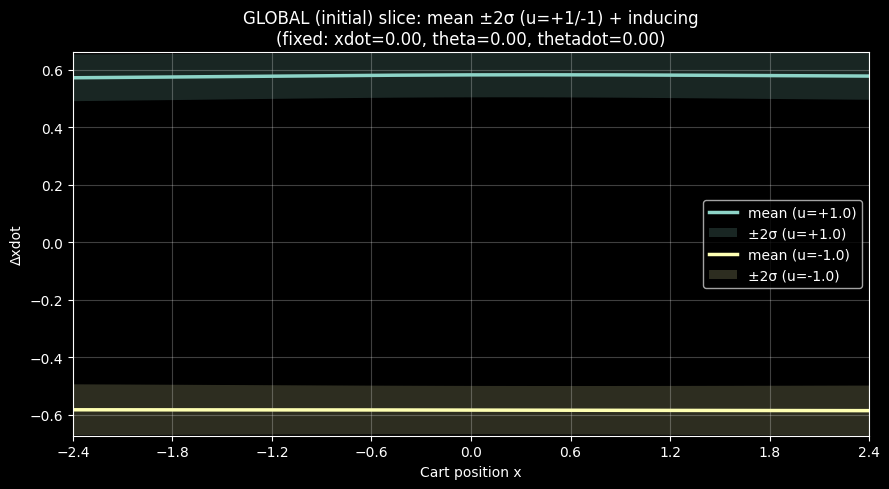

In [5]:
# ============================
# Cell 5 — Evaluate + Visualize GLOBAL GP (Reusable)
#
# What this cell provides:
#   ✅ RMSE for dx, dxdot, dtheta, dthetadot on Xte
#   ✅ Slice plot (mean ±2σ) for chosen output model (default: Δxdot)
#   ✅ 3D Surface mean colored by std (default: Δxdot over x, xdot)
#   ✅ NEW: 3D Surface of std alone (so you can SEE uncertainty shrink/grow)
#
# Assumes you ran:
#   Cell 4 (trained global models + plot helpers already defined)
#
# Expected variables available:
#   m_dx, m_dxdot, m_dth, m_dthdot
#   Xte, Ydx_te, Ydxdot_te, Ydth_te, Ydthdot_te
#   plot_slice_x_two_actions_cartpole()
#   plot_surface_x_xdot_mean_colored_by_std()
#   gp_predict_mu_std_fast()
# ============================

import numpy as np
import plotly.graph_objects as go

# ----------------------------
# 0) RMSE helper
# ----------------------------
def rmse_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

# ----------------------------
# 1) RMSE report
# ----------------------------
def print_global_rmse():
    mu_dx, _     = gp_predict_mu_std_fast(m_dx,     Xte)
    mu_dxdot, _  = gp_predict_mu_std_fast(m_dxdot,  Xte)
    mu_dth, _    = gp_predict_mu_std_fast(m_dth,    Xte)
    mu_dthdot, _ = gp_predict_mu_std_fast(m_dthdot, Xte)

    print("=== Test RMSE (global models) ===")
    print(f"dx        RMSE: {rmse_np(mu_dx,     Ydx_te):.6f}")
    print(f"dxdot     RMSE: {rmse_np(mu_dxdot,  Ydxdot_te):.6f}   (Δxdot / delta v)")
    print(f"dtheta    RMSE: {rmse_np(mu_dth,    Ydth_te):.6f}")
    print(f"dthetadot RMSE: {rmse_np(mu_dthdot, Ydthdot_te):.6f}")

# ----------------------------
# 2) Std-only surface (uncertainty surface)
# ----------------------------
def plot_surface_x_xdot_std_only(
    model,
    title="3D Std surface (uncertainty only)",
    theta_fixed=0.0,
    thetadot_fixed=0.0,
    u_fixed=+1.0,
    x_min=-2.4, x_max=2.4,
    xdot_min=-3.0, xdot_max=3.0,
    n_grid=70,
):
    x_grid = np.linspace(x_min, x_max, n_grid)
    xd_grid = np.linspace(xdot_min, xdot_max, n_grid)
    X, XD = np.meshgrid(x_grid, xd_grid)

    X_feat = np.vstack([
        state_to_features(x, xdot, theta_fixed, thetadot_fixed, u_fixed)
        for x, xdot in zip(X.ravel(), XD.ravel())
    ]).astype(np.float64)

    _, std = gp_predict_mu_std_fast(model, X_feat)
    Std = std.reshape(X.shape)

    fig = go.Figure(
        data=[
            go.Surface(
                x=X, y=XD, z=Std,
                colorscale="Viridis",
                colorbar=dict(title="Std"),
                opacity=0.98,
                showscale=True,
                name="std surface"
            )
        ]
    )
    fig.update_layout(
        title=f"{title} | fixed u={u_fixed:+.1f}, theta={theta_fixed:.2f}, thetadot={thetadot_fixed:.2f}",
        scene=dict(
            xaxis=dict(title="x", range=[x_min, x_max]),
            yaxis=dict(title="xdot", range=[xdot_min, xdot_max]),
            zaxis=dict(title="std"),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=650
    )
    fig.show()

# ----------------------------
# 3) One-call global evaluation bundle (REUSABLE after updates)
# ----------------------------
def eval_and_plot_global(tag="GLOBAL (init)",
                         model_for_plots=None,
                         theta_fixed=0.0,
                         thetadot_fixed=0.0,
                         u_fixed=+1.0):
    """
    model_for_plots: choose which output model to visualize (default m_dxdot)
    """
    if model_for_plots is None:
        model_for_plots = m_dxdot

    print("\n==============================")
    print(f"GLOBAL EVAL: {tag}")
    print("==============================")
    print_global_rmse()

    # Slice: mean ±2σ, compare u=+1/-1
    plot_slice_x_two_actions_cartpole(
        model=model_for_plots,
        X_train=Xtr,
        y_train=Ydxdot_tr if (model_for_plots is m_dxdot) else Ydx_tr,
        title=f"{tag} slice: mean ±2σ (u=+1/-1) + inducing",
        y_label="Δxdot" if (model_for_plots is m_dxdot) else "Δx",
        xdot_fixed=0.0,
        theta_fixed=theta_fixed,
        thetadot_fixed=thetadot_fixed,
        x_min=-2.4, x_max=2.4,
        n_grid=260,
        u_list=(+1.0, -1.0),
    )

    # Surface: mean colored by std (your current favorite)
    plot_surface_x_xdot_mean_colored_by_std(
        model=model_for_plots,
        title=f"{tag} surface: mean colored by std (+ inducing)",
        z_label="Δxdot" if (model_for_plots is m_dxdot) else "Δx",
        theta_fixed=theta_fixed,
        thetadot_fixed=thetadot_fixed,
        u_fixed=u_fixed,
        x_min=-2.4, x_max=2.4,
        xdot_min=-3.0, xdot_max=3.0,
        n_grid=70,
        show_inducing=True,
    )

    # NEW: std-only surface (uncertainty itself)
    plot_surface_x_xdot_std_only(
        model=model_for_plots,
        title=f"{tag} surface: std only (uncertainty)",
        theta_fixed=theta_fixed,
        thetadot_fixed=thetadot_fixed,
        u_fixed=u_fixed,
        x_min=-2.4, x_max=2.4,
        xdot_min=-3.0, xdot_max=3.0,
        n_grid=70,
    )

# ----------------------------
# RUN ONCE FOR INITIAL GLOBAL
# ----------------------------
eval_and_plot_global(tag="GLOBAL (initial)", model_for_plots=m_dxdot, u_fixed=+1.0)


In [6]:
# # ===========================
# # Cell 6 — MPPI + Online OSGPR (FIXED global inducing) + Local subset (PALSGP-style)
# #   ✅ SAME PIPELINE as before, but FIXES “run 2 becomes super slow”:
# #      - NO tf.function re-tracing when local subset changes
# #      - We keep ONE compiled predictor module per head and only update its tensors
# # ===========================
#
# import time
# import copy
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import animation
# from IPython.display import HTML, display
# import plotly.graph_objects as go
# import gpflow
# import tensorflow as tf
# from scipy.stats import chi2
# from gpflow.utilities import parameter_dict, multiple_assign
#
# # ----------------------------
# # Enforce float64 (per your pipeline going forward)
# # ----------------------------
# try:
#     gpflow.config.set_default_float(np.float64)
# except Exception:
#     pass
# DTYPE_TF = gpflow.default_float()
# assert DTYPE_TF == tf.float64, f"Expected float64 default, got {DTYPE_TF}. Set gpflow default float to float64 in earlier cells."
#
# # ----------------------------
# # GPU sanity / enforcement
# # ----------------------------
# REQUIRE_GPU = True
# LOG_DEVICE_PLACEMENT = False
#
# print("TF built with CUDA:", tf.test.is_built_with_cuda())
# print("GPUs visible:", tf.config.list_physical_devices("GPU"))
# print("Logical GPUs:", tf.config.list_logical_devices("GPU"))
#
# if LOG_DEVICE_PLACEMENT:
#     tf.debugging.set_log_device_placement(True)
#
# if REQUIRE_GPU:
#     gpus = tf.config.list_physical_devices("GPU")
#     if len(gpus) == 0:
#         raise RuntimeError("REQUIRE_GPU=True but no GPU is visible to TensorFlow. Fix CUDA/TF install or set REQUIRE_GPU=False.")
#
# # ----------------------------
# # Config (UNCHANGED behavior)
# # ----------------------------
# HORIZON    = 40
# K_SAMPLES  = 128
# SIGMA      = 0.6
# LAMBDA     = 1.0
#
# UPDATE_EVERY = 40
# ITERS_UPDATE = 100
# LR_UPDATE    = 0.02
# NOISE_UPDATE = 1e-4
#
# M_GLOBAL = 256
#
# M_SUB           = 48
# DIVERSITY_FRAC  = 0.35
#
# ANCHOR_M   = 12
# ANCHOR_LAM = 1e-6
#
# X_BAND      = 0.60
# UPRIGHT_COS = 0.85
# HOLD_STEPS  = 200
#
# # Recording (visualization; excluded from runtime)
# RECORD_RGB_DEFAULT   = True
# RESIZE       = (720, 450)
# FPS          = 10
# FRAME_STRIDE = 2
#
# # Exploration schedule
# EXPLORE_STEPS = 1
# UNC_W_MAX     = 15.0
# UNC_W_MIN     = 0.0
# CENTER_W      = 1.0
# U_W           = 0.005
# UPRIGHT_W     = 2.0
#
# if "U_MIN" not in globals(): U_MIN = -1.0
# if "U_MAX" not in globals(): U_MAX = +1.0
#
# PLOT_EACH_UPDATE = False
#
# LOCAL_REBUILD_EVERY   = 10
# LOCAL_OVERLAP_THRESH  = 0.70
#
# TUBE_ALPHA      = 0.99
# TUBE_COV_EPS    = 1e-6
# TUBE_TIME_BINS  = 16
# TUBE_FALLBACK_CANDIDATES = 400
#
# STD_CMIN_FIXED = 0.0
# STD_FIXED_Q    = 0.5
# STD_MODE       = "fixed"
# STD_CMAX_FIXED = None
#
# PLOT_X_MIN, PLOT_X_MAX = -2.4, 2.4
# PLOT_V_MIN, PLOT_V_MAX = -3.0, 3.0
# PLOT_N_GRID            = 60
# PLOT_TH_FIXED          = 0.0
# PLOT_THDOT_FIXED       = 0.0
# PLOT_U_FIXED           = +1.0
#
# STORE_GLOBAL_SURFACES = True
# GLOBAL_SURF_HISTORY = []   # reset per RUN
#
# # ----------------------------
# # NEW: Cross-method registry for unified evaluation plots
# # ----------------------------
# if "EVAL_REGISTRY" not in globals():
#     EVAL_REGISTRY = {}   # method_name -> dict(curves...)
#
# def register_method_results(method_name, payload):
#     EVAL_REGISTRY[str(method_name)] = payload
#
# def plot_compare_across_methods(keys=("pred_mean","wall_cum_mean","train_update_mean","train_update_cum_mean"),
#                                 title_prefix="COMPARE"):
#     if len(EVAL_REGISTRY) == 0:
#         print("⚠️ EVAL_REGISTRY is empty; run at least one method cell first.")
#         return
#
#     for key in keys:
#         plt.figure(figsize=(10, 3.2))
#         for name, d in EVAL_REGISTRY.items():
#             if key not in d:
#                 continue
#             t = d.get("t_axis", None)
#             if t is None:
#                 t = d.get("train_update_t", None) if "train_update" in key else None
#             y = d[key]
#             if t is None:
#                 continue
#             T = min(len(t), len(y))
#             plt.plot(t[:T], y[:T], label=name)
#         plt.xlabel("timestep")
#         plt.ylabel(key)
#         plt.title(f"{title_prefix}: {key}")
#         plt.grid(True, alpha=0.25)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()
#
# # ----------------------------
# # Safety: require dependencies from earlier cells
# # ----------------------------
# required = [
#     "make_env", "obs_to_state", "wrap_pi", "state_to_features",
#     "batch_state_to_features", "OSGPR_VFE", "train_osgpr",
#     "extract_summary_from_model", "greedy_dopt_anchors_from_K",
#     "clone_kernel",
# ]
# missing = [k for k in required if k not in globals()]
# if len(missing) > 0:
#     raise NameError(f"Cell 6 missing required symbols from earlier cells: {missing}")
#
# if "render_cartpole_frame_from_state" not in globals():
#     print("⚠️ render_cartpole_frame_from_state not found. RGB recording will be disabled.")
#     RECORD_RGB_DEFAULT = False
#
# # ----------------------------
# # Helper: sym_jitter
# # ----------------------------
# def sym_jitter(A, jitter=1e-6):
#     A = np.asarray(A, dtype=np.float64)
#     A = 0.5 * (A + A.T)
#     return A + float(jitter) * np.eye(A.shape[0], dtype=np.float64)
#
# # ----------------------------
# # Precompute a fixed plot grid (same for all updates)
# # ----------------------------
# def build_fixed_plot_grid():
#     xg = np.linspace(PLOT_X_MIN, PLOT_X_MAX, PLOT_N_GRID)
#     vg = np.linspace(PLOT_V_MIN, PLOT_V_MAX, PLOT_N_GRID)
#     X, V = np.meshgrid(xg, vg)
#
#     Xfeat_grid = np.vstack([
#         state_to_features(x, xdot, PLOT_TH_FIXED, PLOT_THDOT_FIXED, PLOT_U_FIXED)
#         for x, xdot in zip(X.ravel(), V.ravel())
#     ]).astype(np.float64)
#     return X, V, Xfeat_grid
#
# PLOT_XMESH, PLOT_VMESH, PLOT_XFEAT_GRID = build_fixed_plot_grid()
#
# # ----------------------------
# # Global predict helpers (mean/std)
# # ----------------------------
# def gp_predict_mu_std_fast(model, X):
#     X = np.asarray(X, dtype=np.float64)
#     if hasattr(model, "predict_f_cached"):
#         mu_tf, var_tf = model.predict_f_cached(X, full_cov=False)
#     else:
#         mu_tf, var_tf = model.predict_f(X, full_cov=False)
#     mu = mu_tf.numpy().reshape(-1)
#     var = var_tf.numpy().reshape(-1)
#     std = np.sqrt(np.maximum(var, 1e-12))
#     return mu, std
#
# def update_unified_std_scale(std_list, q=0.99, mode="fixed"):
#     global STD_CMAX_FIXED
#     all_std = np.concatenate([np.asarray(s, dtype=np.float64).reshape(-1) for s in std_list if s is not None], axis=0)
#     if all_std.size == 0:
#         if STD_CMAX_FIXED is None:
#             STD_CMAX_FIXED = 1.0
#         return (STD_CMIN_FIXED, STD_CMAX_FIXED)
#
#     cand = float(np.quantile(all_std, q))
#     cand = max(cand, 1e-8)
#
#     if STD_CMAX_FIXED is None:
#         STD_CMAX_FIXED = cand
#     elif mode == "grow_only":
#         STD_CMAX_FIXED = max(STD_CMAX_FIXED, cand)
#
#     return (STD_CMIN_FIXED, STD_CMAX_FIXED)
#
# # ============================================================
# # CLEAN multi-head Z_GLOBAL refit (unchanged behavior)
# # ============================================================
# def refit_Z_global_multihead(Z_global, Xnew, M_global, lam=1e-6, mode="mean", normalize_traces=False):
#     Z_global = np.asarray(Z_global, dtype=np.float64)
#     Xnew = np.asarray(Xnew, dtype=np.float64)
#
#     Z_cand = np.vstack([Z_global, Xnew]).astype(np.float64, copy=False)
#     Zc_tf = tf.convert_to_tensor(Z_cand, dtype=tf.float64)
#
#     K_dx     = m_dx.kernel.K(Zc_tf).numpy().astype(np.float64, copy=False)
#     K_dxdot  = m_dxdot.kernel.K(Zc_tf).numpy().astype(np.float64, copy=False)
#     K_dth    = m_dth.kernel.K(Zc_tf).numpy().astype(np.float64, copy=False)
#     K_dthdot = m_dthdot.kernel.K(Zc_tf).numpy().astype(np.float64, copy=False)
#
#     if normalize_traces:
#         def _norm(K):
#             tr = float(np.trace(K))
#             return K / max(tr, 1e-12)
#         K_dx, K_dxdot, K_dth, K_dthdot = map(_norm, [K_dx, K_dxdot, K_dth, K_dthdot])
#
#     if mode == "sum":
#         K_agg = (K_dx + K_dxdot + K_dth + K_dthdot)
#     else:
#         K_agg = (K_dx + K_dxdot + K_dth + K_dthdot) / 4.0
#
#     idxZ = greedy_dopt_anchors_from_K(K_agg, m_anchors=int(M_global), lam=float(lam))
#     Z_new = np.asarray(Z_cand[np.asarray(idxZ, dtype=np.int64)], dtype=np.float64)
#
#     if Z_new.shape[0] != int(M_global):
#         Z_new = Z_new[:int(M_global)].copy()
#     return Z_new
#
# # ----------------------------
# # Online OSGPR update (unchanged behavior)
# # ----------------------------
# def osgpr_stream_update(model_old, X_new, Y_new, Z_new,
#                         iters=100, lr=0.02, noise=1e-4,
#                         freeze_kernel=False, clip_norm=10.0):
#     X_new = np.asarray(X_new, dtype=np.float64)
#     Y_new = np.asarray(Y_new, dtype=np.float64).reshape(-1, 1)
#
#     mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)
#     Z_new = np.asarray(Z_new, dtype=np.float64)
#
#     k_new = clone_kernel(model_old.kernel)
#
#     m = OSGPR_VFE(
#         data=(X_new, Y_new),
#         kernel=k_new,
#         mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
#         Z=Z_new
#     )
#     m.likelihood.variance.assign(float(noise))
#
#     if freeze_kernel:
#         try:
#             m.kernel.variance.trainable = False
#             m.kernel.lengthscales.trainable = False
#         except Exception:
#             pass
#
#     t_train, last_loss = train_osgpr(m, iters=iters, lr=lr, clip_norm=clip_norm)
#     m.build_predict_cache()
#
#     info = dict(
#         train_seconds=float(t_train),
#         last_neg_objective=float(last_loss),
#         M_new=int(m.inducing_variable.num_inducing),
#     )
#     return m, info
#
# # ============================================================
# # Anchors via aggregated kernel on Z_GLOBAL (unchanged behavior)
# # ============================================================
# def compute_anchor_idx_dopt_from_Zglobal_multihead(Z_global, m_anchors=18, lam=1e-6, normalize_traces=True):
#     Z = np.asarray(Z_global, dtype=np.float64)
#     Ztf = tf.convert_to_tensor(Z, dtype=tf.float64)
#
#     K_dx     = m_dx.kernel.K(Ztf).numpy().astype(np.float64, copy=False)
#     K_dxdot  = m_dxdot.kernel.K(Ztf).numpy().astype(np.float64, copy=False)
#     K_dth    = m_dth.kernel.K(Ztf).numpy().astype(np.float64, copy=False)
#     K_dthdot = m_dthdot.kernel.K(Ztf).numpy().astype(np.float64, copy=False)
#
#     if normalize_traces:
#         def _norm(K):
#             tr = float(np.trace(K))
#             return K / max(tr, 1e-12)
#         K_dx, K_dxdot, K_dth, K_dthdot = map(_norm, [K_dx, K_dxdot, K_dth, K_dthdot])
#
#     K_agg = (K_dx + K_dxdot + K_dth + K_dthdot) / 4.0
#     return greedy_dopt_anchors_from_K(K_agg, m_anchors=int(m_anchors), lam=float(lam))
#
# # ============================================================
# # Chi-square Mahalanobis tube selection (unchanged behavior)
# # ============================================================
# def normalize_nonnegative_weights(w, eps=1e-12):
#     w = np.asarray(w, dtype=np.float64).reshape(-1)
#     w = np.maximum(w, 0.0)
#     s = float(np.sum(w))
#     if s < eps:
#         return np.ones_like(w) / max(len(w), 1)
#     return w / s
#
# def compute_weighted_moments(rollout_inputs, rollout_weights):
#     X = np.asarray(rollout_inputs, dtype=np.float64)  # (K,H,D)
#     K, H, D = X.shape
#     w = normalize_nonnegative_weights(rollout_weights).reshape(K, 1, 1)
#     tube_mean = np.sum(w * X, axis=0)  # (H,D)
#     Xc = X - tube_mean[None, :, :]
#     tube_cov = np.einsum("khd,khe->hde", (w * Xc), Xc)  # (H,D,D)
#     return tube_mean, tube_cov
#
# def min_mahalanobis_and_argmin(points_Z, tube_mean, tube_cov, cov_eps=1e-6):
#     Z = np.asarray(points_Z, dtype=np.float64)
#     mu = np.asarray(tube_mean, dtype=np.float64)
#     Sig = np.asarray(tube_cov, dtype=np.float64)
#
#     M, D = Z.shape
#     H = mu.shape[0]
#     I = np.eye(D, dtype=np.float64)
#
#     dmin = np.full((M,), np.inf, dtype=np.float64)
#     tmin = np.zeros((M,), dtype=np.int64)
#
#     for t in range(H):
#         St = Sig[t] + float(cov_eps) * I
#         L = np.linalg.cholesky(St)
#
#         diff = (Z - mu[t:t+1, :]).T  # (D,M)
#         y = np.linalg.solve(L, diff)
#         y2 = np.linalg.solve(L.T, y)
#         quad = np.sum(diff * y2, axis=0)  # (M,)
#
#         mask = quad < dmin
#         dmin[mask] = quad[mask]
#         tmin[mask] = t
#
#     return dmin, tmin
#
# def split_even_quota(total, num_bins):
#     num_bins = int(max(1, num_bins))
#     base = total // num_bins
#     rem = total - base * num_bins
#     q = np.full((num_bins,), base, dtype=np.int64)
#     if rem > 0:
#         q[:rem] += 1
#     return q
#
# def chi2_radius_sq(alpha, D):
#     alpha = float(alpha)
#     D = int(D)
#     alpha = min(max(alpha, 1e-6), 1.0 - 1e-12)
#     return float(chi2.ppf(alpha, df=D))
#
# def greedy_dopt_select_from_kernel(K, k, jitter=1e-6, log_eps=1e-300):
#     K = np.asarray(K, dtype=np.float64)
#     n = K.shape[0]
#     k = int(min(k, n))
#     if k <= 0:
#         return np.zeros((0,), dtype=np.int64)
#
#     diag = np.diag(K).copy() + float(jitter)
#     chosen = []
#     Lchol = None
#
#     for t in range(k):
#         if t == 0:
#             safe = np.maximum(diag, log_eps)
#             i = int(np.argmax(np.log(safe)))
#             chosen.append(i)
#             Lchol = np.sqrt(max(diag[i], log_eps)).reshape(1, 1)
#             continue
#
#         S = np.array(chosen, dtype=np.int64)
#         K_S = K[:, S]
#         v = np.linalg.solve(Lchol, K_S.T)
#         sq = np.sum(v * v, axis=0)
#         schur = diag - sq
#
#         schur[S] = -np.inf
#         schur_pos = np.maximum(schur, log_eps)
#         scores = np.log(schur_pos)
#         scores[S] = -np.inf
#
#         i = int(np.argmax(scores))
#         chosen.append(i)
#
#         k_iS = K[i, S].reshape(1, -1)
#         w = np.linalg.solve(Lchol, k_iS.T)
#         alpha2 = diag[i] - float(np.sum(w * w))
#         alpha2 = max(alpha2, log_eps)
#         alpha = np.sqrt(alpha2)
#
#         Lnew = np.zeros((t + 1, t + 1), dtype=np.float64)
#         Lnew[:t, :t] = Lchol
#         Lnew[t, :t] = w.reshape(-1)
#         Lnew[t, t] = alpha
#         Lchol = Lnew
#
#     return np.array(chosen, dtype=np.int64)
#
# def select_tube_subset(
#     Z_global,
#     kernel_for_dopt,
#     rollout_inputs,
#     rollout_weights,
#     total_subset_size=64,
#     anchor_idx=None,
#     time_bins=16,
#     cov_eps=1e-6,
#     dopt_jitter=1e-6,
#     fallback_candidates=400,
#     alpha=0.99,
# ):
#     Zg = np.asarray(Z_global, dtype=np.float64)
#     M = Zg.shape[0]
#
#     if anchor_idx is None:
#         anchor_idx = np.zeros((0,), dtype=np.int64)
#     anchor_idx = np.unique(np.asarray(anchor_idx, dtype=np.int64))
#     anchor_idx = anchor_idx[(anchor_idx >= 0) & (anchor_idx < M)]
#
#     tube_mean, tube_cov = compute_weighted_moments(rollout_inputs, rollout_weights)
#     H, D = tube_mean.shape
#
#     chi2_thr = chi2_radius_sq(alpha, D)
#
#     dmin, tmin = min_mahalanobis_and_argmin(Zg, tube_mean, tube_cov, cov_eps=cov_eps)
#     tube_candidates_idx = np.where(dmin <= chi2_thr)[0].astype(np.int64)
#
#     remaining_budget = int(total_subset_size - anchor_idx.size)
#     remaining_budget = max(0, remaining_budget)
#
#     if tube_candidates_idx.size < remaining_budget:
#         L = int(min(max(fallback_candidates, remaining_budget), M))
#         tube_candidates_idx = np.argsort(dmin)[:L].astype(np.int64)
#
#     tube_pool = tube_candidates_idx[~np.isin(tube_candidates_idx, anchor_idx)]
#     tmin_pool = tmin[tube_pool]
#
#     selected = set(int(i) for i in anchor_idx)
#
#     if remaining_budget > 0 and tube_pool.size > 0:
#         B = int(max(1, min(time_bins, H)))
#         edges = np.linspace(0, H, B + 1, dtype=np.int64)
#         quotas = split_even_quota(remaining_budget, B)
#
#         for b in range(B):
#             if len(selected) >= total_subset_size:
#                 break
#
#             a, c = int(edges[b]), int(edges[b + 1])
#             if c <= a:
#                 continue
#
#             in_bin = (tmin_pool >= a) & (tmin_pool < c)
#             bin_pool = tube_pool[in_bin]
#             if bin_pool.size == 0:
#                 continue
#
#             k_b = int(min(quotas[b], bin_pool.size, total_subset_size - len(selected)))
#             if k_b <= 0:
#                 continue
#
#             Zb = Zg[bin_pool]
#             Kb = kernel_for_dopt.K(tf.convert_to_tensor(Zb, dtype=tf.float64)).numpy().astype(np.float64)
#             pick = greedy_dopt_select_from_kernel(Kb, k=k_b, jitter=dopt_jitter)
#
#             for gidx in bin_pool[pick]:
#                 selected.add(int(gidx))
#
#     if len(selected) < total_subset_size:
#         need = int(total_subset_size - len(selected))
#         leftover = tube_pool[~np.isin(tube_pool, np.array(list(selected), dtype=np.int64))]
#         if leftover.size > 0 and need > 0:
#             Zl = Zg[leftover]
#             Kl = kernel_for_dopt.K(tf.convert_to_tensor(Zl, dtype=tf.float64)).numpy().astype(np.float64)
#             pick = greedy_dopt_select_from_kernel(Kl, k=min(need, leftover.size), jitter=dopt_jitter)
#             for gidx in leftover[pick]:
#                 selected.add(int(gidx))
#
#     if len(selected) < total_subset_size:
#         need = int(total_subset_size - len(selected))
#         remaining = np.setdiff1d(np.arange(M, dtype=np.int64), np.array(list(selected), dtype=np.int64), assume_unique=False)
#         if remaining.size > 0:
#             order = remaining[np.argsort(dmin[remaining])]
#             for gidx in order[:need]:
#                 selected.add(int(gidx))
#
#     subset_idx = np.array(sorted(selected), dtype=np.int64)[:total_subset_size]
#     return subset_idx, tube_mean, tube_cov, tube_candidates_idx, chi2_thr
#
# # ============================================================
# # TF local predictor pack (NO RETRACING)
# # ============================================================
# @tf.function
# def wrap_pi_tf(theta):
#     two_pi = tf.constant(2.0 * np.pi, dtype=DTYPE_TF)
#     pi = tf.constant(np.pi, dtype=DTYPE_TF)
#     return tf.math.floormod(theta + pi, two_pi) - pi
#
# @tf.function
# def batch_state_to_features_tf(S, U):
#     x = S[:, 0]
#     xdot = S[:, 1]
#     th = S[:, 2]
#     thdot = S[:, 3]
#     f0 = tf.tanh(x / tf.constant(2.4, dtype=DTYPE_TF))
#     f1 = tf.tanh(xdot / tf.constant(3.0, dtype=DTYPE_TF))
#     f2 = tf.sin(th)
#     f3 = tf.cos(th)
#     f4 = tf.tanh(thdot / tf.constant(8.0, dtype=DTYPE_TF))
#     f5 = U
#     return tf.stack([f0, f1, f2, f3, f4, f5], axis=1)
#
# @tf.function
# def se_ard_kernel_Kzx_tf(Z, X, lengthscales, variance):
#     ls = tf.reshape(lengthscales, (1, -1))
#     var = tf.cast(variance, DTYPE_TF)
#     Zs = Z / ls
#     Xs = X / ls
#     z2 = tf.reduce_sum(Zs * Zs, axis=1, keepdims=True)
#     x2 = tf.reduce_sum(Xs * Xs, axis=1, keepdims=True)
#     zx = tf.matmul(Zs, Xs, transpose_b=True)
#     r2 = tf.maximum(z2 + tf.transpose(x2) - 2.0 * zx, 0.0)
#     return var * tf.exp(-0.5 * r2)
#
# class LocalSubsetPredictor(tf.Module):
#     def __init__(self, Dfeat, Msub, name=None):
#         super().__init__(name=name)
#         self.Dfeat = int(Dfeat)
#         self.Msub  = int(Msub)
#
#         # IMPORTANT: fixed shapes = (M_SUB, ·) so assign() never shape-mismatches
#         self.Z     = tf.Variable(tf.zeros([self.Msub, self.Dfeat], dtype=tf.float64), trainable=False)
#         self.L     = tf.Variable(tf.eye(self.Msub, dtype=tf.float64), trainable=False)
#         self.alpha = tf.Variable(tf.zeros([self.Msub, 1], dtype=tf.float64), trainable=False)
#         self.S     = tf.Variable(tf.eye(self.Msub, dtype=tf.float64), trainable=False)
#
#         self.ls    = tf.Variable(tf.ones([self.Dfeat], dtype=tf.float64), trainable=False)
#         self.var   = tf.Variable(1.0, dtype=tf.float64, trainable=False)
#
#     def assign_pack(self, Z, L, alpha, S, ls, var):
#         # All of these must be exactly M_SUB-sized
#         self.Z.assign(tf.cast(Z, tf.float64))
#         self.L.assign(tf.cast(L, tf.float64))
#         self.alpha.assign(tf.cast(alpha, tf.float64))
#         self.S.assign(tf.cast(S, tf.float64))
#         self.ls.assign(tf.cast(ls, tf.float64))
#         self.var.assign(tf.cast(var, tf.float64))
#
#     @tf.function(reduce_retracing=True)
#     def predict_mu_var(self, Xfeat):
#         Xfeat = tf.cast(Xfeat, tf.float64)
#         Kzx = se_ard_kernel_Kzx_tf(self.Z, Xfeat, self.ls, self.var)  # (M,N)
#
#         w1 = tf.linalg.triangular_solve(self.L, Kzx, lower=True)
#         W  = tf.linalg.triangular_solve(tf.transpose(self.L), w1, lower=False)
#
#         mu = tf.reshape(tf.matmul(Kzx, self.alpha, transpose_a=True), (-1,))
#
#         kxx = tf.fill((tf.shape(Xfeat)[0],), tf.cast(self.var, tf.float64))
#         Qdiag = tf.reduce_sum(Kzx * W, axis=0)
#         SW = tf.matmul(self.S, W)
#         Sdiag = tf.reduce_sum(W * SW, axis=0)
#
#         v = tf.maximum(kxx - Qdiag + Sdiag, tf.cast(1e-12, tf.float64))
#         return mu, v
#
#
# def build_local_pack_from_global_tf(model_global, Z_global, idx_sub):
#     idx_sub = np.asarray(idx_sub, dtype=np.int64)
#     Zg = np.asarray(Z_global, dtype=np.float64)
#     Z  = Zg[idx_sub].copy()
#
#     Ztf = tf.convert_to_tensor(Z, dtype=tf.float64)
#     muZ, SigZ = model_global.predict_f(Ztf, full_cov=True)
#     m = muZ
#     S = SigZ
#     if len(S.shape) == 3:
#         S = S[0]
#
#     ls  = tf.cast(model_global.kernel.lengthscales, tf.float64)
#     var = tf.cast(model_global.kernel.variance, tf.float64)
#
#     Kzz = se_ard_kernel_Kzx_tf(Ztf, Ztf, ls, var)
#     jitter = tf.cast(1e-6, tf.float64)
#     Kzz = 0.5 * (Kzz + tf.transpose(Kzz)) + jitter * tf.eye(tf.shape(Kzz)[0], dtype=tf.float64)
#     L = tf.linalg.cholesky(Kzz)
#
#     y = tf.linalg.triangular_solve(L, m, lower=True)
#     alpha = tf.linalg.triangular_solve(tf.transpose(L), y, lower=False)
#
#     return (Ztf, L, alpha, S, tf.reshape(ls, (-1,)), var)
#
# # ============================================================
# # MPPI cost (unchanged behavior)
# # ============================================================
# @tf.function
# def exploration_weight_tf(t):
#     explore_steps_f = tf.cast(EXPLORE_STEPS, DTYPE_TF)
#     t_f = tf.cast(t, DTYPE_TF)
#     a = tf.clip_by_value(1.0 - t_f / tf.maximum(explore_steps_f, 1.0), 0.0, 1.0)
#     return tf.cast(UNC_W_MIN, DTYPE_TF) + (tf.cast(UNC_W_MAX, DTYPE_TF) - tf.cast(UNC_W_MIN, DTYPE_TF)) * a
#
# @tf.function
# def stage_cost_cartpole_tf(S, U, x_init, unc_bonus=None, unc_w=0.0):
#     th = S[:, 2]
#     x  = S[:, 0]
#     c = (
#         tf.cast(UPRIGHT_W, DTYPE_TF) * (1.0 - tf.cos(th))
#         + tf.cast(CENTER_W, DTYPE_TF) * tf.square(x - x_init)
#         + tf.cast(U_W, DTYPE_TF) * tf.square(U)
#     )
#     if (unc_bonus is not None) and (unc_w > 0.0):
#         c = c - tf.cast(unc_w, DTYPE_TF) * tf.cast(unc_bonus, DTYPE_TF)
#     return c
#
# @tf.function
# def terminal_cost_hold_like_tf(S, x_init):
#     th = S[:, 2]
#     x  = S[:, 0]
#     cT = tf.zeros_like(th)
#     good = tf.logical_and(tf.cos(th) >= tf.cast(UPRIGHT_COS, DTYPE_TF),
#                           tf.abs(x - x_init) <= tf.cast(X_BAND, DTYPE_TF))
#     cT = tf.where(good, cT - tf.cast(5.0, DTYPE_TF), cT)
#     return cT
#
# # ============================================================
# # Global-local dynamics: uses persistent predictors (NO RETRACING)
# # ============================================================
# # We will create these per episode (to keep clean), but they are persistent within the episode
# # and DO NOT create new tf.functions on rebuild; only assign tensors.
#
# @tf.function(reduce_retracing=True)
# def gp_dynamics_step_batch_local_tf(S, U, local_dx, local_dxdot, local_dth, local_dthdot):
#     Xfeat = batch_state_to_features_tf(S, U)
#
#     dx, _     = local_dx.predict_mu_var(Xfeat)
#     dxdot, _  = local_dxdot.predict_mu_var(Xfeat)
#     dth, _    = local_dth.predict_mu_var(Xfeat)
#     dthdot, _ = local_dthdot.predict_mu_var(Xfeat)
#
#     S2 = tf.stack([
#         S[:, 0] + dx,
#         S[:, 1] + dxdot,
#         wrap_pi_tf(S[:, 2] + dth),
#         S[:, 3] + dthdot
#     ], axis=1)
#     return S2, Xfeat
#
# @tf.function(reduce_retracing=True)
# def rollout_tube_features_local_tf(state0, u_seq, local_dx, local_dxdot, local_dth, local_dthdot):
#     H = tf.shape(u_seq)[0]
#     s = tf.identity(state0)
#     tube = tf.TensorArray(dtype=DTYPE_TF, size=H)
#
#     t = tf.constant(0)
#     def cond(t, s, tube): return t < H
#     def body(t, s, tube):
#         u = u_seq[t]
#         xfeat = batch_state_to_features_tf(tf.expand_dims(s, axis=0), tf.expand_dims(u, axis=0))[0]
#         tube = tube.write(t, xfeat)
#         s2, _ = gp_dynamics_step_batch_local_tf(tf.expand_dims(s, axis=0), tf.expand_dims(u, axis=0),
#                                                local_dx, local_dxdot, local_dth, local_dthdot)
#         s = s2[0]
#         return t+1, s, tube
#
#     _, _, tube = tf.while_loop(cond, body, [t, s, tube], parallel_iterations=1)
#     return tube.stack()
#
# @tf.function(reduce_retracing=True)
# def mppi_plan_gpu_local_tf(state0, x_init, u_mean0, t_global,
#                            local_dx, local_dxdot, local_dth, local_dthdot,
#                            horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
#                            base_seed=0):
#     H = tf.cast(horizon, tf.int32)
#     Kt = tf.cast(K, tf.int32)
#
#     seed = tf.stack([tf.cast(base_seed, tf.int32), tf.cast(t_global, tf.int32)], axis=0)
#     eps = tf.random.stateless_normal((Kt, H), seed=seed, mean=0.0, stddev=tf.cast(sigma, DTYPE_TF), dtype=DTYPE_TF)
#     U = tf.clip_by_value(u_mean0[None, :] + eps, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))
#
#     S = tf.tile(state0[None, :], [Kt, 1])
#     total_cost = tf.zeros((Kt,), dtype=DTYPE_TF)
#
#     Xta = tf.TensorArray(dtype=DTYPE_TF, size=H)
#     unc_w = exploration_weight_tf(t_global)
#
#     t = tf.constant(0, dtype=tf.int32)
#     def cond(t, S, total_cost, Xta): return t < H
#     def body(t, S, total_cost, Xta):
#         Ut = U[:, t]
#         S2, Xfeat = gp_dynamics_step_batch_local_tf(S, Ut, local_dx, local_dxdot, local_dth, local_dthdot)
#         Xta = Xta.write(t, Xfeat)
#
#         # uncertainty bonus uses dxdot variance (same as before)
#         _, unc_v = local_dxdot.predict_mu_var(Xfeat)
#         total_cost = total_cost + stage_cost_cartpole_tf(S, Ut, x_init=tf.cast(x_init, DTYPE_TF),
#                                                          unc_bonus=unc_v, unc_w=unc_w)
#         return t+1, S2, total_cost, Xta
#
#     _, S, total_cost, Xta = tf.while_loop(cond, body, [t, S, total_cost, Xta], parallel_iterations=1)
#     total_cost = total_cost + terminal_cost_hold_like_tf(S, x_init=tf.cast(x_init, DTYPE_TF))
#
#     cmin = tf.reduce_min(total_cost)
#     w = tf.exp(-(total_cost - cmin) / tf.cast(lam, DTYPE_TF))
#     wsum = tf.reduce_sum(w) + tf.cast(1e-12, DTYPE_TF)
#
#     u_mean = u_mean0 + tf.reduce_sum(w[:, None] * eps, axis=0) / wsum
#     u_mean = tf.clip_by_value(u_mean, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))
#
#     tubeX = rollout_tube_features_local_tf(state0, u_mean, local_dx, local_dxdot, local_dth, local_dthdot)
#     XHKD = Xta.stack()
#     Xroll = tf.transpose(XHKD, perm=[1, 0, 2])
#     return u_mean[0], u_mean, tubeX, unc_w, Xroll, w
#
# def mppi_plan_gpu_local(state, x_init, u_init, t_global,
#                         local_dx, local_dxdot, local_dth, local_dthdot,
#                         base_seed=0):
#     state0 = tf.convert_to_tensor(np.asarray(state, dtype=np.float64).reshape(4,), dtype=DTYPE_TF)
#     x0     = tf.convert_to_tensor(float(x_init), dtype=DTYPE_TF)
#     u0     = tf.convert_to_tensor(np.asarray(u_init, dtype=np.float64).reshape(-1,), dtype=DTYPE_TF)
#
#     dev = "/GPU:0" if len(tf.config.list_logical_devices("GPU")) > 0 else "/CPU:0"
#     if REQUIRE_GPU: dev = "/GPU:0"
#
#     with tf.device(dev):
#         u_first, u_mean, tubeX, unc_w, Xroll, w = mppi_plan_gpu_local_tf(
#             state0, x0, u0, tf.convert_to_tensor(int(t_global), dtype=tf.int32),
#             local_dx, local_dxdot, local_dth, local_dthdot,
#             horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
#             base_seed=int(base_seed)
#         )
#
#     return float(u_first.numpy()), u_mean.numpy(), tubeX.numpy(), float(unc_w.numpy()), Xroll.numpy(), w.numpy()
#
# # ----------------------------
# # Visualization helpers
# # ----------------------------
# def plot_surface_global_dxdot(model_like,
#                              title="Surface", std_clim=None,
#                              Xmesh=PLOT_XMESH, Vmesh=PLOT_VMESH, Xfeat_grid=PLOT_XFEAT_GRID,
#                              show_colorbar=True):
#     mu, std = gp_predict_mu_std_fast(model_like, Xfeat_grid)
#     Mean = mu.reshape(Xmesh.shape)
#     Std  = std.reshape(Xmesh.shape)
#
#     cmin = cmax = None
#     if std_clim is not None:
#         cmin, cmax = float(std_clim[0]), float(std_clim[1])
#
#     surface = go.Surface(
#         x=Xmesh, y=Vmesh, z=Mean,
#         surfacecolor=Std,
#         colorscale="Viridis",
#         cmin=cmin, cmax=cmax,
#         colorbar=(dict(title="Std") if show_colorbar else None),
#         showscale=bool(show_colorbar),
#         opacity=0.95,
#         name="surface"
#     )
#     fig = go.Figure(data=[surface])
#     fig.update_layout(
#         title=title,
#         scene=dict(
#             xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
#             yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
#             zaxis=dict(title="Δxdot"),
#         ),
#         margin=dict(l=0, r=0, b=0, t=50),
#         height=620
#     )
#     fig.show()
#
# def success_hold_update(state, x_init, hold_count):
#     x, xdot, th, thdot = state
#     upright = (np.cos(th) >= UPRIGHT_COS)
#     centered = (abs(x - x_init) <= X_BAND)
#     hold_count = (hold_count + 1) if (upright and centered) else 0
#     success = (hold_count >= HOLD_STEPS)
#     return hold_count, success, upright, centered
#
# def display_run_animation_from_frames(frames, fps=FPS, resize=RESIZE):
#     if frames is None or len(frames) == 0:
#         print("⚠️ No frames captured for this run.")
#         return None
#
#     fig = plt.figure(figsize=(resize[0]/100, resize[1]/100), dpi=100)
#     plt.axis("off")
#     im = plt.imshow(frames[0])
#
#     def animate_fn(i):
#         im.set_data(frames[i])
#         return [im]
#
#     ani = animation.FuncAnimation(
#         fig, animate_fn,
#         frames=len(frames),
#         interval=1000 / float(fps),
#         blit=True
#     )
#     plt.close(fig)
#     html = HTML(ani.to_jshtml())
#     display(html)
#     return html
#
# # ============================================================
# # Single EPISODE runner
# # ============================================================
# def run_one_episode_mppi_retrain_rgb_with_eval(
#     max_steps=600, seed=0, start_down=True, verbose=True,
#     use_gpu_mppi=True,
#     warmup_mppi=True,
#     record_rgb=True,
#     t_offset_in_run=0,
#     return_frames=False,
# ):
#     global m_dx, m_dxdot, m_dth, m_dthdot
#     global Z_GLOBAL
#     global STD_CMAX_FIXED
#
#     env = make_env(render_mode=None, seed=seed, max_episode_steps=max_steps, start_down=start_down)
#     obs, info = env.reset(seed=seed)
#     s = np.array(obs_to_state(obs), dtype=np.float64)
#     x_init = float(s[0])
#
#     # Ensure Z_GLOBAL fixed size
#     Z_GLOBAL = np.asarray(Z_GLOBAL, dtype=np.float64)
#     if Z_GLOBAL.shape[0] != int(M_GLOBAL):
#         if Z_GLOBAL.shape[0] > int(M_GLOBAL):
#             Z_GLOBAL = Z_GLOBAL[:int(M_GLOBAL)].copy()
#         else:
#             raise ValueError(f"Z_GLOBAL has {Z_GLOBAL.shape[0]} points but M_GLOBAL={M_GLOBAL}.")
#
#     # anchors
#     ANCHOR_IDX = compute_anchor_idx_dopt_from_Zglobal_multihead(
#         Z_GLOBAL, m_anchors=ANCHOR_M, lam=ANCHOR_LAM, normalize_traces=True
#     )
#
#     # init local subset
#     u_mean = np.zeros((HORIZON,), dtype=np.float64)
#     idx_sub = np.arange(min(M_SUB, M_GLOBAL), dtype=np.int64)
#
#     # Persistent TF predictors per head (no retracing on rebuild)
#     Dfeat = int(PLOT_XFEAT_GRID.shape[1])
#     local_dx     = LocalSubsetPredictor(Dfeat, M_SUB, name="local_dx")
#     local_dxdot  = LocalSubsetPredictor(Dfeat, M_SUB, name="local_dxdot")
#     local_dth    = LocalSubsetPredictor(Dfeat, M_SUB, name="local_dth")
#     local_dthdot = LocalSubsetPredictor(Dfeat, M_SUB, name="local_dthdot")
#
#
#     def refresh_locals(idx_sub_np):
#         Z,L,a,S,ls,var = build_local_pack_from_global_tf(m_dx,     Z_GLOBAL, idx_sub_np); local_dx.assign_pack(Z,L,a,S,ls,var)
#         Z,L,a,S,ls,var = build_local_pack_from_global_tf(m_dxdot,  Z_GLOBAL, idx_sub_np); local_dxdot.assign_pack(Z,L,a,S,ls,var)
#         Z,L,a,S,ls,var = build_local_pack_from_global_tf(m_dth,    Z_GLOBAL, idx_sub_np); local_dth.assign_pack(Z,L,a,S,ls,var)
#         Z,L,a,S,ls,var = build_local_pack_from_global_tf(m_dthdot, Z_GLOBAL, idx_sub_np); local_dthdot.assign_pack(Z,L,a,S,ls,var)
#
#     refresh_locals(idx_sub)
#
#     last_idx_sub = np.array(idx_sub, dtype=np.int64)
#     last_local_rebuild_t = 0
#
#     pred_time_step = np.zeros((max_steps,), dtype=np.float64)
#     train_time_step = np.zeros((max_steps,), dtype=np.float64)
#     wall_excl_vis_cum = np.zeros((max_steps,), dtype=np.float64)
#
#     t_wall_start = time.perf_counter()
#     vis_time_s = 0.0
#
#     # warmup: compile once
#     if use_gpu_mppi and warmup_mppi:
#         _ = mppi_plan_gpu_local(
#             state=s, x_init=x_init, u_init=u_mean, t_global=int(t_offset_in_run),
#             local_dx=local_dx, local_dxdot=local_dxdot, local_dth=local_dth, local_dthdot=local_dthdot,
#             base_seed=seed
#         )
#
#     frames = []
#     total_reward = 0.0
#     hold_count = 0
#     updates = 0
#
#     Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []
#     last_rollout_inputs = None
#     last_rollout_weights = None
#
#     for t in range(max_steps):
#         t_global = int(t_offset_in_run + t)
#
#         # ---------- MPPI plan ----------
#         t0 = time.perf_counter()
#         if use_gpu_mppi:
#             u0, u_mean, tubeX, unc_w, Xroll, wroll = mppi_plan_gpu_local(
#                 state=s, x_init=x_init, u_init=u_mean, t_global=t_global,
#                 local_dx=local_dx, local_dxdot=local_dxdot, local_dth=local_dth, local_dthdot=local_dthdot,
#                 base_seed=seed
#             )
#         else:
#             raise RuntimeError("use_gpu_mppi=False path not wired in this multi-run cell (set use_gpu_mppi=True).")
#         t1 = time.perf_counter()
#         pred_time_step[t] = (t1 - t0)
#
#         last_rollout_inputs = Xroll
#         last_rollout_weights = wroll
#
#         # ---------- tube subset selection (unchanged logic) ----------
#         idx_sub_cand, _, _, _, _ = select_tube_subset(
#             Z_global=Z_GLOBAL,
#             kernel_for_dopt=m_dxdot.kernel,
#             rollout_inputs=last_rollout_inputs,
#             rollout_weights=last_rollout_weights,
#             total_subset_size=M_SUB,
#             anchor_idx=ANCHOR_IDX,
#             time_bins=TUBE_TIME_BINS,
#             cov_eps=TUBE_COV_EPS,
#             dopt_jitter=1e-6,
#             fallback_candidates=TUBE_FALLBACK_CANDIDATES,
#             alpha=TUBE_ALPHA,
#         )
#
#         inter = np.intersect1d(last_idx_sub, idx_sub_cand)
#         overlap = float(len(inter)) / float(len(idx_sub_cand)) if len(idx_sub_cand) > 0 else 1.0
#
#         need_rebuild = ((t - last_local_rebuild_t) >= int(LOCAL_REBUILD_EVERY)) or (overlap < float(LOCAL_OVERLAP_THRESH))
#         if need_rebuild:
#             idx_sub = np.array(idx_sub_cand, dtype=np.int64)
#             refresh_locals(idx_sub)  # <<< IMPORTANT: no new tf.functions, just assign tensors
#             last_idx_sub = np.array(idx_sub, dtype=np.int64)
#             last_local_rebuild_t = int(t)
#         else:
#             idx_sub = last_idx_sub
#
#         # ---------- env step ----------
#         obs2, r, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
#         s2 = np.array(obs_to_state(obs2), dtype=np.float64)
#         total_reward += float(r)
#
#         respawned = bool(isinstance(info, dict) and info.get("respawned", False))
#         if not respawned:
#             Xbuf.append(state_to_features(s[0], s[1], s[2], s[3], float(u0)))
#             ydx_buf.append([s2[0] - s[0]])
#             ydxdot_buf.append([s2[1] - s[1]])
#             ydth_buf.append([wrap_pi(s2[2] - s[2])])
#             ydthdot_buf.append([s2[3] - s[3]])
#
#         # ---------- render (excluded from wall) ----------
#         if record_rgb and RECORD_RGB_DEFAULT and (t % FRAME_STRIDE == 0):
#             tv0 = time.perf_counter()
#             W, Hh = int(RESIZE[0]), int(RESIZE[1])
#             frame = render_cartpole_frame_from_state(x=s2[0], theta=s2[2], x_threshold=2.4, W=W, H=Hh)
#             frames.append(frame)
#             vis_time_s += (time.perf_counter() - tv0)
#
#         # ---------- success tracking ----------
#         hold_count, success, upright, centered = success_hold_update(s2, x_init, hold_count)
#
#         if verbose and (t % 50 == 0):
#             print(f"[t_global={t_global:04d}] u0={u0:+.2f}  unc_w={unc_w:.2f}  upright={upright} centered={centered} hold={hold_count}/{HOLD_STEPS}")
#
#         # ---------- UPDATE (global only, unchanged logic) ----------
#         if ((t + 1) % UPDATE_EVERY == 0) and (len(Xbuf) >= 10):
#             updates += 1
#
#             Xnew  = np.asarray(Xbuf, dtype=np.float64)
#             ydx   = np.asarray(ydx_buf, dtype=np.float64)
#             ydxd  = np.asarray(ydxdot_buf, dtype=np.float64)
#             ydth  = np.asarray(ydth_buf, dtype=np.float64)
#             ydthd = np.asarray(ydthdot_buf, dtype=np.float64)
#
#             # refit Z_GLOBAL (still fixed size)
#             Z_GLOBAL = refit_Z_global_multihead(
#                 Z_global=Z_GLOBAL,
#                 Xnew=Xnew,
#                 M_global=M_GLOBAL,
#                 lam=ANCHOR_LAM,
#                 mode="mean",
#                 normalize_traces=False,
#             )
#
#             # train 4 heads (OSGPR)
#             ttrain0 = time.perf_counter()
#             m_dx,     _ = osgpr_stream_update(m_dx,     Xnew, ydx,   Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=False)
#             m_dxdot,  _ = osgpr_stream_update(m_dxdot,  Xnew, ydxd,  Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=False)
#             m_dth,    _ = osgpr_stream_update(m_dth,    Xnew, ydth,  Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=False)
#             m_dthdot, _ = osgpr_stream_update(m_dthdot, Xnew, ydthd, Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=False)
#             ttrain1 = time.perf_counter()
#             train_time_step[t] += float(ttrain1 - ttrain0)
#
#             # clear buffers
#             Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []
#
#             # reselect anchors
#             ANCHOR_IDX = compute_anchor_idx_dopt_from_Zglobal_multihead(
#                 Z_GLOBAL, m_anchors=ANCHOR_M, lam=ANCHOR_LAM, normalize_traces=True
#             )
#
#             # force rebuild subset (unchanged behavior)
#             idx_sub, _, _, _, _ = select_tube_subset(
#                 Z_global=Z_GLOBAL,
#                 kernel_for_dopt=m_dxdot.kernel,
#                 rollout_inputs=last_rollout_inputs,
#                 rollout_weights=last_rollout_weights,
#                 total_subset_size=M_SUB,
#                 anchor_idx=ANCHOR_IDX,
#                 time_bins=TUBE_TIME_BINS,
#                 cov_eps=TUBE_COV_EPS,
#                 dopt_jitter=1e-6,
#                 fallback_candidates=TUBE_FALLBACK_CANDIDATES,
#                 alpha=TUBE_ALPHA,
#             )
#             refresh_locals(idx_sub)   # <<< update tensors, no retracing
#             last_idx_sub = np.array(idx_sub, dtype=np.int64)
#             last_local_rebuild_t = int(t)
#
#             # store global surfaces (no plot)
#             if STORE_GLOBAL_SURFACES:
#                 muG, stdG = gp_predict_mu_std_fast(m_dxdot, PLOT_XFEAT_GRID)
#                 GLOBAL_SURF_HISTORY.append(dict(update=int(t_global), Mean=muG.reshape(PLOT_XMESH.shape), Std=stdG.reshape(PLOT_XMESH.shape)))
#                 _ = update_unified_std_scale([stdG.reshape(-1)], q=STD_FIXED_Q, mode=STD_MODE)
#
#         # ---------- wall time cumulative excl vis ----------
#         wall_excl_vis_cum[t] = max((time.perf_counter() - t_wall_start) - vis_time_s, 0.0)
#
#         s = s2
#         if success or terminated or truncated:
#             break
#
#     env.close()
#     steps = int(t + 1)
#
#     stats = dict(
#         total_reward=float(total_reward),
#         steps=steps,
#         updates=int(updates),
#         frames=int(len(frames)),
#         x_init=float(x_init),
#         hold_steps=int(hold_count),
#         Z_global_size=int(len(Z_GLOBAL)),
#         std_cmax_fixed=float(STD_CMAX_FIXED) if STD_CMAX_FIXED is not None else None,
#         vis_time_s=float(vis_time_s),
#     )
#
#     frames_out = frames if (return_frames and record_rgb and RECORD_RGB_DEFAULT) else None
#     return stats, frames_out, last_idx_sub, pred_time_step[:steps], train_time_step[:steps], wall_excl_vis_cum[:steps]
#
# # ============================================================
# # MULTI-RUN driver (unchanged behavior)
# # ============================================================
# N_RUNS = 1
# N_EPISODES_PER_RUN = 3
#
# MAX_STEPS_PER_EP = 1000
# USE_GPU_MPPI = True
# START_DOWN = True
# VERBOSE = True
#
# if "Z_GLOBAL" not in globals():
#     raise NameError("Z_GLOBAL must exist before Cell 6. Define initial inducing points in earlier cells.")
# Z_GLOBAL_INIT = np.asarray(Z_GLOBAL, dtype=np.float64).copy()
#
# params_dx_init     = parameter_dict(m_dx)
# params_dxdot_init  = parameter_dict(m_dxdot)
# params_dth_init    = parameter_dict(m_dth)
# params_dthdot_init = parameter_dict(m_dthdot)
#
# def reset_models_and_globals_for_fresh_run():
#     global m_dx, m_dxdot, m_dth, m_dthdot
#     global Z_GLOBAL
#     global GLOBAL_SURF_HISTORY
#     global STD_CMAX_FIXED
#
#     Z_GLOBAL = Z_GLOBAL_INIT.copy()
#     if Z_GLOBAL.shape[0] != int(M_GLOBAL):
#         if Z_GLOBAL.shape[0] > int(M_GLOBAL):
#             Z_GLOBAL = Z_GLOBAL[:int(M_GLOBAL)].copy()
#         else:
#             raise ValueError(f"Z_GLOBAL_INIT has {Z_GLOBAL.shape[0]} < M_GLOBAL={M_GLOBAL}.")
#
#     multiple_assign(m_dx,     params_dx_init)
#     multiple_assign(m_dxdot,  params_dxdot_init)
#     multiple_assign(m_dth,    params_dth_init)
#     multiple_assign(m_dthdot, params_dthdot_init)
#
#     try: m_dx.build_predict_cache()
#     except Exception: pass
#     try: m_dxdot.build_predict_cache()
#     except Exception: pass
#     try: m_dth.build_predict_cache()
#     except Exception: pass
#     try: m_dthdot.build_predict_cache()
#     except Exception: pass
#
#     GLOBAL_SURF_HISTORY = []
#     STD_CMAX_FIXED = None
#
# run_pred_time = []
# run_train_time = []
# run_wall_cum = []
# run_rewards = []
# run_steps_total = []
# run_updates_total = []
#
# for run in range(N_RUNS):
#     print(f"\n==================== RUN {run+1}/{N_RUNS} (fresh reset) ====================")
#     reset_models_and_globals_for_fresh_run()
#
#     pred_concat = []
#     train_concat = []
#     wall_concat = []
#     t_offset = 0
#
#     frames_run = []
#     run_reward_sum = 0.0
#     run_updates_sum = 0
#     run_steps_sum = 0
#
#     for ep in range(N_EPISODES_PER_RUN):
#         record_rgb = (ep == 0)
#         warmup_mppi = (ep == 0)
#
#         print(f"\n--- RUN {run+1} EP {ep+1}/{N_EPISODES_PER_RUN} (t_offset={t_offset}) ---")
#
#         stats_ep, frames_ep, _, pred_t, train_t, wall_cum_t = run_one_episode_mppi_retrain_rgb_with_eval(
#             max_steps=MAX_STEPS_PER_EP,
#             seed=1000*run + ep,
#             start_down=START_DOWN,
#             verbose=VERBOSE,
#             use_gpu_mppi=USE_GPU_MPPI,
#             warmup_mppi=warmup_mppi,
#             record_rgb=record_rgb,
#             t_offset_in_run=t_offset,
#             return_frames=True,
#         )
#
#         if record_rgb and (frames_ep is not None) and (len(frames_ep) > 0):
#             frames_run.extend(frames_ep)
#
#         pred_concat.append(pred_t)
#         train_concat.append(train_t)
#         wall_concat.append(wall_cum_t)
#
#         run_reward_sum += stats_ep["total_reward"]
#         run_updates_sum += stats_ep["updates"]
#         run_steps_sum += stats_ep["steps"]
#         t_offset += stats_ep["steps"]
#
#     pred_run = np.concatenate(pred_concat, axis=0)
#     train_run = np.concatenate(train_concat, axis=0)
#     wall_run = np.concatenate(wall_concat, axis=0)
#
#     # recompute wall cumulative cleanly
#     wall_incr = np.zeros_like(wall_run)
#     i0 = 0
#     for ep_arr in wall_concat:
#         ep_arr = np.asarray(ep_arr, dtype=np.float64)
#         if ep_arr.size > 0:
#             d = np.diff(np.concatenate([[0.0], ep_arr]))
#             wall_incr[i0:i0+len(d)] = d
#         i0 += len(ep_arr)
#     wall_cum_run = np.cumsum(np.maximum(wall_incr, 0.0))
#
#     run_pred_time.append(pred_run)
#     run_train_time.append(train_run)
#     run_wall_cum.append(wall_cum_run)
#     run_rewards.append(run_reward_sum)
#     run_steps_total.append(len(pred_run))
#     run_updates_total.append(run_updates_sum)
#
#     print(f"\n=== RUN {run+1}: single animation (episode 0 only, per your rule) ===")
#     _ = display_run_animation_from_frames(frames_run, fps=FPS, resize=RESIZE)
#
#     print(f"\n=== RUN {run+1}: final model surface (GLOBAL only) ===")
#     std_clim = (STD_CMIN_FIXED, STD_CMAX_FIXED if STD_CMAX_FIXED is not None else 1.0)
#     plot_surface_global_dxdot(
#         model_like=m_dxdot,
#         title=f"RUN {run+1} FINAL — GLOBAL Δxdot (mean colored by Std)",
#         std_clim=std_clim,
#         show_colorbar=True
#     )
#
# # ============================================================
# # Aggregate across runs: mean + band (std)  (pad with NaN)
# # ============================================================
# maxT = int(max(run_steps_total))
# def pad_to(arr, T):
#     out = np.full((T,), np.nan, dtype=np.float64)
#     out[:len(arr)] = arr
#     return out
#
# pred_mat  = np.vstack([pad_to(a, maxT) for a in run_pred_time])
# train_mat = np.vstack([pad_to(a, maxT) for a in run_train_time])
# wall_mat  = np.vstack([pad_to(a, maxT) for a in run_wall_cum])
#
# t_axis = np.arange(maxT, dtype=np.int64)
#
# pred_mean  = np.nanmean(pred_mat, axis=0)
# pred_std   = np.nanstd(pred_mat, axis=0)
#
# wall_cum_mean = np.nanmean(wall_mat, axis=0)
# wall_cum_std  = np.nanstd(wall_mat, axis=0)
#
# # ----------------------------
# # TRAINING: ignore zeros -> update-only series + band
# # ----------------------------
# train_mat_upd = train_mat.copy()
# train_mat_upd[~np.isfinite(train_mat_upd)] = np.nan
# train_mat_upd[train_mat_upd <= 0.0] = np.nan
#
# train_update_mean = np.nanmean(train_mat_upd, axis=0)
# train_update_std  = np.nanstd(train_mat_upd, axis=0)
#
# # cumulative training over updates ONLY (per run)
# train_cum_upd_mat = np.full_like(train_mat_upd, np.nan)
# for r in range(N_RUNS):
#     y = train_mat_upd[r].copy()
#     valid = np.isfinite(y)
#     cum = np.zeros((maxT,), dtype=np.float64)
#     running = 0.0
#     for i in range(maxT):
#         if valid[i]:
#             running += float(y[i])
#             cum[i] = running
#         else:
#             cum[i] = np.nan
#     train_cum_upd_mat[r] = cum
#
# train_update_cum_mean = np.nanmean(train_cum_upd_mat, axis=0)
# train_update_cum_std  = np.nanstd(train_cum_upd_mat, axis=0)
#
# def moving_average_1d(y, window=7):
#     y = np.asarray(y, dtype=np.float64)
#     w = int(max(1, window))
#     if y.size == 0 or w == 1:
#         return y.copy()
#     kernel = np.ones((w,), dtype=np.float64) / float(w)
#     return np.convolve(y, kernel, mode="same")
#
# SMOOTH_UPD_WIN = 7
#
# mask_upd = np.isfinite(train_update_mean)
# t_upd = t_axis[mask_upd]
# y_upd_mean = train_update_mean[mask_upd]
# y_upd_std  = train_update_std[mask_upd]
# y_upd_mean_s = moving_average_1d(y_upd_mean, window=SMOOTH_UPD_WIN)
#
# mask_upd_cum = np.isfinite(train_update_cum_mean)
# t_upd_cum = t_axis[mask_upd_cum]
# y_upd_cum_mean = train_update_cum_mean[mask_upd_cum]
# y_upd_cum_std  = train_update_cum_std[mask_upd_cum]
# y_upd_cum_mean_s = moving_average_1d(y_upd_cum_mean, window=SMOOTH_UPD_WIN)
#
# # ============================================================
# # Plots with variability band (mean ± 1 std)
# # ============================================================
# plt.figure(figsize=(10, 3.2))
# plt.plot(t_upd, y_upd_mean_s, linewidth=2.0, label=f"mean (smoothed over updates, win={SMOOTH_UPD_WIN})")
# plt.fill_between(t_upd, y_upd_mean - y_upd_std, y_upd_mean + y_upd_std, alpha=0.2, label="±1 std (across runs)")
# plt.xlabel("timestep (only update steps)")
# plt.ylabel("training time per update (s)")
# plt.title("Training time per UPDATE (zeros ignored) — mean ± std across runs")
# plt.grid(True, alpha=0.25)
# plt.legend()
# plt.tight_layout()
# plt.show()
#
# plt.figure(figsize=(10, 3.2))
# plt.plot(t_upd_cum, y_upd_cum_mean_s, linewidth=2.0, label=f"mean cum (smoothed over updates, win={SMOOTH_UPD_WIN})")
# plt.fill_between(t_upd_cum, y_upd_cum_mean - y_upd_cum_std, y_upd_cum_mean + y_upd_cum_std, alpha=0.2, label="±1 std (across runs)")
# plt.xlabel("timestep (only update steps)")
# plt.ylabel("cumulative training time (s)")
# plt.title("Cumulative training time over UPDATEs (zeros ignored) — mean ± std across runs")
# plt.grid(True, alpha=0.25)
# plt.legend()
# plt.tight_layout()
# plt.show()
#
# plt.figure(figsize=(10, 3.2))
# plt.plot(t_axis, pred_mean, linewidth=2.0, label="mean")
# plt.fill_between(t_axis, pred_mean - pred_std, pred_mean + pred_std, alpha=0.2, label="±1 std (across runs)")
# plt.xlabel("timestep (within run, concatenated episodes)")
# plt.ylabel("prediction time (s) per step (MPPI planning)")
# plt.title("Prediction (MPPI) time per timestep — mean ± std across runs")
# plt.grid(True, alpha=0.25)
# plt.legend()
# plt.tight_layout()
# plt.show()
#
# plt.figure(figsize=(10, 3.2))
# plt.plot(t_axis, wall_cum_mean, linewidth=2.0, label="mean")
# plt.fill_between(t_axis, wall_cum_mean - wall_cum_std, wall_cum_mean + wall_cum_std, alpha=0.2, label="±1 std (across runs)")
# plt.xlabel("timestep (within run, concatenated episodes)")
# plt.ylabel("wall time cumulative (s) (EXCLUDING visualization)")
# plt.title("Wall time cumulative (no visualization) — mean ± std across runs")
# plt.grid(True, alpha=0.25)
# plt.legend()
# plt.tight_layout()
# plt.show()
#
# # ============================================================
# # Register this method (for cross-method overlay)
# # ============================================================
# METHOD_NAME = "PALSGP_OSGPR_fixedZglobal_localSubset"
#
# register_method_results(METHOD_NAME, dict(
#     t_axis=t_axis,
#     pred_mean=pred_mean,
#     wall_cum_mean=wall_cum_mean,
#
#     train_update_t=t_upd,
#     train_update_mean=y_upd_mean_s,
#     train_update_std=y_upd_std,
#     train_update_cum_t=t_upd_cum,
#     train_update_cum_mean=y_upd_cum_mean_s,
#     train_update_cum_std=y_upd_cum_std,
#
#     meta=dict(
#         N_RUNS=N_RUNS,
#         N_EPISODES_PER_RUN=N_EPISODES_PER_RUN,
#         UPDATE_EVERY=UPDATE_EVERY,
#         HORIZON=HORIZON,
#         K_SAMPLES=K_SAMPLES,
#         M_GLOBAL=M_GLOBAL,
#         M_SUB=M_SUB,
#     )
# ))
#
# print(f"✅ Registered results into EVAL_REGISTRY under key: {METHOD_NAME}")
# print("Current methods in registry:", list(EVAL_REGISTRY.keys()))
#
# print("\n==================== SUMMARY ====================")
# for r in range(N_RUNS):
#     print(f"RUN {r+1}: total_steps={run_steps_total[r]}, total_reward_sum={run_rewards[r]:.3f}, updates_sum={run_updates_total[r]}")
# print("================================================\n")
#
# # OPTIONAL:
# # plot_compare_across_methods(
# #     keys=("pred_mean","wall_cum_mean","train_update_mean","train_update_cum_mean"),
# #     title_prefix="ALL METHODS"
# # )


TF built with CUDA: True
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]

==================== RUN 1/1 (fresh reset) ====================

--- RUN 1 EP 1/3 (t_offset=0) ---
[t_global=0000] u0=-0.34  unc_w=15.00  upright=False centered=True hold=0/200
[t_global=0050] u0=-0.46  unc_w=0.00  upright=True centered=True hold=1/200
[t_global=0100] u0=-0.32  unc_w=0.00  upright=False centered=True hold=0/200
[t_global=0150] u0=-0.85  unc_w=0.00  upright=True centered=False hold=0/200
[t_global=0200] u0=+0.12  unc_w=0.00  upright=True centered=True hold=22/200
[t_global=0250] u0=-0.05  unc_w=0.00  upright=True centered=True hold=72/200
[t_global=0300] u0=+0.11  unc_w=0.00  upright=True centered=True hold=122/200
[t_global=0350] u0=+0.23  unc_w=0.00  upright=True centered=True hold=172/200

--- RUN 1 EP 2/3 (t_offset=379) ---
[t_global=0379] u0=-0.05  unc_w=0.00  upright=False centered=True ho


=== RUN 1: final model surface (GLOBAL only) ===


/tmp/ipykernel_2240085/4054313084.py:1606: RuntimeWarning:

Mean of empty slice

/home/tongshuwu/PycharmProjects/MonsterTruck/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning:

Degrees of freedom <= 0 for slice.

/tmp/ipykernel_2240085/4054313084.py:1624: RuntimeWarning:

Mean of empty slice



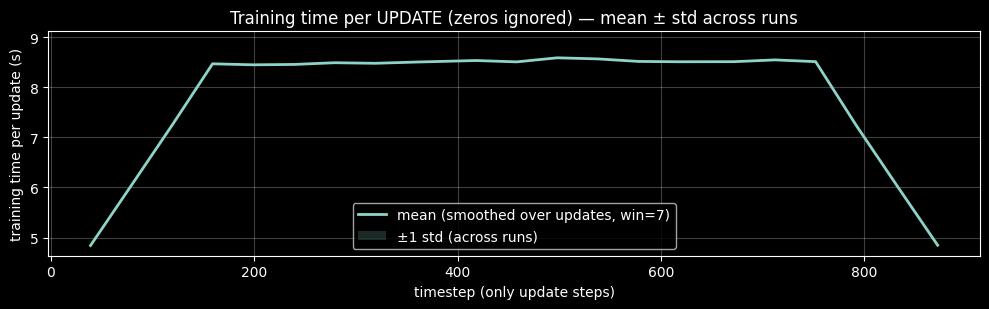

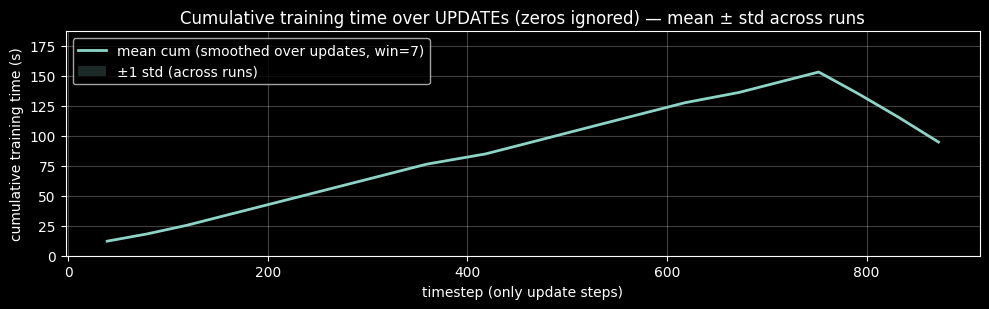

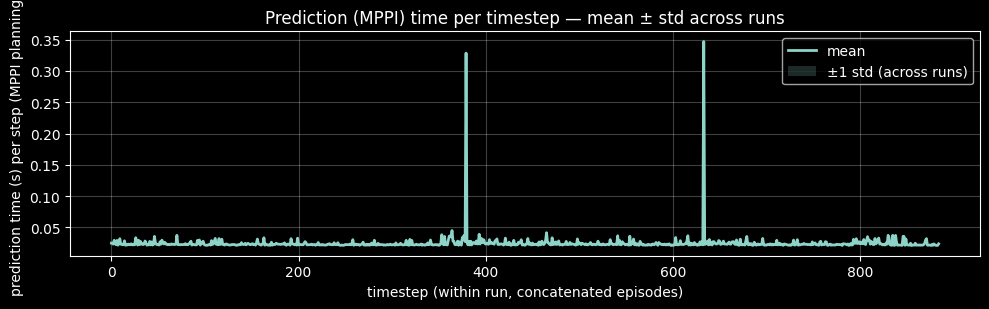

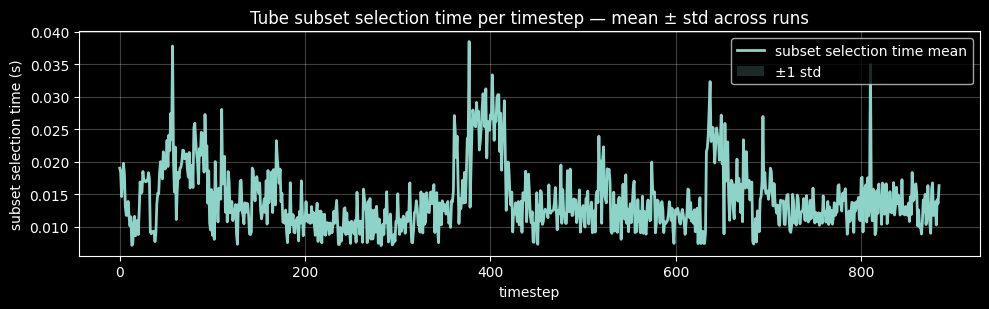

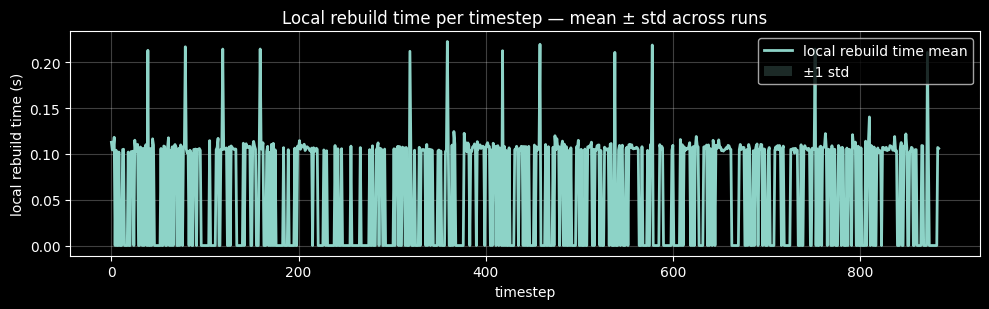

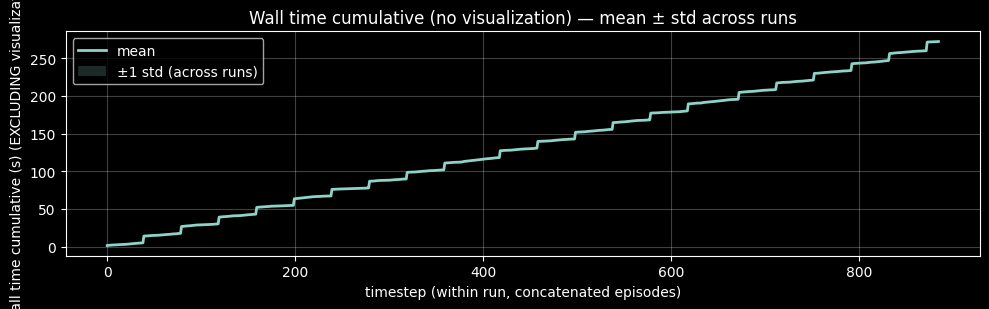

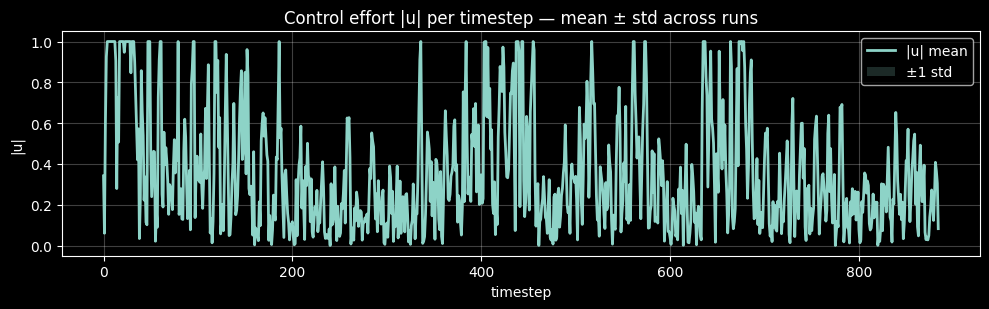

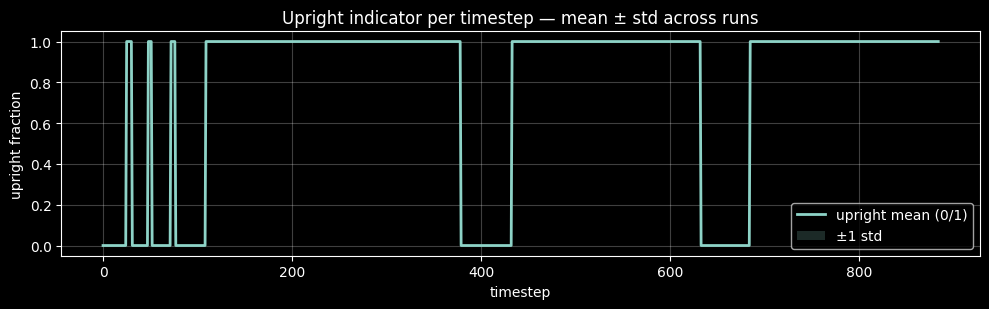

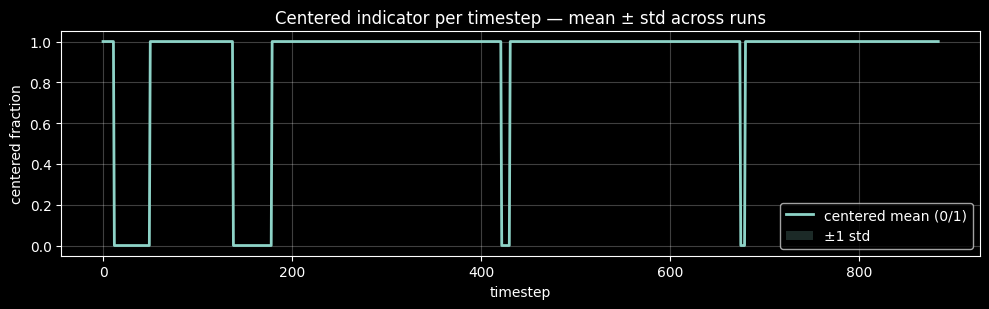

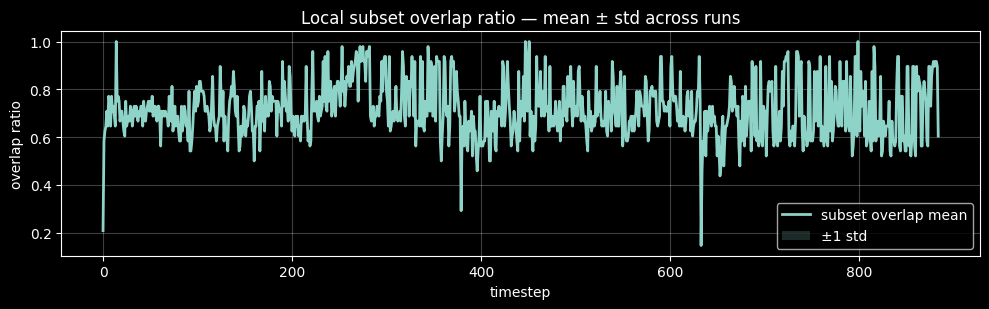

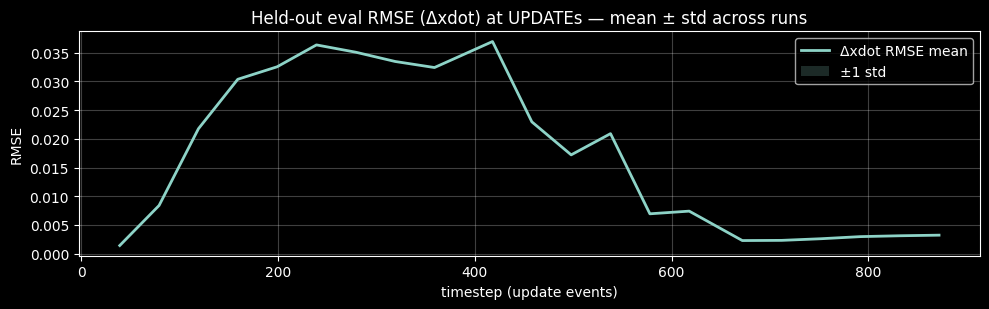

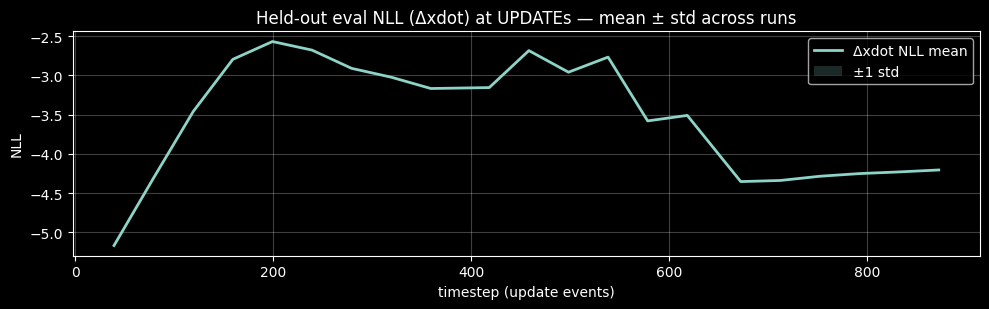

✅ Registered results into EVAL_REGISTRY under key: PALSGP_OSGPR_fixedZglobal_localSubset
Current methods in registry: ['PALSGP_OSGPR_fixedZglobal_localSubset']

==================== SUMMARY ====================
RUN 1: total_steps=885, total_reward_sum=586.323, updates_sum=21, success=True, tts=379
SUCCESS RATE: 100.0%   MEAN TTS: 379.0



In [7]:
# ===========================
# Cell 6 — MPPI + Online OSGPR (FIXED global inducing) + Local subset (PALSGP-style)
#   ✅ SAME PIPELINE as before, but FIXES “run 2 becomes super slow”:
#      - NO tf.function re-tracing when local subset changes
#      - We keep ONE compiled predictor module per head and only update its tensors
#
#   🔧 UPDATED (EVALUATION ONLY; control/model logic unchanged):
#      - Adds fair, method-agnostic metrics: success/time-to-success, control effort, state quality
#      - Adds timing breakdown: MPPI pred, subset selection, local rebuild, train/update
#      - Adds held-out eval set (RMSE + NLL per head) measured at UPDATE steps
#      - Standardizes EVAL_REGISTRY payload so all methods can overlay cleanly in one plot
#      - Keeps all existing behavior, constants, and training/planning logic intact
# ===========================

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
import plotly.graph_objects as go
import gpflow
import tensorflow as tf
from scipy.stats import chi2
from gpflow.utilities import parameter_dict, multiple_assign

# ----------------------------
# Enforce float64 (per your pipeline going forward)
# ----------------------------
try:
    gpflow.config.set_default_float(np.float64)
except Exception:
    pass
DTYPE_TF = gpflow.default_float()
assert DTYPE_TF == tf.float64, f"Expected float64 default, got {DTYPE_TF}. Set gpflow default float to float64 in earlier cells."

# ----------------------------
# GPU sanity / enforcement
# ----------------------------
REQUIRE_GPU = True
LOG_DEVICE_PLACEMENT = False

print("TF built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs visible:", tf.config.list_physical_devices("GPU"))
print("Logical GPUs:", tf.config.list_logical_devices("GPU"))

if LOG_DEVICE_PLACEMENT:
    tf.debugging.set_log_device_placement(True)

if REQUIRE_GPU:
    gpus = tf.config.list_physical_devices("GPU")
    if len(gpus) == 0:
        raise RuntimeError("REQUIRE_GPU=True but no GPU is visible to TensorFlow. Fix CUDA/TF install or set REQUIRE_GPU=False.")

# ----------------------------
# Config (UNCHANGED behavior)
# ----------------------------
HORIZON    = 40
K_SAMPLES  = 128
SIGMA      = 0.6
LAMBDA     = 1.0

UPDATE_EVERY = 40
ITERS_UPDATE = 100
LR_UPDATE    = 0.02
NOISE_UPDATE = 1e-4

M_GLOBAL = 256

M_SUB           = 48
DIVERSITY_FRAC  = 0.35

ANCHOR_M   = 12
ANCHOR_LAM = 1e-6

X_BAND      = 0.60
UPRIGHT_COS = 0.85
HOLD_STEPS  = 200

# Recording (visualization; excluded from runtime)
RECORD_RGB_DEFAULT   = True
RESIZE       = (720, 450)
FPS          = 10
FRAME_STRIDE = 2

# Exploration schedule
EXPLORE_STEPS = 1
UNC_W_MAX     = 15.0
UNC_W_MIN     = 0.0
CENTER_W      = 1.0
U_W           = 0.005
UPRIGHT_W     = 2.0

if "U_MIN" not in globals(): U_MIN = -1.0
if "U_MAX" not in globals(): U_MAX = +1.0

PLOT_EACH_UPDATE = False

LOCAL_REBUILD_EVERY   = 10
LOCAL_OVERLAP_THRESH  = 0.70

TUBE_ALPHA      = 0.99
TUBE_COV_EPS    = 1e-6
TUBE_TIME_BINS  = 16
TUBE_FALLBACK_CANDIDATES = 400

STD_CMIN_FIXED = 0.0
STD_FIXED_Q    = 0.5
STD_MODE       = "fixed"
STD_CMAX_FIXED = None

PLOT_X_MIN, PLOT_X_MAX = -2.4, 2.4
PLOT_V_MIN, PLOT_V_MAX = -3.0, 3.0
PLOT_N_GRID            = 60
PLOT_TH_FIXED          = 0.0
PLOT_THDOT_FIXED       = 0.0
PLOT_U_FIXED           = +1.0

STORE_GLOBAL_SURFACES = True
GLOBAL_SURF_HISTORY = []   # reset per RUN

# ============================================================
# NEW (EVAL ONLY): Held-out evaluation dataset config
# ============================================================
EVAL_SET_SIZE = 1024            # number of eval transitions per RUN
EVAL_WARMUP_STEPS = 64          # short random rollout length; enough to get diverse states
EVAL_U_STD = 0.7                # random policy std (clipped to [U_MIN, U_MAX])
EVAL_SEED_OFFSET = 424242       # deterministic per run

# ----------------------------
# NEW: Cross-method registry for unified evaluation plots
# ----------------------------
if "EVAL_REGISTRY" not in globals():
    EVAL_REGISTRY = {}   # method_name -> dict(curves...)

def register_method_results(method_name, payload):
    EVAL_REGISTRY[str(method_name)] = payload

# ============================================================
# UPDATED (EVAL ONLY): robust overlay plotter for standardized payloads
# ============================================================
def plot_compare_across_methods(
    keys=("pred_time_mean","wall_cum_mean","train_update_mean","eval_rmse_dxdot_mean"),
    title_prefix="COMPARE"
):
    if len(EVAL_REGISTRY) == 0:
        print("⚠️ EVAL_REGISTRY is empty; run at least one method cell first.")
        return

    def _get_axis(d, key):
        # Per-step
        if key.endswith("_mean") and ("t_axis" in d):
            return d["t_axis"]
        # Per-update
        if ("upd_t" in d) and (("train_update" in key) or ("eval_" in key) or ("loss_" in key)):
            return d["upd_t"]
        return None

    for key in keys:
        plt.figure(figsize=(10, 3.2))
        for name, d in EVAL_REGISTRY.items():
            if key not in d:
                continue
            t = _get_axis(d, key)
            y = d[key]
            if t is None:
                continue
            T = min(len(t), len(y))
            if T <= 0:
                continue
            plt.plot(t[:T], y[:T], label=name)
        plt.xlabel("timestep" if "t_axis" in next(iter(EVAL_REGISTRY.values()), {}) else "index")
        plt.ylabel(key)
        plt.title(f"{title_prefix}: {key}")
        plt.grid(True, alpha=0.25)
        plt.legend()
        plt.tight_layout()
        plt.show()

# ----------------------------
# Safety: require dependencies from earlier cells
# ----------------------------
required = [
    "make_env", "obs_to_state", "wrap_pi", "state_to_features",
    "batch_state_to_features", "OSGPR_VFE", "train_osgpr",
    "extract_summary_from_model", "greedy_dopt_anchors_from_K",
    "clone_kernel",
]
missing = [k for k in required if k not in globals()]
if len(missing) > 0:
    raise NameError(f"Cell 6 missing required symbols from earlier cells: {missing}")

if "render_cartpole_frame_from_state" not in globals():
    print("⚠️ render_cartpole_frame_from_state not found. RGB recording will be disabled.")
    RECORD_RGB_DEFAULT = False

# ----------------------------
# Helper: sym_jitter
# ----------------------------
def sym_jitter(A, jitter=1e-6):
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    return A + float(jitter) * np.eye(A.shape[0], dtype=np.float64)

# ----------------------------
# Precompute a fixed plot grid (same for all updates)
# ----------------------------
def build_fixed_plot_grid():
    xg = np.linspace(PLOT_X_MIN, PLOT_X_MAX, PLOT_N_GRID)
    vg = np.linspace(PLOT_V_MIN, PLOT_V_MAX, PLOT_N_GRID)
    X, V = np.meshgrid(xg, vg)

    Xfeat_grid = np.vstack([
        state_to_features(x, xdot, PLOT_TH_FIXED, PLOT_THDOT_FIXED, PLOT_U_FIXED)
        for x, xdot in zip(X.ravel(), V.ravel())
    ]).astype(np.float64)
    return X, V, Xfeat_grid

PLOT_XMESH, PLOT_VMESH, PLOT_XFEAT_GRID = build_fixed_plot_grid()

# ----------------------------
# Global predict helpers (mean/std)
# ----------------------------
def gp_predict_mu_std_fast(model, X):
    X = np.asarray(X, dtype=np.float64)
    if hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(X, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(X, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mu, std

def update_unified_std_scale(std_list, q=0.99, mode="fixed"):
    global STD_CMAX_FIXED
    all_std = np.concatenate([np.asarray(s, dtype=np.float64).reshape(-1) for s in std_list if s is not None], axis=0)
    if all_std.size == 0:
        if STD_CMAX_FIXED is None:
            STD_CMAX_FIXED = 1.0
        return (STD_CMIN_FIXED, STD_CMAX_FIXED)

    cand = float(np.quantile(all_std, q))
    cand = max(cand, 1e-8)

    if STD_CMAX_FIXED is None:
        STD_CMAX_FIXED = cand
    elif mode == "grow_only":
        STD_CMAX_FIXED = max(STD_CMAX_FIXED, cand)

    return (STD_CMIN_FIXED, STD_CMAX_FIXED)

# ============================================================
# CLEAN multi-head Z_GLOBAL refit (unchanged behavior)
# ============================================================
def refit_Z_global_multihead(Z_global, Xnew, M_global, lam=1e-6, mode="mean", normalize_traces=False):
    Z_global = np.asarray(Z_global, dtype=np.float64)
    Xnew = np.asarray(Xnew, dtype=np.float64)

    Z_cand = np.vstack([Z_global, Xnew]).astype(np.float64, copy=False)
    Zc_tf = tf.convert_to_tensor(Z_cand, dtype=tf.float64)

    K_dx     = m_dx.kernel.K(Zc_tf).numpy().astype(np.float64, copy=False)
    K_dxdot  = m_dxdot.kernel.K(Zc_tf).numpy().astype(np.float64, copy=False)
    K_dth    = m_dth.kernel.K(Zc_tf).numpy().astype(np.float64, copy=False)
    K_dthdot = m_dthdot.kernel.K(Zc_tf).numpy().astype(np.float64, copy=False)

    if normalize_traces:
        def _norm(K):
            tr = float(np.trace(K))
            return K / max(tr, 1e-12)
        K_dx, K_dxdot, K_dth, K_dthdot = map(_norm, [K_dx, K_dxdot, K_dth, K_dthdot])

    if mode == "sum":
        K_agg = (K_dx + K_dxdot + K_dth + K_dthdot)
    else:
        K_agg = (K_dx + K_dxdot + K_dth + K_dthdot) / 4.0

    idxZ = greedy_dopt_anchors_from_K(K_agg, m_anchors=int(M_global), lam=float(lam))
    Z_new = np.asarray(Z_cand[np.asarray(idxZ, dtype=np.int64)], dtype=np.float64)

    if Z_new.shape[0] != int(M_global):
        Z_new = Z_new[:int(M_global)].copy()
    return Z_new

# ----------------------------
# Online OSGPR update (unchanged behavior)
# ----------------------------
def osgpr_stream_update(model_old, X_new, Y_new, Z_new,
                        iters=100, lr=0.02, noise=1e-4,
                        freeze_kernel=False, clip_norm=10.0):
    X_new = np.asarray(X_new, dtype=np.float64)
    Y_new = np.asarray(Y_new, dtype=np.float64).reshape(-1, 1)

    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)
    Z_new = np.asarray(Z_new, dtype=np.float64)

    k_new = clone_kernel(model_old.kernel)

    m = OSGPR_VFE(
        data=(X_new, Y_new),
        kernel=k_new,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_new
    )
    m.likelihood.variance.assign(float(noise))

    if freeze_kernel:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass

    t_train, last_loss = train_osgpr(m, iters=iters, lr=lr, clip_norm=clip_norm)
    m.build_predict_cache()

    info = dict(
        train_seconds=float(t_train),
        last_neg_objective=float(last_loss),
        M_new=int(m.inducing_variable.num_inducing),
    )
    return m, info

# ============================================================
# Anchors via aggregated kernel on Z_GLOBAL (unchanged behavior)
# ============================================================
def compute_anchor_idx_dopt_from_Zglobal_multihead(Z_global, m_anchors=18, lam=1e-6, normalize_traces=True):
    Z = np.asarray(Z_global, dtype=np.float64)
    Ztf = tf.convert_to_tensor(Z, dtype=tf.float64)

    K_dx     = m_dx.kernel.K(Ztf).numpy().astype(np.float64, copy=False)
    K_dxdot  = m_dxdot.kernel.K(Ztf).numpy().astype(np.float64, copy=False)
    K_dth    = m_dth.kernel.K(Ztf).numpy().astype(np.float64, copy=False)
    K_dthdot = m_dthdot.kernel.K(Ztf).numpy().astype(np.float64, copy=False)

    if normalize_traces:
        def _norm(K):
            tr = float(np.trace(K))
            return K / max(tr, 1e-12)
        K_dx, K_dxdot, K_dth, K_dthdot = map(_norm, [K_dx, K_dxdot, K_dth, K_dthdot])

    K_agg = (K_dx + K_dxdot + K_dth + K_dthdot) / 4.0
    return greedy_dopt_anchors_from_K(K_agg, m_anchors=int(m_anchors), lam=float(lam))

# ============================================================
# Chi-square Mahalanobis tube selection (unchanged behavior)
# ============================================================
def normalize_nonnegative_weights(w, eps=1e-12):
    w = np.asarray(w, dtype=np.float64).reshape(-1)
    w = np.maximum(w, 0.0)
    s = float(np.sum(w))
    if s < eps:
        return np.ones_like(w) / max(len(w), 1)
    return w / s

def compute_weighted_moments(rollout_inputs, rollout_weights):
    X = np.asarray(rollout_inputs, dtype=np.float64)  # (K,H,D)
    K, H, D = X.shape
    w = normalize_nonnegative_weights(rollout_weights).reshape(K, 1, 1)
    tube_mean = np.sum(w * X, axis=0)  # (H,D)
    Xc = X - tube_mean[None, :, :]
    tube_cov = np.einsum("khd,khe->hde", (w * Xc), Xc)  # (H,D,D)
    return tube_mean, tube_cov

def min_mahalanobis_and_argmin(points_Z, tube_mean, tube_cov, cov_eps=1e-6):
    Z = np.asarray(points_Z, dtype=np.float64)
    mu = np.asarray(tube_mean, dtype=np.float64)
    Sig = np.asarray(tube_cov, dtype=np.float64)

    M, D = Z.shape
    H = mu.shape[0]
    I = np.eye(D, dtype=np.float64)

    dmin = np.full((M,), np.inf, dtype=np.float64)
    tmin = np.zeros((M,), dtype=np.int64)

    for t in range(H):
        St = Sig[t] + float(cov_eps) * I
        L = np.linalg.cholesky(St)

        diff = (Z - mu[t:t+1, :]).T  # (D,M)
        y = np.linalg.solve(L, diff)
        y2 = np.linalg.solve(L.T, y)
        quad = np.sum(diff * y2, axis=0)  # (M,)

        mask = quad < dmin
        dmin[mask] = quad[mask]
        tmin[mask] = t

    return dmin, tmin

def split_even_quota(total, num_bins):
    num_bins = int(max(1, num_bins))
    base = total // num_bins
    rem = total - base * num_bins
    q = np.full((num_bins,), base, dtype=np.int64)
    if rem > 0:
        q[:rem] += 1
    return q

def chi2_radius_sq(alpha, D):
    alpha = float(alpha)
    D = int(D)
    alpha = min(max(alpha, 1e-6), 1.0 - 1e-12)
    return float(chi2.ppf(alpha, df=D))

def greedy_dopt_select_from_kernel(K, k, jitter=1e-6, log_eps=1e-300):
    K = np.asarray(K, dtype=np.float64)
    n = K.shape[0]
    k = int(min(k, n))
    if k <= 0:
        return np.zeros((0,), dtype=np.int64)

    diag = np.diag(K).copy() + float(jitter)
    chosen = []
    Lchol = None

    for t in range(k):
        if t == 0:
            safe = np.maximum(diag, log_eps)
            i = int(np.argmax(np.log(safe)))
            chosen.append(i)
            Lchol = np.sqrt(max(diag[i], log_eps)).reshape(1, 1)
            continue

        S = np.array(chosen, dtype=np.int64)
        K_S = K[:, S]
        v = np.linalg.solve(Lchol, K_S.T)
        sq = np.sum(v * v, axis=0)
        schur = diag - sq

        schur[S] = -np.inf
        schur_pos = np.maximum(schur, log_eps)
        scores = np.log(schur_pos)
        scores[S] = -np.inf

        i = int(np.argmax(scores))
        chosen.append(i)

        k_iS = K[i, S].reshape(1, -1)
        w = np.linalg.solve(Lchol, k_iS.T)
        alpha2 = diag[i] - float(np.sum(w * w))
        alpha2 = max(alpha2, log_eps)
        alpha = np.sqrt(alpha2)

        Lnew = np.zeros((t + 1, t + 1), dtype=np.float64)
        Lnew[:t, :t] = Lchol
        Lnew[t, :t] = w.reshape(-1)
        Lnew[t, t] = alpha
        Lchol = Lnew

    return np.array(chosen, dtype=np.int64)

def select_tube_subset(
    Z_global,
    kernel_for_dopt,
    rollout_inputs,
    rollout_weights,
    total_subset_size=64,
    anchor_idx=None,
    time_bins=16,
    cov_eps=1e-6,
    dopt_jitter=1e-6,
    fallback_candidates=400,
    alpha=0.99,
):
    Zg = np.asarray(Z_global, dtype=np.float64)
    M = Zg.shape[0]

    if anchor_idx is None:
        anchor_idx = np.zeros((0,), dtype=np.int64)
    anchor_idx = np.unique(np.asarray(anchor_idx, dtype=np.int64))
    anchor_idx = anchor_idx[(anchor_idx >= 0) & (anchor_idx < M)]

    tube_mean, tube_cov = compute_weighted_moments(rollout_inputs, rollout_weights)
    H, D = tube_mean.shape

    chi2_thr = chi2_radius_sq(alpha, D)

    dmin, tmin = min_mahalanobis_and_argmin(Zg, tube_mean, tube_cov, cov_eps=cov_eps)
    tube_candidates_idx = np.where(dmin <= chi2_thr)[0].astype(np.int64)

    remaining_budget = int(total_subset_size - anchor_idx.size)
    remaining_budget = max(0, remaining_budget)

    if tube_candidates_idx.size < remaining_budget:
        L = int(min(max(fallback_candidates, remaining_budget), M))
        tube_candidates_idx = np.argsort(dmin)[:L].astype(np.int64)

    tube_pool = tube_candidates_idx[~np.isin(tube_candidates_idx, anchor_idx)]
    tmin_pool = tmin[tube_pool]

    selected = set(int(i) for i in anchor_idx)

    if remaining_budget > 0 and tube_pool.size > 0:
        B = int(max(1, min(time_bins, H)))
        edges = np.linspace(0, H, B + 1, dtype=np.int64)
        quotas = split_even_quota(remaining_budget, B)

        for b in range(B):
            if len(selected) >= total_subset_size:
                break

            a, c = int(edges[b]), int(edges[b + 1])
            if c <= a:
                continue

            in_bin = (tmin_pool >= a) & (tmin_pool < c)
            bin_pool = tube_pool[in_bin]
            if bin_pool.size == 0:
                continue

            k_b = int(min(quotas[b], bin_pool.size, total_subset_size - len(selected)))
            if k_b <= 0:
                continue

            Zb = Zg[bin_pool]
            Kb = kernel_for_dopt.K(tf.convert_to_tensor(Zb, dtype=tf.float64)).numpy().astype(np.float64)
            pick = greedy_dopt_select_from_kernel(Kb, k=k_b, jitter=dopt_jitter)

            for gidx in bin_pool[pick]:
                selected.add(int(gidx))

    if len(selected) < total_subset_size:
        need = int(total_subset_size - len(selected))
        leftover = tube_pool[~np.isin(tube_pool, np.array(list(selected), dtype=np.int64))]
        if leftover.size > 0 and need > 0:
            Zl = Zg[leftover]
            Kl = kernel_for_dopt.K(tf.convert_to_tensor(Zl, dtype=tf.float64)).numpy().astype(np.float64)
            pick = greedy_dopt_select_from_kernel(Kl, k=min(need, leftover.size), jitter=dopt_jitter)
            for gidx in leftover[pick]:
                selected.add(int(gidx))

    if len(selected) < total_subset_size:
        need = int(total_subset_size - len(selected))
        remaining = np.setdiff1d(np.arange(M, dtype=np.int64), np.array(list(selected), dtype=np.int64), assume_unique=False)
        if remaining.size > 0:
            order = remaining[np.argsort(dmin[remaining])]
            for gidx in order[:need]:
                selected.add(int(gidx))

    subset_idx = np.array(sorted(selected), dtype=np.int64)[:total_subset_size]
    return subset_idx, tube_mean, tube_cov, tube_candidates_idx, chi2_thr

# ============================================================
# TF local predictor pack (NO RETRACING)
# ============================================================
@tf.function
def wrap_pi_tf(theta):
    two_pi = tf.constant(2.0 * np.pi, dtype=DTYPE_TF)
    pi = tf.constant(np.pi, dtype=DTYPE_TF)
    return tf.math.floormod(theta + pi, two_pi) - pi

@tf.function
def batch_state_to_features_tf(S, U):
    x = S[:, 0]
    xdot = S[:, 1]
    th = S[:, 2]
    thdot = S[:, 3]
    f0 = tf.tanh(x / tf.constant(2.4, dtype=DTYPE_TF))
    f1 = tf.tanh(xdot / tf.constant(3.0, dtype=DTYPE_TF))
    f2 = tf.sin(th)
    f3 = tf.cos(th)
    f4 = tf.tanh(thdot / tf.constant(8.0, dtype=DTYPE_TF))
    f5 = U
    return tf.stack([f0, f1, f2, f3, f4, f5], axis=1)

@tf.function
def se_ard_kernel_Kzx_tf(Z, X, lengthscales, variance):
    ls = tf.reshape(lengthscales, (1, -1))
    var = tf.cast(variance, DTYPE_TF)
    Zs = Z / ls
    Xs = X / ls
    z2 = tf.reduce_sum(Zs * Zs, axis=1, keepdims=True)
    x2 = tf.reduce_sum(Xs * Xs, axis=1, keepdims=True)
    zx = tf.matmul(Zs, Xs, transpose_b=True)
    r2 = tf.maximum(z2 + tf.transpose(x2) - 2.0 * zx, 0.0)
    return var * tf.exp(-0.5 * r2)

class LocalSubsetPredictor(tf.Module):
    def __init__(self, Dfeat, Msub, name=None):
        super().__init__(name=name)
        self.Dfeat = int(Dfeat)
        self.Msub  = int(Msub)

        # IMPORTANT: fixed shapes = (M_SUB, ·) so assign() never shape-mismatches
        self.Z     = tf.Variable(tf.zeros([self.Msub, self.Dfeat], dtype=tf.float64), trainable=False)
        self.L     = tf.Variable(tf.eye(self.Msub, dtype=tf.float64), trainable=False)
        self.alpha = tf.Variable(tf.zeros([self.Msub, 1], dtype=tf.float64), trainable=False)
        self.S     = tf.Variable(tf.eye(self.Msub, dtype=tf.float64), trainable=False)

        self.ls    = tf.Variable(tf.ones([self.Dfeat], dtype=tf.float64), trainable=False)
        self.var   = tf.Variable(1.0, dtype=tf.float64, trainable=False)

    def assign_pack(self, Z, L, alpha, S, ls, var):
        # All of these must be exactly M_SUB-sized
        self.Z.assign(tf.cast(Z, tf.float64))
        self.L.assign(tf.cast(L, tf.float64))
        self.alpha.assign(tf.cast(alpha, tf.float64))
        self.S.assign(tf.cast(S, tf.float64))
        self.ls.assign(tf.cast(ls, tf.float64))
        self.var.assign(tf.cast(var, tf.float64))

    @tf.function(reduce_retracing=True)
    def predict_mu_var(self, Xfeat):
        Xfeat = tf.cast(Xfeat, tf.float64)
        Kzx = se_ard_kernel_Kzx_tf(self.Z, Xfeat, self.ls, self.var)  # (M,N)

        w1 = tf.linalg.triangular_solve(self.L, Kzx, lower=True)
        W  = tf.linalg.triangular_solve(tf.transpose(self.L), w1, lower=False)

        mu = tf.reshape(tf.matmul(Kzx, self.alpha, transpose_a=True), (-1,))

        kxx = tf.fill((tf.shape(Xfeat)[0],), tf.cast(self.var, tf.float64))
        Qdiag = tf.reduce_sum(Kzx * W, axis=0)
        SW = tf.matmul(self.S, W)
        Sdiag = tf.reduce_sum(W * SW, axis=0)

        v = tf.maximum(kxx - Qdiag + Sdiag, tf.cast(1e-12, tf.float64))
        return mu, v


def build_local_pack_from_global_tf(model_global, Z_global, idx_sub):
    idx_sub = np.asarray(idx_sub, dtype=np.int64)
    Zg = np.asarray(Z_global, dtype=np.float64)
    Z  = Zg[idx_sub].copy()

    Ztf = tf.convert_to_tensor(Z, dtype=tf.float64)
    muZ, SigZ = model_global.predict_f(Ztf, full_cov=True)
    m = muZ
    S = SigZ
    if len(S.shape) == 3:
        S = S[0]

    ls  = tf.cast(model_global.kernel.lengthscales, tf.float64)
    var = tf.cast(model_global.kernel.variance, tf.float64)

    Kzz = se_ard_kernel_Kzx_tf(Ztf, Ztf, ls, var)
    jitter = tf.cast(1e-6, tf.float64)
    Kzz = 0.5 * (Kzz + tf.transpose(Kzz)) + jitter * tf.eye(tf.shape(Kzz)[0], dtype=tf.float64)
    L = tf.linalg.cholesky(Kzz)

    y = tf.linalg.triangular_solve(L, m, lower=True)
    alpha = tf.linalg.triangular_solve(tf.transpose(L), y, lower=False)

    return (Ztf, L, alpha, S, tf.reshape(ls, (-1,)), var)

# ============================================================
# MPPI cost (unchanged behavior)
# ============================================================
@tf.function
def exploration_weight_tf(t):
    explore_steps_f = tf.cast(EXPLORE_STEPS, DTYPE_TF)
    t_f = tf.cast(t, DTYPE_TF)
    a = tf.clip_by_value(1.0 - t_f / tf.maximum(explore_steps_f, 1.0), 0.0, 1.0)
    return tf.cast(UNC_W_MIN, DTYPE_TF) + (tf.cast(UNC_W_MAX, DTYPE_TF) - tf.cast(UNC_W_MIN, DTYPE_TF)) * a

@tf.function
def stage_cost_cartpole_tf(S, U, x_init, unc_bonus=None, unc_w=0.0):
    th = S[:, 2]
    x  = S[:, 0]
    c = (
        tf.cast(UPRIGHT_W, DTYPE_TF) * (1.0 - tf.cos(th))
        + tf.cast(CENTER_W, DTYPE_TF) * tf.square(x - x_init)
        + tf.cast(U_W, DTYPE_TF) * tf.square(U)
    )
    if (unc_bonus is not None) and (unc_w > 0.0):
        c = c - tf.cast(unc_w, DTYPE_TF) * tf.cast(unc_bonus, DTYPE_TF)
    return c

@tf.function
def terminal_cost_hold_like_tf(S, x_init):
    th = S[:, 2]
    x  = S[:, 0]
    cT = tf.zeros_like(th)
    good = tf.logical_and(tf.cos(th) >= tf.cast(UPRIGHT_COS, DTYPE_TF),
                          tf.abs(x - x_init) <= tf.cast(X_BAND, DTYPE_TF))
    cT = tf.where(good, cT - tf.cast(5.0, DTYPE_TF), cT)
    return cT

# ============================================================
# Global-local dynamics: uses persistent predictors (NO RETRACING)
# ============================================================
@tf.function(reduce_retracing=True)
def gp_dynamics_step_batch_local_tf(S, U, local_dx, local_dxdot, local_dth, local_dthdot):
    Xfeat = batch_state_to_features_tf(S, U)

    dx, _     = local_dx.predict_mu_var(Xfeat)
    dxdot, _  = local_dxdot.predict_mu_var(Xfeat)
    dth, _    = local_dth.predict_mu_var(Xfeat)
    dthdot, _ = local_dthdot.predict_mu_var(Xfeat)

    S2 = tf.stack([
        S[:, 0] + dx,
        S[:, 1] + dxdot,
        wrap_pi_tf(S[:, 2] + dth),
        S[:, 3] + dthdot
    ], axis=1)
    return S2, Xfeat

@tf.function(reduce_retracing=True)
def rollout_tube_features_local_tf(state0, u_seq, local_dx, local_dxdot, local_dth, local_dthdot):
    H = tf.shape(u_seq)[0]
    s = tf.identity(state0)
    tube = tf.TensorArray(dtype=DTYPE_TF, size=H)

    t = tf.constant(0)
    def cond(t, s, tube): return t < H
    def body(t, s, tube):
        u = u_seq[t]
        xfeat = batch_state_to_features_tf(tf.expand_dims(s, axis=0), tf.expand_dims(u, axis=0))[0]
        tube = tube.write(t, xfeat)
        s2, _ = gp_dynamics_step_batch_local_tf(tf.expand_dims(s, axis=0), tf.expand_dims(u, axis=0),
                                               local_dx, local_dxdot, local_dth, local_dthdot)
        s = s2[0]
        return t+1, s, tube

    _, _, tube = tf.while_loop(cond, body, [t, s, tube], parallel_iterations=1)
    return tube.stack()

@tf.function(reduce_retracing=True)
def mppi_plan_gpu_local_tf(state0, x_init, u_mean0, t_global,
                           local_dx, local_dxdot, local_dth, local_dthdot,
                           horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
                           base_seed=0):
    H = tf.cast(horizon, tf.int32)
    Kt = tf.cast(K, tf.int32)

    seed = tf.stack([tf.cast(base_seed, tf.int32), tf.cast(t_global, tf.int32)], axis=0)
    eps = tf.random.stateless_normal((Kt, H), seed=seed, mean=0.0, stddev=tf.cast(sigma, DTYPE_TF), dtype=DTYPE_TF)
    U = tf.clip_by_value(u_mean0[None, :] + eps, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))

    S = tf.tile(state0[None, :], [Kt, 1])
    total_cost = tf.zeros((Kt,), dtype=DTYPE_TF)

    Xta = tf.TensorArray(dtype=DTYPE_TF, size=H)
    unc_w = exploration_weight_tf(t_global)

    t = tf.constant(0, dtype=tf.int32)
    def cond(t, S, total_cost, Xta): return t < H
    def body(t, S, total_cost, Xta):
        Ut = U[:, t]
        S2, Xfeat = gp_dynamics_step_batch_local_tf(S, Ut, local_dx, local_dxdot, local_dth, local_dthdot)
        Xta = Xta.write(t, Xfeat)

        # uncertainty bonus uses dxdot variance (same as before)
        _, unc_v = local_dxdot.predict_mu_var(Xfeat)
        total_cost = total_cost + stage_cost_cartpole_tf(S, Ut, x_init=tf.cast(x_init, DTYPE_TF),
                                                         unc_bonus=unc_v, unc_w=unc_w)
        return t+1, S2, total_cost, Xta

    _, S, total_cost, Xta = tf.while_loop(cond, body, [t, S, total_cost, Xta], parallel_iterations=1)
    total_cost = total_cost + terminal_cost_hold_like_tf(S, x_init=tf.cast(x_init, DTYPE_TF))

    cmin = tf.reduce_min(total_cost)
    w = tf.exp(-(total_cost - cmin) / tf.cast(lam, DTYPE_TF))
    wsum = tf.reduce_sum(w) + tf.cast(1e-12, DTYPE_TF)

    u_mean = u_mean0 + tf.reduce_sum(w[:, None] * eps, axis=0) / wsum
    u_mean = tf.clip_by_value(u_mean, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))

    tubeX = rollout_tube_features_local_tf(state0, u_mean, local_dx, local_dxdot, local_dth, local_dthdot)
    XHKD = Xta.stack()
    Xroll = tf.transpose(XHKD, perm=[1, 0, 2])
    return u_mean[0], u_mean, tubeX, unc_w, Xroll, w

def mppi_plan_gpu_local(state, x_init, u_init, t_global,
                        local_dx, local_dxdot, local_dth, local_dthdot,
                        base_seed=0):
    state0 = tf.convert_to_tensor(np.asarray(state, dtype=np.float64).reshape(4,), dtype=DTYPE_TF)
    x0     = tf.convert_to_tensor(float(x_init), dtype=DTYPE_TF)
    u0     = tf.convert_to_tensor(np.asarray(u_init, dtype=np.float64).reshape(-1,), dtype=DTYPE_TF)

    dev = "/GPU:0" if len(tf.config.list_logical_devices("GPU")) > 0 else "/CPU:0"
    if REQUIRE_GPU: dev = "/GPU:0"

    with tf.device(dev):
        u_first, u_mean, tubeX, unc_w, Xroll, w = mppi_plan_gpu_local_tf(
            state0, x0, u0, tf.convert_to_tensor(int(t_global), dtype=tf.int32),
            local_dx, local_dxdot, local_dth, local_dthdot,
            horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
            base_seed=int(base_seed)
        )

    return float(u_first.numpy()), u_mean.numpy(), tubeX.numpy(), float(unc_w.numpy()), Xroll.numpy(), w.numpy()

# ----------------------------
# Visualization helpers
# ----------------------------
def plot_surface_global_dxdot(model_like,
                             title="Surface", std_clim=None,
                             Xmesh=PLOT_XMESH, Vmesh=PLOT_VMESH, Xfeat_grid=PLOT_XFEAT_GRID,
                             show_colorbar=True):
    mu, std = gp_predict_mu_std_fast(model_like, Xfeat_grid)
    Mean = mu.reshape(Xmesh.shape)
    Std  = std.reshape(Xmesh.shape)

    cmin = cmax = None
    if std_clim is not None:
        cmin, cmax = float(std_clim[0]), float(std_clim[1])

    surface = go.Surface(
        x=Xmesh, y=Vmesh, z=Mean,
        surfacecolor=Std,
        colorscale="Viridis",
        cmin=cmin, cmax=cmax,
        colorbar=(dict(title="Std") if show_colorbar else None),
        showscale=bool(show_colorbar),
        opacity=0.95,
        name="surface"
    )
    fig = go.Figure(data=[surface])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
            yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
            zaxis=dict(title="Δxdot"),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=620
    )
    fig.show()

def success_hold_update(state, x_init, hold_count):
    x, xdot, th, thdot = state
    upright = (np.cos(th) >= UPRIGHT_COS)
    centered = (abs(x - x_init) <= X_BAND)
    hold_count = (hold_count + 1) if (upright and centered) else 0
    success = (hold_count >= HOLD_STEPS)
    return hold_count, success, upright, centered

def display_run_animation_from_frames(frames, fps=FPS, resize=RESIZE):
    if frames is None or len(frames) == 0:
        print("⚠️ No frames captured for this run.")
        return None

    fig = plt.figure(figsize=(resize[0]/100, resize[1]/100), dpi=100)
    plt.axis("off")
    im = plt.imshow(frames[0])

    def animate_fn(i):
        im.set_data(frames[i])
        return [im]

    ani = animation.FuncAnimation(
        fig, animate_fn,
        frames=len(frames),
        interval=1000 / float(fps),
        blit=True
    )
    plt.close(fig)
    html = HTML(ani.to_jshtml())
    display(html)
    return html

# ============================================================
# NEW (EVAL ONLY): Held-out eval set builder + metrics
# ============================================================
def build_eval_set_for_run(seed, max_steps=EVAL_WARMUP_STEPS, n_eval=EVAL_SET_SIZE, start_down=True):
    """
    Creates a held-out evaluation set (X_eval, Y_eval_*) using a short random policy rollout.
    Not used for training. Deterministic given seed.
    """
    env = make_env(render_mode=None, seed=seed, max_episode_steps=max_steps, start_down=start_down)
    obs, info = env.reset(seed=seed)
    s = np.array(obs_to_state(obs), dtype=np.float64)

    X_list = []
    ydx_list, ydxdot_list, ydth_list, ydthdot_list = [], [], [], []

    rng = np.random.RandomState(seed)
    for t in range(max_steps):
        u = float(np.clip(rng.randn() * EVAL_U_STD, U_MIN, U_MAX))
        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        s2 = np.array(obs_to_state(obs2), dtype=np.float64)

        respawned = bool(isinstance(info, dict) and info.get("respawned", False))
        if not respawned:
            X_list.append(state_to_features(s[0], s[1], s[2], s[3], u))
            ydx_list.append([s2[0] - s[0]])
            ydxdot_list.append([s2[1] - s[1]])
            ydth_list.append([wrap_pi(s2[2] - s[2])])
            ydthdot_list.append([s2[3] - s[3]])

        s = s2
        if terminated or truncated:
            break

    env.close()

    if len(X_list) == 0:
        # Fallback to a tiny dummy set to avoid crashes; should basically never happen
        X = np.zeros((1, int(PLOT_XFEAT_GRID.shape[1])), dtype=np.float64)
        ydx = ydxdot = ydth = ydthdot = np.zeros((1, 1), dtype=np.float64)
        return X, ydx, ydxdot, ydth, ydthdot

    X = np.asarray(X_list, dtype=np.float64)
    ydx = np.asarray(ydx_list, dtype=np.float64)
    ydxdot = np.asarray(ydxdot_list, dtype=np.float64)
    ydth = np.asarray(ydth_list, dtype=np.float64)
    ydthdot = np.asarray(ydthdot_list, dtype=np.float64)

    # Subsample (deterministic) to n_eval
    if X.shape[0] > int(n_eval):
        idx = rng.choice(X.shape[0], size=int(n_eval), replace=False)
        X, ydx, ydxdot, ydth, ydthdot = X[idx], ydx[idx], ydxdot[idx], ydth[idx], ydthdot[idx]

    return X, ydx, ydxdot, ydth, ydthdot

def eval_rmse_nll(model, X_eval, Y_eval):
    """
    Returns (rmse, nll) for 1D GP predictions.
    nll uses Gaussian predictive with variance; robust to tiny var.
    """
    X_eval = np.asarray(X_eval, dtype=np.float64)
    Y_eval = np.asarray(Y_eval, dtype=np.float64).reshape(-1)

    if hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(X_eval, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(X_eval, full_cov=False)

    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    var = np.maximum(var, 1e-12)

    rmse = float(np.sqrt(np.mean((mu - Y_eval) ** 2)))
    nll = float(0.5 * np.mean(np.log(2.0 * np.pi * var) + ((Y_eval - mu) ** 2) / var))
    return rmse, nll

# ============================================================
# Single EPISODE runner
# ============================================================
def run_one_episode_mppi_retrain_rgb_with_eval(
    max_steps=600, seed=0, start_down=True, verbose=True,
    use_gpu_mppi=True,
    warmup_mppi=True,
    record_rgb=True,
    t_offset_in_run=0,
    return_frames=False,
    # NEW (EVAL ONLY):
    eval_set=None,              # tuple(Xe, ydx, ydxdot, ydth, ydthdot) or None
    update_log_lists=None,      # dict of lists to append per update (shared across episodes in a run)
):
    global m_dx, m_dxdot, m_dth, m_dthdot
    global Z_GLOBAL
    global STD_CMAX_FIXED

    env = make_env(render_mode=None, seed=seed, max_episode_steps=max_steps, start_down=start_down)
    obs, info = env.reset(seed=seed)
    s = np.array(obs_to_state(obs), dtype=np.float64)
    x_init = float(s[0])

    # Ensure Z_GLOBAL fixed size
    Z_GLOBAL = np.asarray(Z_GLOBAL, dtype=np.float64)
    if Z_GLOBAL.shape[0] != int(M_GLOBAL):
        if Z_GLOBAL.shape[0] > int(M_GLOBAL):
            Z_GLOBAL = Z_GLOBAL[:int(M_GLOBAL)].copy()
        else:
            raise ValueError(f"Z_GLOBAL has {Z_GLOBAL.shape[0]} points but M_GLOBAL={M_GLOBAL}.")

    # anchors
    ANCHOR_IDX = compute_anchor_idx_dopt_from_Zglobal_multihead(
        Z_GLOBAL, m_anchors=ANCHOR_M, lam=ANCHOR_LAM, normalize_traces=True
    )

    # init local subset
    u_mean = np.zeros((HORIZON,), dtype=np.float64)
    idx_sub = np.arange(min(M_SUB, M_GLOBAL), dtype=np.int64)

    # Persistent TF predictors per head (no retracing on rebuild)
    Dfeat = int(PLOT_XFEAT_GRID.shape[1])
    local_dx     = LocalSubsetPredictor(Dfeat, M_SUB, name="local_dx")
    local_dxdot  = LocalSubsetPredictor(Dfeat, M_SUB, name="local_dxdot")
    local_dth    = LocalSubsetPredictor(Dfeat, M_SUB, name="local_dth")
    local_dthdot = LocalSubsetPredictor(Dfeat, M_SUB, name="local_dthdot")

    def refresh_locals(idx_sub_np):
        Z,L,a,S,ls,var = build_local_pack_from_global_tf(m_dx,     Z_GLOBAL, idx_sub_np); local_dx.assign_pack(Z,L,a,S,ls,var)
        Z,L,a,S,ls,var = build_local_pack_from_global_tf(m_dxdot,  Z_GLOBAL, idx_sub_np); local_dxdot.assign_pack(Z,L,a,S,ls,var)
        Z,L,a,S,ls,var = build_local_pack_from_global_tf(m_dth,    Z_GLOBAL, idx_sub_np); local_dth.assign_pack(Z,L,a,S,ls,var)
        Z,L,a,S,ls,var = build_local_pack_from_global_tf(m_dthdot, Z_GLOBAL, idx_sub_np); local_dthdot.assign_pack(Z,L,a,S,ls,var)

    refresh_locals(idx_sub)

    last_idx_sub = np.array(idx_sub, dtype=np.int64)
    last_local_rebuild_t = 0

    # ============================================================
    # UPDATED (EVAL ONLY): richer per-step logs
    # ============================================================
    pred_time_step = np.zeros((max_steps,), dtype=np.float64)          # MPPI planning time
    subset_time_step = np.zeros((max_steps,), dtype=np.float64)        # select_tube_subset time
    local_rebuild_time_step = np.zeros((max_steps,), dtype=np.float64) # refresh_locals time (only when rebuild happens)
    train_time_step = np.zeros((max_steps,), dtype=np.float64)         # full update time (4 heads)
    wall_excl_vis_cum = np.zeros((max_steps,), dtype=np.float64)

    overlap_step = np.full((max_steps,), np.nan, dtype=np.float64)
    rebuilt_step = np.zeros((max_steps,), dtype=np.float64)

    u0_step = np.zeros((max_steps,), dtype=np.float64)
    u_abs_step = np.zeros((max_steps,), dtype=np.float64)
    u_sq_step = np.zeros((max_steps,), dtype=np.float64)

    x_step = np.zeros((max_steps,), dtype=np.float64)
    th_step = np.zeros((max_steps,), dtype=np.float64)
    upright_step = np.zeros((max_steps,), dtype=np.float64)
    centered_step = np.zeros((max_steps,), dtype=np.float64)
    hold_step = np.zeros((max_steps,), dtype=np.float64)
    uncw_step = np.zeros((max_steps,), dtype=np.float64)

    t_wall_start = time.perf_counter()
    vis_time_s = 0.0

    # warmup: compile once
    if use_gpu_mppi and warmup_mppi:
        _ = mppi_plan_gpu_local(
            state=s, x_init=x_init, u_init=u_mean, t_global=int(t_offset_in_run),
            local_dx=local_dx, local_dxdot=local_dxdot, local_dth=local_dth, local_dthdot=local_dthdot,
            base_seed=seed
        )

    frames = []
    total_reward = 0.0
    hold_count = 0
    updates = 0
    success_any = False
    time_to_success = None

    Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []
    last_rollout_inputs = None
    last_rollout_weights = None

    for t in range(max_steps):
        t_global = int(t_offset_in_run + t)

        # ---------- MPPI plan ----------
        t0 = time.perf_counter()
        if use_gpu_mppi:
            u0, u_mean, tubeX, unc_w, Xroll, wroll = mppi_plan_gpu_local(
                state=s, x_init=x_init, u_init=u_mean, t_global=t_global,
                local_dx=local_dx, local_dxdot=local_dxdot, local_dth=local_dth, local_dthdot=local_dthdot,
                base_seed=seed
            )
        else:
            raise RuntimeError("use_gpu_mppi=False path not wired in this multi-run cell (set use_gpu_mppi=True).")
        t1 = time.perf_counter()
        pred_time_step[t] = (t1 - t0)

        last_rollout_inputs = Xroll
        last_rollout_weights = wroll

        # ---------- tube subset selection (unchanged logic) ----------
        ts0 = time.perf_counter()
        idx_sub_cand, _, _, _, _ = select_tube_subset(
            Z_global=Z_GLOBAL,
            kernel_for_dopt=m_dxdot.kernel,
            rollout_inputs=last_rollout_inputs,
            rollout_weights=last_rollout_weights,
            total_subset_size=M_SUB,
            anchor_idx=ANCHOR_IDX,
            time_bins=TUBE_TIME_BINS,
            cov_eps=TUBE_COV_EPS,
            dopt_jitter=1e-6,
            fallback_candidates=TUBE_FALLBACK_CANDIDATES,
            alpha=TUBE_ALPHA,
        )
        ts1 = time.perf_counter()
        subset_time_step[t] = (ts1 - ts0)

        inter = np.intersect1d(last_idx_sub, idx_sub_cand)
        overlap = float(len(inter)) / float(len(idx_sub_cand)) if len(idx_sub_cand) > 0 else 1.0
        overlap_step[t] = overlap

        need_rebuild = ((t - last_local_rebuild_t) >= int(LOCAL_REBUILD_EVERY)) or (overlap < float(LOCAL_OVERLAP_THRESH))
        if need_rebuild:
            idx_sub = np.array(idx_sub_cand, dtype=np.int64)
            tr0 = time.perf_counter()
            refresh_locals(idx_sub)  # <<< IMPORTANT: no new tf.functions, just assign tensors
            tr1 = time.perf_counter()
            local_rebuild_time_step[t] = (tr1 - tr0)
            rebuilt_step[t] = 1.0

            last_idx_sub = np.array(idx_sub, dtype=np.int64)
            last_local_rebuild_t = int(t)
        else:
            idx_sub = last_idx_sub

        # ---------- env step ----------
        obs2, r, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
        s2 = np.array(obs_to_state(obs2), dtype=np.float64)
        total_reward += float(r)

        respawned = bool(isinstance(info, dict) and info.get("respawned", False))
        if not respawned:
            Xbuf.append(state_to_features(s[0], s[1], s[2], s[3], float(u0)))
            ydx_buf.append([s2[0] - s[0]])
            ydxdot_buf.append([s2[1] - s[1]])
            ydth_buf.append([wrap_pi(s2[2] - s[2])])
            ydthdot_buf.append([s2[3] - s[3]])

        # ---------- render (excluded from wall) ----------
        if record_rgb and RECORD_RGB_DEFAULT and (t % FRAME_STRIDE == 0):
            tv0 = time.perf_counter()
            W, Hh = int(RESIZE[0]), int(RESIZE[1])
            frame = render_cartpole_frame_from_state(x=s2[0], theta=s2[2], x_threshold=2.4, W=W, H=Hh)
            frames.append(frame)
            vis_time_s += (time.perf_counter() - tv0)

        # ---------- success tracking ----------
        hold_count, success, upright, centered = success_hold_update(s2, x_init, hold_count)
        if success and (not success_any):
            success_any = True
            time_to_success = int(t + 1)  # steps into this episode

        if verbose and (t % 50 == 0):
            print(f"[t_global={t_global:04d}] u0={u0:+.2f}  unc_w={unc_w:.2f}  upright={upright} centered={centered} hold={hold_count}/{HOLD_STEPS}")

        # ============================================================
        # UPDATED (EVAL ONLY): per-step logging (does not change behavior)
        # ============================================================
        u0_step[t] = float(u0)
        u_abs_step[t] = abs(float(u0))
        u_sq_step[t] = float(u0) * float(u0)

        x_step[t] = float(s2[0])
        th_step[t] = float(s2[2])
        upright_step[t] = 1.0 if upright else 0.0
        centered_step[t] = 1.0 if centered else 0.0
        hold_step[t] = float(hold_count)
        uncw_step[t] = float(unc_w)

        # ---------- UPDATE (global only, unchanged logic) ----------
        if ((t + 1) % UPDATE_EVERY == 0) and (len(Xbuf) >= 10):
            updates += 1

            Xnew  = np.asarray(Xbuf, dtype=np.float64)
            ydx   = np.asarray(ydx_buf, dtype=np.float64)
            ydxd  = np.asarray(ydxdot_buf, dtype=np.float64)
            ydth  = np.asarray(ydth_buf, dtype=np.float64)
            ydthd = np.asarray(ydthdot_buf, dtype=np.float64)

            # refit Z_GLOBAL (still fixed size)
            Z_GLOBAL = refit_Z_global_multihead(
                Z_global=Z_GLOBAL,
                Xnew=Xnew,
                M_global=M_GLOBAL,
                lam=ANCHOR_LAM,
                mode="mean",
                normalize_traces=False,
            )

            # train 4 heads (OSGPR)
            ttrain0 = time.perf_counter()
            m_dx,     info_dx     = osgpr_stream_update(m_dx,     Xnew, ydx,   Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=False)
            m_dxdot,  info_dxdot  = osgpr_stream_update(m_dxdot,  Xnew, ydxd,  Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=False)
            m_dth,    info_dth    = osgpr_stream_update(m_dth,    Xnew, ydth,  Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=False)
            m_dthdot, info_dthdot = osgpr_stream_update(m_dthdot, Xnew, ydthd, Z_GLOBAL, iters=ITERS_UPDATE, lr=LR_UPDATE, noise=NOISE_UPDATE, freeze_kernel=False)
            ttrain1 = time.perf_counter()
            train_time_step[t] += float(ttrain1 - ttrain0)

            # clear buffers
            Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []

            # reselect anchors
            ANCHOR_IDX = compute_anchor_idx_dopt_from_Zglobal_multihead(
                Z_GLOBAL, m_anchors=ANCHOR_M, lam=ANCHOR_LAM, normalize_traces=True
            )

            # force rebuild subset (unchanged behavior)
            idx_sub, _, _, _, _ = select_tube_subset(
                Z_global=Z_GLOBAL,
                kernel_for_dopt=m_dxdot.kernel,
                rollout_inputs=last_rollout_inputs,
                rollout_weights=last_rollout_weights,
                total_subset_size=M_SUB,
                anchor_idx=ANCHOR_IDX,
                time_bins=TUBE_TIME_BINS,
                cov_eps=TUBE_COV_EPS,
                dopt_jitter=1e-6,
                fallback_candidates=TUBE_FALLBACK_CANDIDATES,
                alpha=TUBE_ALPHA,
            )
            trU0 = time.perf_counter()
            refresh_locals(idx_sub)   # <<< update tensors, no retracing
            trU1 = time.perf_counter()
            local_rebuild_time_step[t] += float(trU1 - trU0)
            rebuilt_step[t] = 1.0

            last_idx_sub = np.array(idx_sub, dtype=np.int64)
            last_local_rebuild_t = int(t)

            # store global surfaces (no plot)
            if STORE_GLOBAL_SURFACES:
                muG, stdG = gp_predict_mu_std_fast(m_dxdot, PLOT_XFEAT_GRID)
                GLOBAL_SURF_HISTORY.append(dict(update=int(t_global), Mean=muG.reshape(PLOT_XMESH.shape), Std=stdG.reshape(PLOT_XMESH.shape)))
                _ = update_unified_std_scale([stdG.reshape(-1)], q=STD_FIXED_Q, mode=STD_MODE)

            # ============================================================
            # NEW (EVAL ONLY): per-update logging (eval RMSE/NLL + training objective)
            # ============================================================
            if (eval_set is not None) and (update_log_lists is not None):
                Xe, ydx_e, ydxdot_e, ydth_e, ydthdot_e = eval_set

                rmse_dx, nll_dx = eval_rmse_nll(m_dx, Xe, ydx_e)
                rmse_dxdot, nll_dxdot = eval_rmse_nll(m_dxdot, Xe, ydxdot_e)
                rmse_dth, nll_dth = eval_rmse_nll(m_dth, Xe, ydth_e)
                rmse_dthdot, nll_dthdot = eval_rmse_nll(m_dthdot, Xe, ydthdot_e)

                update_log_lists["upd_t"].append(int(t_global))
                update_log_lists["train_time_update_total"].append(float(ttrain1 - ttrain0))

                # (optional) keep your objective numbers for debugging/plots
                update_log_lists["loss_dx"].append(float(info_dx.get("last_neg_objective", np.nan)))
                update_log_lists["loss_dxdot"].append(float(info_dxdot.get("last_neg_objective", np.nan)))
                update_log_lists["loss_dth"].append(float(info_dthdot.get("last_neg_objective", np.nan)) if False else float(info_dth.get("last_neg_objective", np.nan)))
                update_log_lists["loss_dthdot"].append(float(info_dthdot.get("last_neg_objective", np.nan)))

                update_log_lists["eval_rmse_dx"].append(rmse_dx)
                update_log_lists["eval_rmse_dxdot"].append(rmse_dxdot)
                update_log_lists["eval_rmse_dth"].append(rmse_dth)
                update_log_lists["eval_rmse_dthdot"].append(rmse_dthdot)

                update_log_lists["eval_nll_dx"].append(nll_dx)
                update_log_lists["eval_nll_dxdot"].append(nll_dxdot)
                update_log_lists["eval_nll_dth"].append(nll_dth)
                update_log_lists["eval_nll_dthdot"].append(nll_dthdot)

                update_log_lists["num_updates"].append(int(updates))

        # ---------- wall time cumulative excl vis ----------
        wall_excl_vis_cum[t] = max((time.perf_counter() - t_wall_start) - vis_time_s, 0.0)

        s = s2
        if success or terminated or truncated:
            break

    env.close()
    steps = int(t + 1)

    # ============================================================
    # UPDATED (EVAL ONLY): episode summary stats
    # ============================================================
    u_rms = float(np.sqrt(np.mean(u_sq_step[:steps]))) if steps > 0 else 0.0
    u_abs_mean = float(np.mean(u_abs_step[:steps])) if steps > 0 else 0.0
    u_sat_frac = float(np.mean((np.abs(u0_step[:steps]) >= (0.999 * max(abs(U_MIN), abs(U_MAX)))).astype(np.float64))) if steps > 0 else 0.0
    x_rms = float(np.sqrt(np.mean((x_step[:steps] - x_init) ** 2))) if steps > 0 else 0.0
    upright_frac = float(np.mean(upright_step[:steps])) if steps > 0 else 0.0
    centered_frac = float(np.mean(centered_step[:steps])) if steps > 0 else 0.0

    stats = dict(
        total_reward=float(total_reward),
        steps=steps,
        updates=int(updates),
        frames=int(len(frames)),
        x_init=float(x_init),
        hold_steps=int(hold_count),
        success=bool(success_any),
        time_to_success=(int(time_to_success) if time_to_success is not None else None),

        # control & state quality (EVAL ONLY)
        u_rms=u_rms,
        u_abs_mean=u_abs_mean,
        u_sat_frac=u_sat_frac,
        x_rms=x_rms,
        upright_frac=upright_frac,
        centered_frac=centered_frac,

        # timing breakdown (EVAL ONLY)
        pred_time_sum=float(np.sum(pred_time_step[:steps])),
        subset_time_sum=float(np.sum(subset_time_step[:steps])),
        local_rebuild_time_sum=float(np.sum(local_rebuild_time_step[:steps])),
        local_rebuild_count=int(np.sum(rebuilt_step[:steps] > 0.5)),
        train_time_sum=float(np.sum(train_time_step[:steps])),

        Z_global_size=int(len(Z_GLOBAL)),
        std_cmax_fixed=float(STD_CMAX_FIXED) if STD_CMAX_FIXED is not None else None,
        vis_time_s=float(vis_time_s),
    )

    frames_out = frames if (return_frames and record_rgb and RECORD_RGB_DEFAULT) else None

    # Return per-step arrays for aggregation (we keep original returns, just extended)
    return (stats, frames_out, last_idx_sub,
            pred_time_step[:steps], train_time_step[:steps], wall_excl_vis_cum[:steps],
            # NEW (EVAL ONLY) extra per-step curves
            subset_time_step[:steps], local_rebuild_time_step[:steps], overlap_step[:steps], rebuilt_step[:steps],
            u0_step[:steps], u_abs_step[:steps], u_sq_step[:steps],
            upright_step[:steps], centered_step[:steps], hold_step[:steps], uncw_step[:steps],
            x_step[:steps], th_step[:steps])

# ============================================================
# MULTI-RUN driver (unchanged behavior)
# ============================================================
N_RUNS = 1
N_EPISODES_PER_RUN = 3

MAX_STEPS_PER_EP = 1000
USE_GPU_MPPI = True
START_DOWN = True
VERBOSE = True

if "Z_GLOBAL" not in globals():
    raise NameError("Z_GLOBAL must exist before Cell 6. Define initial inducing points in earlier cells.")
Z_GLOBAL_INIT = np.asarray(Z_GLOBAL, dtype=np.float64).copy()

params_dx_init     = parameter_dict(m_dx)
params_dxdot_init  = parameter_dict(m_dxdot)
params_dth_init    = parameter_dict(m_dth)
params_dthdot_init = parameter_dict(m_dthdot)

def reset_models_and_globals_for_fresh_run():
    global m_dx, m_dxdot, m_dth, m_dthdot
    global Z_GLOBAL
    global GLOBAL_SURF_HISTORY
    global STD_CMAX_FIXED

    Z_GLOBAL = Z_GLOBAL_INIT.copy()
    if Z_GLOBAL.shape[0] != int(M_GLOBAL):
        if Z_GLOBAL.shape[0] > int(M_GLOBAL):
            Z_GLOBAL = Z_GLOBAL[:int(M_GLOBAL)].copy()
        else:
            raise ValueError(f"Z_GLOBAL_INIT has {Z_GLOBAL.shape[0]} < M_GLOBAL={M_GLOBAL}.")

    multiple_assign(m_dx,     params_dx_init)
    multiple_assign(m_dxdot,  params_dxdot_init)
    multiple_assign(m_dth,    params_dth_init)
    multiple_assign(m_dthdot, params_dthdot_init)

    try: m_dx.build_predict_cache()
    except Exception: pass
    try: m_dxdot.build_predict_cache()
    except Exception: pass
    try: m_dth.build_predict_cache()
    except Exception: pass
    try: m_dthdot.build_predict_cache()
    except Exception: pass

    GLOBAL_SURF_HISTORY = []
    STD_CMAX_FIXED = None

# ============================================================
# UPDATED (EVAL ONLY): run-level aggregators
# ============================================================
run_pred_time = []
run_subset_time = []
run_local_rebuild_time = []
run_train_time = []
run_wall_cum = []

run_u_abs = []
run_u_sq = []
run_u0 = []
run_upright = []
run_centered = []
run_hold = []
run_uncw = []
run_x = []
run_th = []
run_overlap = []
run_rebuilt = []

run_rewards = []
run_steps_total = []
run_updates_total = []
run_success = []
run_tts = []  # time-to-success (steps), None if fail

# per-update logs (shared per run across episodes)
run_upd_logs = []  # list of dicts, one per run

for run in range(N_RUNS):
    print(f"\n==================== RUN {run+1}/{N_RUNS} (fresh reset) ====================")
    reset_models_and_globals_for_fresh_run()

    # ============================================================
    # NEW (EVAL ONLY): build held-out eval set for this run
    # ============================================================
    eval_seed = int(EVAL_SEED_OFFSET + 100000 * run)
    eval_set = build_eval_set_for_run(seed=eval_seed, max_steps=EVAL_WARMUP_STEPS, n_eval=EVAL_SET_SIZE, start_down=START_DOWN)

    upd_logs = dict(
        upd_t=[],
        train_time_update_total=[],
        loss_dx=[], loss_dxdot=[], loss_dth=[], loss_dthdot=[],
        eval_rmse_dx=[], eval_rmse_dxdot=[], eval_rmse_dth=[], eval_rmse_dthdot=[],
        eval_nll_dx=[], eval_nll_dxdot=[], eval_nll_dth=[], eval_nll_dthdot=[],
        num_updates=[],
    )

    pred_concat = []
    subset_concat = []
    rebuild_concat = []
    train_concat = []
    wall_concat = []

    u0_concat = []
    uabs_concat = []
    usq_concat = []
    upright_concat = []
    centered_concat = []
    hold_concat = []
    uncw_concat = []
    x_concat = []
    th_concat = []
    overlap_concat = []
    rebuilt_concat = []

    t_offset = 0

    frames_run = []
    run_reward_sum = 0.0
    run_updates_sum = 0
    run_steps_sum = 0
    run_success_any = False
    run_tts_min = None

    for ep in range(N_EPISODES_PER_RUN):
        record_rgb = (ep == 0)
        warmup_mppi = (ep == 0)

        print(f"\n--- RUN {run+1} EP {ep+1}/{N_EPISODES_PER_RUN} (t_offset={t_offset}) ---")

        out = run_one_episode_mppi_retrain_rgb_with_eval(
            max_steps=MAX_STEPS_PER_EP,
            seed=1000*run + ep,
            start_down=START_DOWN,
            verbose=VERBOSE,
            use_gpu_mppi=USE_GPU_MPPI,
            warmup_mppi=warmup_mppi,
            record_rgb=record_rgb,
            t_offset_in_run=t_offset,
            return_frames=True,
            # EVAL ONLY:
            eval_set=eval_set,
            update_log_lists=upd_logs,
        )

        (stats_ep, frames_ep, _, pred_t, train_t, wall_cum_t,
         subset_t, rebuild_t, overlap_t, rebuilt_t_arr,
         u0_t, uabs_t, usq_t, upright_t, centered_t, hold_t, uncw_t, x_t, th_t) = out

        if record_rgb and (frames_ep is not None) and (len(frames_ep) > 0):
            frames_run.extend(frames_ep)

        pred_concat.append(pred_t)
        subset_concat.append(subset_t)
        rebuild_concat.append(rebuild_t)
        train_concat.append(train_t)
        wall_concat.append(wall_cum_t)

        u0_concat.append(u0_t)
        uabs_concat.append(uabs_t)
        usq_concat.append(usq_t)
        upright_concat.append(upright_t)
        centered_concat.append(centered_t)
        hold_concat.append(hold_t)
        uncw_concat.append(uncw_t)
        x_concat.append(x_t)
        th_concat.append(th_t)
        overlap_concat.append(overlap_t)
        rebuilt_concat.append(rebuilt_t_arr)

        run_reward_sum += stats_ep["total_reward"]
        run_updates_sum += stats_ep["updates"]
        run_steps_sum += stats_ep["steps"]

        if stats_ep.get("success", False):
            run_success_any = True
            if stats_ep.get("time_to_success", None) is not None:
                cand = int(stats_ep["time_to_success"]) + int(t_offset)  # place into concatenated timeline
                run_tts_min = cand if (run_tts_min is None) else min(run_tts_min, cand)

        t_offset += stats_ep["steps"]

    pred_run = np.concatenate(pred_concat, axis=0)
    subset_run = np.concatenate(subset_concat, axis=0)
    rebuild_run = np.concatenate(rebuild_concat, axis=0)
    train_run = np.concatenate(train_concat, axis=0)
    wall_run = np.concatenate(wall_concat, axis=0)

    u0_run = np.concatenate(u0_concat, axis=0)
    uabs_run = np.concatenate(uabs_concat, axis=0)
    usq_run = np.concatenate(usq_concat, axis=0)
    upright_run = np.concatenate(upright_concat, axis=0)
    centered_run = np.concatenate(centered_concat, axis=0)
    hold_run = np.concatenate(hold_concat, axis=0)
    uncw_run = np.concatenate(uncw_concat, axis=0)
    x_run = np.concatenate(x_concat, axis=0)
    th_run = np.concatenate(th_concat, axis=0)
    overlap_run = np.concatenate(overlap_concat, axis=0)
    rebuilt_run = np.concatenate(rebuilt_concat, axis=0)

    # recompute wall cumulative cleanly (same as before)
    wall_incr = np.zeros_like(wall_run)
    i0 = 0
    for ep_arr in wall_concat:
        ep_arr = np.asarray(ep_arr, dtype=np.float64)
        if ep_arr.size > 0:
            d = np.diff(np.concatenate([[0.0], ep_arr]))
            wall_incr[i0:i0+len(d)] = d
        i0 += len(ep_arr)
    wall_cum_run = np.cumsum(np.maximum(wall_incr, 0.0))

    run_pred_time.append(pred_run)
    run_subset_time.append(subset_run)
    run_local_rebuild_time.append(rebuild_run)
    run_train_time.append(train_run)
    run_wall_cum.append(wall_cum_run)

    run_u0.append(u0_run)
    run_u_abs.append(uabs_run)
    run_u_sq.append(usq_run)
    run_upright.append(upright_run)
    run_centered.append(centered_run)
    run_hold.append(hold_run)
    run_uncw.append(uncw_run)
    run_x.append(x_run)
    run_th.append(th_run)
    run_overlap.append(overlap_run)
    run_rebuilt.append(rebuilt_run)

    run_rewards.append(run_reward_sum)
    run_steps_total.append(len(pred_run))
    run_updates_total.append(run_updates_sum)
    run_success.append(bool(run_success_any))
    run_tts.append(run_tts_min)

    run_upd_logs.append(upd_logs)

    print(f"\n=== RUN {run+1}: single animation (episode 0 only, per your rule) ===")
    _ = display_run_animation_from_frames(frames_run, fps=FPS, resize=RESIZE)

    print(f"\n=== RUN {run+1}: final model surface (GLOBAL only) ===")
    std_clim = (STD_CMIN_FIXED, STD_CMAX_FIXED if STD_CMAX_FIXED is not None else 1.0)
    plot_surface_global_dxdot(
        model_like=m_dxdot,
        title=f"RUN {run+1} FINAL — GLOBAL Δxdot (mean colored by Std)",
        std_clim=std_clim,
        show_colorbar=True
    )

# ============================================================
# Aggregate across runs: mean + band (std)  (pad with NaN)
# ============================================================
maxT = int(max(run_steps_total)) if len(run_steps_total) > 0 else 0
def pad_to(arr, T):
    out = np.full((T,), np.nan, dtype=np.float64)
    out[:len(arr)] = arr
    return out

t_axis = np.arange(maxT, dtype=np.int64)

pred_mat   = np.vstack([pad_to(a, maxT) for a in run_pred_time]) if maxT > 0 else np.zeros((N_RUNS, 0))
subset_mat = np.vstack([pad_to(a, maxT) for a in run_subset_time]) if maxT > 0 else np.zeros((N_RUNS, 0))
rebuild_mat= np.vstack([pad_to(a, maxT) for a in run_local_rebuild_time]) if maxT > 0 else np.zeros((N_RUNS, 0))
train_mat  = np.vstack([pad_to(a, maxT) for a in run_train_time]) if maxT > 0 else np.zeros((N_RUNS, 0))
wall_mat   = np.vstack([pad_to(a, maxT) for a in run_wall_cum]) if maxT > 0 else np.zeros((N_RUNS, 0))

u0_mat     = np.vstack([pad_to(a, maxT) for a in run_u0]) if maxT > 0 else np.zeros((N_RUNS, 0))
uabs_mat   = np.vstack([pad_to(a, maxT) for a in run_u_abs]) if maxT > 0 else np.zeros((N_RUNS, 0))
usq_mat    = np.vstack([pad_to(a, maxT) for a in run_u_sq]) if maxT > 0 else np.zeros((N_RUNS, 0))
upr_mat    = np.vstack([pad_to(a, maxT) for a in run_upright]) if maxT > 0 else np.zeros((N_RUNS, 0))
cen_mat    = np.vstack([pad_to(a, maxT) for a in run_centered]) if maxT > 0 else np.zeros((N_RUNS, 0))
hold_mat   = np.vstack([pad_to(a, maxT) for a in run_hold]) if maxT > 0 else np.zeros((N_RUNS, 0))
uncw_mat   = np.vstack([pad_to(a, maxT) for a in run_uncw]) if maxT > 0 else np.zeros((N_RUNS, 0))
over_mat   = np.vstack([pad_to(a, maxT) for a in run_overlap]) if maxT > 0 else np.zeros((N_RUNS, 0))
rebflag_mat= np.vstack([pad_to(a, maxT) for a in run_rebuilt]) if maxT > 0 else np.zeros((N_RUNS, 0))

pred_mean  = np.nanmean(pred_mat, axis=0) if maxT > 0 else np.array([])
pred_std   = np.nanstd(pred_mat, axis=0) if maxT > 0 else np.array([])

subset_mean = np.nanmean(subset_mat, axis=0) if maxT > 0 else np.array([])
subset_std  = np.nanstd(subset_mat, axis=0) if maxT > 0 else np.array([])

rebuild_mean = np.nanmean(rebuild_mat, axis=0) if maxT > 0 else np.array([])
rebuild_std  = np.nanstd(rebuild_mat, axis=0) if maxT > 0 else np.array([])

wall_cum_mean = np.nanmean(wall_mat, axis=0) if maxT > 0 else np.array([])
wall_cum_std  = np.nanstd(wall_mat, axis=0) if maxT > 0 else np.array([])

uabs_mean = np.nanmean(uabs_mat, axis=0) if maxT > 0 else np.array([])
uabs_std  = np.nanstd(uabs_mat, axis=0) if maxT > 0 else np.array([])

upright_mean = np.nanmean(upr_mat, axis=0) if maxT > 0 else np.array([])
upright_std  = np.nanstd(upr_mat, axis=0) if maxT > 0 else np.array([])

centered_mean = np.nanmean(cen_mat, axis=0) if maxT > 0 else np.array([])
centered_std  = np.nanstd(cen_mat, axis=0) if maxT > 0 else np.array([])

overlap_mean = np.nanmean(over_mat, axis=0) if maxT > 0 else np.array([])
overlap_std  = np.nanstd(over_mat, axis=0) if maxT > 0 else np.array([])

rebflag_mean = np.nanmean(rebflag_mat, axis=0) if maxT > 0 else np.array([])
rebflag_std  = np.nanstd(rebflag_mat, axis=0) if maxT > 0 else np.array([])

# ----------------------------
# TRAINING: ignore zeros -> update-only series + band
# ----------------------------
train_mat_upd = train_mat.copy()
train_mat_upd[~np.isfinite(train_mat_upd)] = np.nan
train_mat_upd[train_mat_upd <= 0.0] = np.nan

train_update_mean = np.nanmean(train_mat_upd, axis=0)
train_update_std  = np.nanstd(train_mat_upd, axis=0)

# cumulative training over updates ONLY (per run)
train_cum_upd_mat = np.full_like(train_mat_upd, np.nan)
for r in range(N_RUNS):
    y = train_mat_upd[r].copy()
    valid = np.isfinite(y)
    cum = np.zeros((maxT,), dtype=np.float64)
    running = 0.0
    for i in range(maxT):
        if valid[i]:
            running += float(y[i])
            cum[i] = running
        else:
            cum[i] = np.nan
    train_cum_upd_mat[r] = cum

train_update_cum_mean = np.nanmean(train_cum_upd_mat, axis=0)
train_update_cum_std  = np.nanstd(train_cum_upd_mat, axis=0)

def moving_average_1d(y, window=7):
    y = np.asarray(y, dtype=np.float64)
    w = int(max(1, window))
    if y.size == 0 or w == 1:
        return y.copy()
    kernel = np.ones((w,), dtype=np.float64) / float(w)
    return np.convolve(y, kernel, mode="same")

SMOOTH_UPD_WIN = 7

mask_upd = np.isfinite(train_update_mean)
t_upd = t_axis[mask_upd]
y_upd_mean = train_update_mean[mask_upd]
y_upd_std  = train_update_std[mask_upd]
y_upd_mean_s = moving_average_1d(y_upd_mean, window=SMOOTH_UPD_WIN)

mask_upd_cum = np.isfinite(train_update_cum_mean)
t_upd_cum = t_axis[mask_upd_cum]
y_upd_cum_mean = train_update_cum_mean[mask_upd_cum]
y_upd_cum_std  = train_update_cum_std[mask_upd_cum]
y_upd_cum_mean_s = moving_average_1d(y_upd_cum_mean, window=SMOOTH_UPD_WIN)

# ============================================================
# NEW (EVAL ONLY): aggregate per-update eval metrics across runs
# ============================================================
def pad_list_to_len(lst, L):
    out = np.full((L,), np.nan, dtype=np.float64)
    n = min(len(lst), L)
    out[:n] = np.asarray(lst[:n], dtype=np.float64)
    return out

maxU = 0
for r in range(N_RUNS):
    maxU = max(maxU, len(run_upd_logs[r]["upd_t"]))
maxU = int(maxU)

if maxU > 0:
    # Align per-run update sequences by index (not by time) for simple aggregation
    rmse_dx_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["eval_rmse_dx"], maxU) for r in range(N_RUNS)])
    rmse_dxdot_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["eval_rmse_dxdot"], maxU) for r in range(N_RUNS)])
    rmse_dth_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["eval_rmse_dth"], maxU) for r in range(N_RUNS)])
    rmse_dthdot_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["eval_rmse_dthdot"], maxU) for r in range(N_RUNS)])

    nll_dx_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["eval_nll_dx"], maxU) for r in range(N_RUNS)])
    nll_dxdot_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["eval_nll_dxdot"], maxU) for r in range(N_RUNS)])
    nll_dth_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["eval_nll_dth"], maxU) for r in range(N_RUNS)])
    nll_dthdot_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["eval_nll_dthdot"], maxU) for r in range(N_RUNS)])

    eval_rmse_dx_mean = np.nanmean(rmse_dx_mat, axis=0)
    eval_rmse_dx_std  = np.nanstd(rmse_dx_mat, axis=0)
    eval_rmse_dxdot_mean = np.nanmean(rmse_dxdot_mat, axis=0)
    eval_rmse_dxdot_std  = np.nanstd(rmse_dxdot_mat, axis=0)
    eval_rmse_dth_mean = np.nanmean(rmse_dth_mat, axis=0)
    eval_rmse_dth_std  = np.nanstd(rmse_dth_mat, axis=0)
    eval_rmse_dthdot_mean = np.nanmean(rmse_dthdot_mat, axis=0)
    eval_rmse_dthdot_std  = np.nanstd(rmse_dthdot_mat, axis=0)

    eval_nll_dx_mean = np.nanmean(nll_dx_mat, axis=0)
    eval_nll_dx_std  = np.nanstd(nll_dx_mat, axis=0)
    eval_nll_dxdot_mean = np.nanmean(nll_dxdot_mat, axis=0)
    eval_nll_dxdot_std  = np.nanstd(nll_dxdot_mat, axis=0)
    eval_nll_dth_mean = np.nanmean(nll_dth_mat, axis=0)
    eval_nll_dth_std  = np.nanstd(nll_dth_mat, axis=0)
    eval_nll_dthdot_mean = np.nanmean(nll_dthdot_mat, axis=0)
    eval_nll_dthdot_std  = np.nanstd(nll_dthdot_mat, axis=0)

    # A representative update-time axis for plotting: use mean of upd_t across runs where available
    upd_t_mat = np.vstack([pad_list_to_len(run_upd_logs[r]["upd_t"], maxU) for r in range(N_RUNS)])
    upd_t_mean = np.nanmean(upd_t_mat, axis=0)
else:
    eval_rmse_dx_mean = eval_rmse_dx_std = np.array([])
    eval_rmse_dxdot_mean = eval_rmse_dxdot_std = np.array([])
    eval_rmse_dth_mean = eval_rmse_dth_std = np.array([])
    eval_rmse_dthdot_mean = eval_rmse_dthdot_std = np.array([])

    eval_nll_dx_mean = eval_nll_dx_std = np.array([])
    eval_nll_dxdot_mean = eval_nll_dxdot_std = np.array([])
    eval_nll_dth_mean = eval_nll_dth_std = np.array([])
    eval_nll_dthdot_mean = eval_nll_dthdot_std = np.array([])
    upd_t_mean = np.array([])

# ============================================================
# Plots with variability band (mean ± 1 std)
# ============================================================
plt.figure(figsize=(10, 3.2))
plt.plot(t_upd, y_upd_mean_s, linewidth=2.0, label=f"mean (smoothed over updates, win={SMOOTH_UPD_WIN})")
plt.fill_between(t_upd, y_upd_mean - y_upd_std, y_upd_mean + y_upd_std, alpha=0.2, label="±1 std (across runs)")
plt.xlabel("timestep (only update steps)")
plt.ylabel("training time per update (s)")
plt.title("Training time per UPDATE (zeros ignored) — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_upd_cum, y_upd_cum_mean_s, linewidth=2.0, label=f"mean cum (smoothed over updates, win={SMOOTH_UPD_WIN})")
plt.fill_between(t_upd_cum, y_upd_cum_mean - y_upd_cum_std, y_upd_cum_mean + y_upd_cum_std, alpha=0.2, label="±1 std (across runs)")
plt.xlabel("timestep (only update steps)")
plt.ylabel("cumulative training time (s)")
plt.title("Cumulative training time over UPDATEs (zeros ignored) — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, pred_mean, linewidth=2.0, label="mean")
plt.fill_between(t_axis, pred_mean - pred_std, pred_mean + pred_std, alpha=0.2, label="±1 std (across runs)")
plt.xlabel("timestep (within run, concatenated episodes)")
plt.ylabel("prediction time (s) per step (MPPI planning)")
plt.title("Prediction (MPPI) time per timestep — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# NEW (EVAL ONLY): timing breakdown plots
plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, subset_mean, linewidth=2.0, label="subset selection time mean")
plt.fill_between(t_axis, subset_mean - subset_std, subset_mean + subset_std, alpha=0.2, label="±1 std")
plt.xlabel("timestep")
plt.ylabel("subset selection time (s)")
plt.title("Tube subset selection time per timestep — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, rebuild_mean, linewidth=2.0, label="local rebuild time mean")
plt.fill_between(t_axis, rebuild_mean - rebuild_std, rebuild_mean + rebuild_std, alpha=0.2, label="±1 std")
plt.xlabel("timestep")
plt.ylabel("local rebuild time (s)")
plt.title("Local rebuild time per timestep — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, wall_cum_mean, linewidth=2.0, label="mean")
plt.fill_between(t_axis, wall_cum_mean - wall_cum_std, wall_cum_mean + wall_cum_std, alpha=0.2, label="±1 std (across runs)")
plt.xlabel("timestep (within run, concatenated episodes)")
plt.ylabel("wall time cumulative (s) (EXCLUDING visualization)")
plt.title("Wall time cumulative (no visualization) — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# NEW (EVAL ONLY): control/state quality curves
plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, uabs_mean, linewidth=2.0, label="|u| mean")
plt.fill_between(t_axis, uabs_mean - uabs_std, uabs_mean + uabs_std, alpha=0.2, label="±1 std")
plt.xlabel("timestep")
plt.ylabel("|u|")
plt.title("Control effort |u| per timestep — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, upright_mean, linewidth=2.0, label="upright mean (0/1)")
plt.fill_between(t_axis, upright_mean - upright_std, upright_mean + upright_std, alpha=0.2, label="±1 std")
plt.xlabel("timestep")
plt.ylabel("upright fraction")
plt.title("Upright indicator per timestep — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, centered_mean, linewidth=2.0, label="centered mean (0/1)")
plt.fill_between(t_axis, centered_mean - centered_std, centered_mean + centered_std, alpha=0.2, label="±1 std")
plt.xlabel("timestep")
plt.ylabel("centered fraction")
plt.title("Centered indicator per timestep — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, overlap_mean, linewidth=2.0, label="subset overlap mean")
plt.fill_between(t_axis, overlap_mean - overlap_std, overlap_mean + overlap_std, alpha=0.2, label="±1 std")
plt.xlabel("timestep")
plt.ylabel("overlap ratio")
plt.title("Local subset overlap ratio — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# NEW (EVAL ONLY): per-update model quality plots (RMSE/NLL)
if maxU > 0 and upd_t_mean.size > 0:
    plt.figure(figsize=(10, 3.2))
    plt.plot(upd_t_mean, eval_rmse_dxdot_mean, linewidth=2.0, label="Δxdot RMSE mean")
    plt.fill_between(upd_t_mean, eval_rmse_dxdot_mean - eval_rmse_dxdot_std, eval_rmse_dxdot_mean + eval_rmse_dxdot_std, alpha=0.2, label="±1 std")
    plt.xlabel("timestep (update events)")
    plt.ylabel("RMSE")
    plt.title("Held-out eval RMSE (Δxdot) at UPDATEs — mean ± std across runs")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 3.2))
    plt.plot(upd_t_mean, eval_nll_dxdot_mean, linewidth=2.0, label="Δxdot NLL mean")
    plt.fill_between(upd_t_mean, eval_nll_dxdot_mean - eval_nll_dxdot_std, eval_nll_dxdot_mean + eval_nll_dxdot_std, alpha=0.2, label="±1 std")
    plt.xlabel("timestep (update events)")
    plt.ylabel("NLL")
    plt.title("Held-out eval NLL (Δxdot) at UPDATEs — mean ± std across runs")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# Register this method (for cross-method overlay) — UPDATED schema
# ============================================================
METHOD_NAME = "PALSGP_OSGPR_fixedZglobal_localSubset"

# success stats (run-level)
success_rate = float(np.mean(np.asarray(run_success, dtype=np.float64))) if len(run_success) > 0 else 0.0
tts_valid = [t for t in run_tts if t is not None]
mean_tts = float(np.mean(np.asarray(tts_valid, dtype=np.float64))) if len(tts_valid) > 0 else None

# Convert per-update series to method-level (mean across runs already computed above)
register_method_results(METHOD_NAME, dict(
    # Per-step axis + curves
    t_axis=t_axis,
    pred_time_mean=pred_mean,
    wall_cum_mean=wall_cum_mean,
    subset_time_mean=subset_mean,
    local_rebuild_time_mean=rebuild_mean,
    u_abs_mean=uabs_mean,
    upright_mean=upright_mean,
    centered_mean=centered_mean,
    overlap_mean=overlap_mean,

    # Per-update axis + curves (use upd_t_mean)
    upd_t=upd_t_mean,
    train_update_mean=y_upd_mean_s,
    train_update_std=y_upd_std,
    train_update_cum_mean=y_upd_cum_mean_s,
    train_update_cum_std=y_upd_cum_std,

    eval_rmse_dx_mean=eval_rmse_dx_mean,
    eval_rmse_dxdot_mean=eval_rmse_dxdot_mean,
    eval_rmse_dth_mean=eval_rmse_dth_mean,
    eval_rmse_dthdot_mean=eval_rmse_dthdot_mean,

    eval_nll_dx_mean=eval_nll_dx_mean,
    eval_nll_dxdot_mean=eval_nll_dxdot_mean,
    eval_nll_dth_mean=eval_nll_dth_mean,
    eval_nll_dthdot_mean=eval_nll_dthdot_mean,

    # Run-level summary scalars (useful for a summary table later)
    success_rate=success_rate,
    mean_time_to_success=mean_tts,
    mean_total_reward=float(np.mean(np.asarray(run_rewards, dtype=np.float64))) if len(run_rewards) > 0 else 0.0,
    mean_total_steps=float(np.mean(np.asarray(run_steps_total, dtype=np.float64))) if len(run_steps_total) > 0 else 0.0,
    mean_updates=float(np.mean(np.asarray(run_updates_total, dtype=np.float64))) if len(run_updates_total) > 0 else 0.0,

    meta=dict(
        N_RUNS=N_RUNS,
        N_EPISODES_PER_RUN=N_EPISODES_PER_RUN,
        UPDATE_EVERY=UPDATE_EVERY,
        ITERS_UPDATE=ITERS_UPDATE,
        HORIZON=HORIZON,
        K_SAMPLES=K_SAMPLES,
        M_GLOBAL=M_GLOBAL,
        M_SUB=M_SUB,
        EVAL_SET_SIZE=EVAL_SET_SIZE,
    )
))

print(f"✅ Registered results into EVAL_REGISTRY under key: {METHOD_NAME}")
print("Current methods in registry:", list(EVAL_REGISTRY.keys()))

print("\n==================== SUMMARY ====================")
for r in range(N_RUNS):
    print(f"RUN {r+1}: total_steps={run_steps_total[r]}, total_reward_sum={run_rewards[r]:.3f}, updates_sum={run_updates_total[r]}, success={run_success[r]}, tts={run_tts[r]}")
print(f"SUCCESS RATE: {success_rate*100:.1f}%   MEAN TTS: {mean_tts}")
print("================================================\n")

# OPTIONAL (unchanged call signature, now more keys exist):
# plot_compare_across_methods(
#     keys=("pred_time_mean","wall_cum_mean","train_update_mean","eval_rmse_dxdot_mean"),
#     title_prefix="ALL METHODS"
# )


In [ ]:
# ============================
# Cell 7 — BASELINE (FAIR): Batch SVGP (4-head) + GLOBAL MPPI + Online retrain
#
# ✅ Fair vs your Cell 6 protocol:
#   - Uses EXACT SAME global config variables as Cell 6 (no silent defaults)
#   - N_RUNS / N_EPISODES_PER_RUN match Cell 6 multi-run protocol
#   - Fresh reset BEFORE each run (fresh models, fresh dataset, fresh Z)
#   - Model + dataset carry across episodes within run
#   - One render per run (episode 0 only)
#   - Timing logs per step:
#       * pred_time_step (MPPI planning time)
#       * train_time_step (only nonzero on update steps)
#       * wall_time_cum_excl_vis (excluding visualization)
#   - Training curves are "update-only" (zeros ignored) + mean±std bands
#   - Registers into EVAL_REGISTRY for multi-method overlay
#
# ✅ Critical fairness fix:
#   - Builds TF predictor bundle ONCE per run (NO recreating tf.functions after updates)
#     (avoids retracing/graph cache growth and makes baseline comparable to Cell 6 “no retracing”)
#
# Notes:
#   - This baseline is "Batch SVGP": trains on ALL data accumulated so far within the run at each update.
#     (Compute grows with data; label it accordingly when comparing to streaming methods.)
# ============================

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
import plotly.graph_objects as go
import gpflow
import tensorflow as tf

# -----------------------
# REQUIRED symbols from earlier cells
# -----------------------
required = [
    "make_env", "obs_to_state", "wrap_pi",
    "state_to_features",
]
missing = [k for k in required if k not in globals()]
if len(missing) > 0:
    raise NameError(f"SVGP Cell 7 missing required symbols from earlier cells: {missing}")

# -----------------------
# Dtypes (match your pipeline: float64)
# -----------------------
try:
    gpflow.config.set_default_float(np.float64)
except Exception:
    pass
TF_DTYPE = gpflow.default_float()
if TF_DTYPE != tf.float64:
    raise RuntimeError("gpflow.default_float() is not float64. You said float64 throughout; set gpflow.config.set_default_float(np.float64) in Cell 1.")
NP_DTYPE = np.float64

# -----------------------
# GPU sanity / enforcement (match Cell 6 style)
# -----------------------
REQUIRE_GPU = bool(globals().get("REQUIRE_GPU", True))
LOG_DEVICE_PLACEMENT = bool(globals().get("LOG_DEVICE_PLACEMENT", False))

print("TF built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs visible:", tf.config.list_physical_devices("GPU"))
print("Logical GPUs:", tf.config.list_logical_devices("GPU"))

if LOG_DEVICE_PLACEMENT:
    tf.debugging.set_log_device_placement(True)

if REQUIRE_GPU:
    gpus = tf.config.list_physical_devices("GPU")
    if len(gpus) == 0:
        raise RuntimeError("REQUIRE_GPU=True but no GPU is visible to TensorFlow. Fix CUDA/TF install or set REQUIRE_GPU=False.")

# -----------------------
# Enforce: use Cell 6 globals (no silent defaults)
# -----------------------
# Core MPPI/learning config
HORIZON    = int(globals()["HORIZON"])
K_SAMPLES  = int(globals()["K_SAMPLES"])
SIGMA      = float(globals()["SIGMA"])
LAMBDA     = float(globals()["LAMBDA"])

UPDATE_EVERY = int(globals()["UPDATE_EVERY"])
ITERS_UPDATE = int(globals()["ITERS_UPDATE"])
LR_UPDATE    = float(globals()["LR_UPDATE"])
NOISE_UPDATE = float(globals()["NOISE_UPDATE"])

M_GLOBAL = int(globals()["M_GLOBAL"])

# Task / success
X_BAND      = float(globals()["X_BAND"])
UPRIGHT_COS = float(globals()["UPRIGHT_COS"])
HOLD_STEPS  = int(globals()["HOLD_STEPS"])

# Exploration schedule + cost weights
EXPLORE_STEPS = int(globals()["EXPLORE_STEPS"])
UNC_W_MAX     = float(globals()["UNC_W_MAX"])
UNC_W_MIN     = float(globals()["UNC_W_MIN"])
CENTER_W      = float(globals()["CENTER_W"])
U_W           = float(globals()["U_W"])
UPRIGHT_W     = float(globals()["UPRIGHT_W"])

# Action bounds
U_MIN = float(globals()["U_MIN"]) if "U_MIN" in globals() else -1.0
U_MAX = float(globals()["U_MAX"]) if "U_MAX" in globals() else +1.0

# Rendering
RECORD_RGB_DEFAULT = bool(globals().get("RECORD_RGB_DEFAULT", True))
RESIZE       = tuple(globals()["RESIZE"]) if "RESIZE" in globals() else (720, 450)
FPS          = int(globals()["FPS"]) if "FPS" in globals() else 10
FRAME_STRIDE = int(globals()["FRAME_STRIDE"]) if "FRAME_STRIDE" in globals() else 2

if "render_cartpole_frame_from_state" not in globals():
    if RECORD_RGB_DEFAULT:
        print("⚠️ render_cartpole_frame_from_state not found. RGB recording will be disabled for SVGP baseline.")
    RECORD_RGB_DEFAULT = False

# Multi-run protocol (match your Cell 6 driver if present)
N_RUNS = int(globals().get("N_RUNS", 3))
N_EPISODES_PER_RUN = int(globals().get("N_EPISODES_PER_RUN", 3))
MAX_STEPS_PER_EP = int(globals().get("MAX_STEPS_PER_EP", 1000))
USE_GPU_MPPI = bool(globals().get("USE_GPU_MPPI", True))
START_DOWN = bool(globals().get("START_DOWN", True))
VERBOSE = bool(globals().get("VERBOSE", True))
SMOOTH_UPD_WIN = int(globals().get("SMOOTH_UPD_WIN", 7))

# -----------------------
# Cross-method registry (shared with Cell 6)
# -----------------------
if "EVAL_REGISTRY" not in globals():
    EVAL_REGISTRY = {}   # method_name -> dict(curves...)

def register_method_results(method_name, payload):
    EVAL_REGISTRY[str(method_name)] = payload

def plot_compare_across_methods(keys=("pred_mean","wall_cum_mean","train_update_mean","train_update_cum_mean"),
                                title_prefix="COMPARE"):
    if len(EVAL_REGISTRY) == 0:
        print("⚠️ EVAL_REGISTRY is empty; run at least one method cell first.")
        return
    for key in keys:
        plt.figure(figsize=(10, 3.2))
        for name, d in EVAL_REGISTRY.items():
            if key not in d:
                continue
            # choose x-axis
            if "train_update" in key:
                t = d.get("train_update_t", None) if key == "train_update_mean" else d.get("train_update_cum_t", None)
            else:
                t = d.get("t_axis", None)
            y = d[key]
            if t is None or y is None:
                continue
            T = min(len(t), len(y))
            plt.plot(t[:T], y[:T], label=name)
        plt.xlabel("timestep")
        plt.ylabel(key)
        plt.title(f"{title_prefix}: {key}")
        plt.grid(True, alpha=0.25)
        plt.legend()
        plt.tight_layout()
        plt.show()

# -----------------------
# Fixed plot grid (for surface after each run) — reuse if exists
# -----------------------
PLOT_X_MIN, PLOT_X_MAX = float(globals().get("PLOT_X_MIN", -2.4)), float(globals().get("PLOT_X_MAX", 2.4))
PLOT_V_MIN, PLOT_V_MAX = float(globals().get("PLOT_V_MIN", -3.0)), float(globals().get("PLOT_V_MAX", 3.0))
PLOT_N_GRID            = int(globals().get("PLOT_N_GRID", 60))
PLOT_TH_FIXED          = float(globals().get("PLOT_TH_FIXED", 0.0))
PLOT_THDOT_FIXED       = float(globals().get("PLOT_THDOT_FIXED", 0.0))
PLOT_U_FIXED           = float(globals().get("PLOT_U_FIXED", +1.0))

def build_fixed_plot_grid():
    xg = np.linspace(PLOT_X_MIN, PLOT_X_MAX, PLOT_N_GRID)
    vg = np.linspace(PLOT_V_MIN, PLOT_V_MAX, PLOT_N_GRID)
    X, V = np.meshgrid(xg, vg)
    Xfeat_grid = np.vstack([
        state_to_features(x, xdot, PLOT_TH_FIXED, PLOT_THDOT_FIXED, PLOT_U_FIXED)
        for x, xdot in zip(X.ravel(), V.ravel())
    ]).astype(np.float64)
    return X, V, Xfeat_grid

PLOT_XMESH, PLOT_VMESH, PLOT_XFEAT_GRID = build_fixed_plot_grid()

def gp_predict_mu_std(model, X):
    Xtf = tf.convert_to_tensor(np.asarray(X, dtype=np.float64), dtype=TF_DTYPE)
    mu_tf, var_tf = model.predict_f(Xtf, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var, 1e-12))
    return mu, std

def plot_global_surface_dxdot(model_dxdot, title="GLOBAL Δxdot surface"):
    mu, std = gp_predict_mu_std(model_dxdot, PLOT_XFEAT_GRID)
    Mean = mu.reshape(PLOT_XMESH.shape)
    Std  = std.reshape(PLOT_XMESH.shape)

    fig = go.Figure(data=[
        go.Surface(
            x=PLOT_XMESH, y=PLOT_VMESH, z=Mean,
            surfacecolor=Std,
            colorscale="Viridis",
            showscale=True,
            colorbar=dict(title="Std"),
            opacity=0.95
        )
    ])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="x", range=[PLOT_X_MIN, PLOT_X_MAX]),
            yaxis=dict(title="xdot", range=[PLOT_V_MIN, PLOT_V_MAX]),
            zaxis=dict(title="Δxdot"),
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=620
    )
    fig.show()

# -----------------------
# Success check (same as Cell 6)
# -----------------------
def success_hold_update(state, x_init, hold_count):
    x, xdot, th, thdot = state
    upright = (np.cos(th) >= UPRIGHT_COS)
    centered = (abs(x - x_init) <= X_BAND)
    hold_count = (hold_count + 1) if (upright and centered) else 0
    success = (hold_count >= HOLD_STEPS)
    return hold_count, success, upright, centered

# -----------------------
# TF helpers (match Cell 6 functional forms)
# -----------------------
@tf.function
def exploration_weight_tf(t):
    explore_steps_f = tf.cast(EXPLORE_STEPS, TF_DTYPE)
    t_f = tf.cast(t, TF_DTYPE)
    a = tf.clip_by_value(1.0 - t_f / tf.maximum(explore_steps_f, 1.0), 0.0, 1.0)
    return tf.cast(UNC_W_MIN, TF_DTYPE) + (tf.cast(UNC_W_MAX, TF_DTYPE) - tf.cast(UNC_W_MIN, TF_DTYPE)) * a

@tf.function
def wrap_pi_tf(theta):
    two_pi = tf.constant(2.0 * np.pi, dtype=TF_DTYPE)
    pi = tf.constant(np.pi, dtype=TF_DTYPE)
    return tf.math.floormod(theta + pi, two_pi) - pi

@tf.function
def batch_state_to_features_tf(S, U):
    # identical to Cell 6 features (hard-coded constants there)
    x = S[:, 0]
    xdot = S[:, 1]
    th = S[:, 2]
    thdot = S[:, 3]
    f0 = tf.tanh(x / tf.constant(2.4, dtype=TF_DTYPE))
    f1 = tf.tanh(xdot / tf.constant(3.0, dtype=TF_DTYPE))
    f2 = tf.sin(th)
    f3 = tf.cos(th)
    f4 = tf.tanh(thdot / tf.constant(8.0, dtype=TF_DTYPE))
    f5 = U
    return tf.stack([f0, f1, f2, f3, f4, f5], axis=1)

@tf.function
def stage_cost_cartpole_tf(S, U, x_init, unc_bonus=None, unc_w=0.0):
    th = S[:, 2]
    x  = S[:, 0]
    c = (
        tf.cast(UPRIGHT_W, TF_DTYPE) * (1.0 - tf.cos(th))
        + tf.cast(CENTER_W, TF_DTYPE) * tf.square(x - x_init)
        + tf.cast(U_W, TF_DTYPE) * tf.square(U)
    )
    if (unc_bonus is not None) and (unc_w > 0.0):
        c = c - tf.cast(unc_w, TF_DTYPE) * tf.cast(unc_bonus, TF_DTYPE)
    return c

@tf.function
def terminal_cost_hold_like_tf(S, x_init):
    th = S[:, 2]
    x  = S[:, 0]
    cT = tf.zeros_like(th)
    good = tf.logical_and(tf.cos(th) >= tf.cast(UPRIGHT_COS, TF_DTYPE),
                          tf.abs(x - x_init) <= tf.cast(X_BAND, TF_DTYPE))
    cT = tf.where(good, cT - tf.cast(5.0, TF_DTYPE), cT)
    return cT

# -----------------------
# SVGP model factory (4 heads) — fixed Z size M_GLOBAL
# -----------------------
def make_svgp_head(Z_init, noise=1e-4):
    Z_init = np.asarray(Z_init, dtype=np.float64)
    inducing = gpflow.inducing_variables.InducingPoints(tf.convert_to_tensor(Z_init, dtype=TF_DTYPE))
    lik = gpflow.likelihoods.Gaussian(variance=float(noise))

    # Keep kernel comparable to your other baselines unless you explicitly change it elsewhere
    kern = gpflow.kernels.SquaredExponential(
        lengthscales=np.ones((Z_init.shape[1],), dtype=np.float64),
        variance=1.0
    )

    m = gpflow.models.SVGP(
        kernel=kern,
        likelihood=lik,
        inducing_variable=inducing,
        num_latent_gps=1,
        whiten=True
    )
    return m

def make_four_head_svgp_models(Z_init):
    m_dx     = make_svgp_head(Z_init, noise=NOISE_UPDATE)
    m_dxdot  = make_svgp_head(Z_init, noise=NOISE_UPDATE)
    m_dth    = make_svgp_head(Z_init, noise=NOISE_UPDATE)
    m_dthdot = make_svgp_head(Z_init, noise=NOISE_UPDATE)
    return m_dx, m_dxdot, m_dth, m_dthdot

# -----------------------
# Batch SVGP training (optimize ELBO on ALL data so far within run)
# -----------------------
def train_svgp_batch(model, X, Y, iters=150, lr=0.02, clip_norm=10.0):
    Xtf = tf.convert_to_tensor(np.asarray(X, dtype=np.float64), dtype=TF_DTYPE)
    Ytf = tf.convert_to_tensor(np.asarray(Y, dtype=np.float64).reshape(-1, 1), dtype=TF_DTYPE)
    opt = tf.optimizers.Adam(learning_rate=float(lr))

    @tf.function(reduce_retracing=True)
    def step():
        with tf.GradientTape() as tape:
            loss = -model.elbo((Xtf, Ytf))
        vars_ = model.trainable_variables
        grads = tape.gradient(loss, vars_)
        if clip_norm is not None:
            grads, _ = tf.clip_by_global_norm(grads, clip_norm)
        opt.apply_gradients(zip(grads, vars_))
        return loss

    t0 = time.perf_counter()
    last = None
    for _ in range(int(iters)):
        last = step()
    t_train = time.perf_counter() - t0
    return float(t_train), float(last.numpy() if last is not None else np.nan)

# -----------------------
# GLOBAL predictors for TF MPPI (build ONCE per run; no rebuild after updates)
# -----------------------
class GlobalSVGPBundle(tf.Module):
    def __init__(self, m_dx, m_dxdot, m_dth, m_dthdot, name=None):
        super().__init__(name=name)
        self.m_dx = m_dx
        self.m_dxdot = m_dxdot
        self.m_dth = m_dth
        self.m_dthdot = m_dthdot

    @tf.function(reduce_retracing=True)
    def dx_mu(self, Xfeat):
        mu, _ = self.m_dx.predict_f(Xfeat, full_cov=False)
        return tf.reshape(mu, (-1,))

    @tf.function(reduce_retracing=True)
    def dxdot_mu(self, Xfeat):
        mu, _ = self.m_dxdot.predict_f(Xfeat, full_cov=False)
        return tf.reshape(mu, (-1,))

    @tf.function(reduce_retracing=True)
    def dth_mu(self, Xfeat):
        mu, _ = self.m_dth.predict_f(Xfeat, full_cov=False)
        return tf.reshape(mu, (-1,))

    @tf.function(reduce_retracing=True)
    def dthdot_mu(self, Xfeat):
        mu, _ = self.m_dthdot.predict_f(Xfeat, full_cov=False)
        return tf.reshape(mu, (-1,))

    @tf.function(reduce_retracing=True)
    def dxdot_var(self, Xfeat):
        _, v = self.m_dxdot.predict_f(Xfeat, full_cov=False)
        return tf.reshape(v, (-1,))

@tf.function(reduce_retracing=True)
def gp_dynamics_step_batch_tf(S, U, bundle: GlobalSVGPBundle):
    Xfeat = batch_state_to_features_tf(S, U)
    dx     = bundle.dx_mu(Xfeat)
    dxdot  = bundle.dxdot_mu(Xfeat)
    dth    = bundle.dth_mu(Xfeat)
    dthdot = bundle.dthdot_mu(Xfeat)
    S2 = tf.stack([
        S[:, 0] + dx,
        S[:, 1] + dxdot,
        wrap_pi_tf(S[:, 2] + dth),
        S[:, 3] + dthdot
    ], axis=1)
    return S2, Xfeat

@tf.function(reduce_retracing=True)
def mppi_plan_gpu_global_tf(state0, x_init, u_mean0, t_global,
                           bundle: GlobalSVGPBundle,
                           horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
                           base_seed=0):
    H = tf.cast(horizon, tf.int32)
    Kt = tf.cast(K, tf.int32)

    seed = tf.stack([tf.cast(base_seed, tf.int32), tf.cast(t_global, tf.int32)], axis=0)
    eps = tf.random.stateless_normal((Kt, H), seed=seed, mean=0.0, stddev=tf.cast(sigma, TF_DTYPE), dtype=TF_DTYPE)
    U = tf.clip_by_value(u_mean0[None, :] + eps, tf.cast(U_MIN, TF_DTYPE), tf.cast(U_MAX, TF_DTYPE))

    S = tf.tile(state0[None, :], [Kt, 1])
    total_cost = tf.zeros((Kt,), dtype=TF_DTYPE)

    unc_w = exploration_weight_tf(t_global)

    t = tf.constant(0, dtype=tf.int32)
    def cond(t, S, total_cost): return t < H
    def body(t, S, total_cost):
        Ut = U[:, t]
        S2, Xfeat = gp_dynamics_step_batch_tf(S, Ut, bundle)
        unc_bonus = bundle.dxdot_var(Xfeat)  # same signal as Cell 6
        total_cost = total_cost + stage_cost_cartpole_tf(
            S, Ut, x_init=tf.cast(x_init, TF_DTYPE),
            unc_bonus=unc_bonus, unc_w=unc_w
        )
        return t+1, S2, total_cost

    _, S, total_cost = tf.while_loop(cond, body, [t, S, total_cost], parallel_iterations=1)
    total_cost = total_cost + terminal_cost_hold_like_tf(S, x_init=tf.cast(x_init, TF_DTYPE))

    cmin = tf.reduce_min(total_cost)
    w = tf.exp(-(total_cost - cmin) / tf.cast(lam, TF_DTYPE))
    wsum = tf.reduce_sum(w) + tf.cast(1e-12, TF_DTYPE)

    u_mean = u_mean0 + tf.reduce_sum(w[:, None] * eps, axis=0) / wsum
    u_mean = tf.clip_by_value(u_mean, tf.cast(U_MIN, TF_DTYPE), tf.cast(U_MAX, TF_DTYPE))

    return u_mean[0], u_mean, unc_w

def mppi_plan_gpu_global(state, x_init, u_init, t_global, bundle: GlobalSVGPBundle, base_seed=0):
    state0 = tf.convert_to_tensor(np.asarray(state, dtype=np.float64).reshape(4,), dtype=TF_DTYPE)
    x0     = tf.convert_to_tensor(float(x_init), dtype=TF_DTYPE)
    u0     = tf.convert_to_tensor(np.asarray(u_init, dtype=np.float64).reshape(-1,), dtype=TF_DTYPE)

    dev = "/GPU:0" if len(tf.config.list_logical_devices("GPU")) > 0 else "/CPU:0"
    if REQUIRE_GPU:
        dev = "/GPU:0"

    with tf.device(dev):
        u_first, u_mean, unc_w = mppi_plan_gpu_global_tf(
            state0, x0, u0, tf.convert_to_tensor(int(t_global), dtype=tf.int32),
            bundle=bundle,
            horizon=HORIZON, K=K_SAMPLES, sigma=SIGMA, lam=LAMBDA,
            base_seed=int(base_seed)
        )
    return float(u_first.numpy()), u_mean.numpy(), float(unc_w.numpy())

# -----------------------
# Rendering helpers (one animation per run)
# -----------------------
def _render_frame_from_state(s):
    W, Hh = int(RESIZE[0]), int(RESIZE[1])
    return render_cartpole_frame_from_state(x=s[0], theta=s[2], x_threshold=2.4, W=W, H=Hh)

def display_run_animation_from_frames(frames, fps=FPS, resize=RESIZE):
    if frames is None or len(frames) == 0:
        print("⚠️ No frames captured for this run.")
        return None
    fig = plt.figure(figsize=(resize[0]/100, resize[1]/100), dpi=100)
    plt.axis("off")
    im = plt.imshow(frames[0])

    def animate_fn(i):
        im.set_data(frames[i])
        return [im]

    ani = animation.FuncAnimation(
        fig, animate_fn,
        frames=len(frames),
        interval=1000 / float(fps),
        blit=True
    )
    plt.close(fig)
    html = HTML(ani.to_jshtml())
    display(html)
    return html

# ============================
# RUNNER: one run = N_EPISODES_PER_RUN continuous episodes
# ============================
def run_one_run_svgp(run_id, seed_base=0):
    # ---- FRESH RUN RESET (critical fairness) ----
    if "Z_GLOBAL" not in globals():
        raise NameError("Z_GLOBAL must be defined in earlier cells (initial inducing points in feature space).")
    Z0 = np.asarray(Z_GLOBAL, dtype=np.float64)
    if Z0.shape[0] < M_GLOBAL:
        raise ValueError(f"Z_GLOBAL has {Z0.shape[0]} points but M_GLOBAL={M_GLOBAL}. Provide at least {M_GLOBAL} points.")
    Z0 = Z0[:M_GLOBAL].copy()

    # Fresh models per run
    m_dx, m_dxdot, m_dth, m_dthdot = make_four_head_svgp_models(Z0)

    # Build predictor bundle ONCE per run (fairness fix)
    bundle = GlobalSVGPBundle(m_dx, m_dxdot, m_dth, m_dthdot, name=f"svgp_bundle_run{run_id}")

    # Fresh dataset per run (accumulates across episodes within run)
    Xall, ydx_all, ydxdot_all, ydth_all, ydthdot_all = [], [], [], [], []

    # timing traces per timestep (whole run)
    pred_time_step  = []
    train_time_step = []
    wall_time_cum_excl_vis = []

    # additional run-level performance
    frames = []
    vis_time_s_total = 0.0
    total_reward_run = 0.0
    updates_run = 0
    total_steps_run = 0

    # success timing (optional but useful for fairness)
    first_success_t_global = None

    # warmup compile once (optional)
    if USE_GPU_MPPI:
        s_dummy = np.array([0.0, 0.0, np.pi, 0.0], dtype=np.float64)
        u_mean0 = np.zeros((HORIZON,), dtype=np.float64)
        _ = mppi_plan_gpu_global(
            s_dummy, x_init=0.0, u_init=u_mean0, t_global=0,
            bundle=bundle, base_seed=seed_base + 1000*run_id
        )

    # wall timer (exclude visualization)
    t_wall_start = time.perf_counter()
    t_global = 0

    for ep in range(N_EPISODES_PER_RUN):
        seed = int(seed_base + 1000 * run_id + ep)
        env = make_env(render_mode=None, seed=seed, max_episode_steps=MAX_STEPS_PER_EP, start_down=START_DOWN)
        obs, info = env.reset(seed=seed)
        s = np.array(obs_to_state(obs), dtype=np.float64)
        x_init = float(s[0])

        u_mean = np.zeros((HORIZON,), dtype=np.float64)
        hold_count = 0
        record_this_ep = (ep == 0) and bool(RECORD_RGB_DEFAULT)

        if VERBOSE:
            print(f"\n[SVGP] Run {run_id+1}/{N_RUNS} | Episode {ep+1}/{N_EPISODES_PER_RUN} | seed={seed}")

        for _ in range(MAX_STEPS_PER_EP):
            # ---- MPPI planning ----
            t0 = time.perf_counter()
            u0, u_mean, unc_w = mppi_plan_gpu_global(
                state=s, x_init=x_init, u_init=u_mean, t_global=t_global,
                bundle=bundle, base_seed=seed_base + 1000*run_id
            )
            t1 = time.perf_counter()
            pred_dt = (t1 - t0)

            # ---- env step ----
            obs2, r, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
            s2 = np.array(obs_to_state(obs2), dtype=np.float64)
            total_reward_run += float(r)

            # buffer data (skip respawned if used)
            respawned = bool(isinstance(info, dict) and info.get("respawned", False))
            if not respawned:
                Xall.append(state_to_features(s[0], s[1], s[2], s[3], float(u0)))
                ydx_all.append([s2[0] - s[0]])
                ydxdot_all.append([s2[1] - s[1]])
                ydth_all.append([wrap_pi(s2[2] - s[2])])
                ydthdot_all.append([s2[3] - s[3]])

            # ---- render (excluded) ----
            if record_this_ep and (t_global % FRAME_STRIDE == 0):
                tv0 = time.perf_counter()
                try:
                    frames.append(_render_frame_from_state(s2))
                except Exception:
                    pass
                vis_time_s_total += (time.perf_counter() - tv0)

            # ---- success ----
            hold_count, success, upright, centered = success_hold_update(s2, x_init, hold_count)
            if success and (first_success_t_global is None):
                first_success_t_global = int(t_global)

            if VERBOSE and (t_global % 50 == 0):
                print(f"[t={t_global:04d}] u0={u0:+.2f} unc_w={unc_w:.2f} upright={upright} centered={centered} hold={hold_count}/{HOLD_STEPS}")

            # ---- batch update (time only counted here) ----
            train_dt = 0.0
            if ((t_global + 1) % UPDATE_EVERY == 0) and (len(Xall) >= 10):
                updates_run += 1
                Xnp   = np.asarray(Xall, dtype=np.float64)
                ydx   = np.asarray(ydx_all, dtype=np.float64)
                ydxd  = np.asarray(ydxdot_all, dtype=np.float64)
                ydth  = np.asarray(ydth_all, dtype=np.float64)
                ydthd = np.asarray(ydthdot_all, dtype=np.float64)

                tt0 = time.perf_counter()
                _ = train_svgp_batch(m_dx,     Xnp, ydx,   iters=ITERS_UPDATE, lr=LR_UPDATE)
                _ = train_svgp_batch(m_dxdot,  Xnp, ydxd,  iters=ITERS_UPDATE, lr=LR_UPDATE)
                _ = train_svgp_batch(m_dth,    Xnp, ydth,  iters=ITERS_UPDATE, lr=LR_UPDATE)
                _ = train_svgp_batch(m_dthdot, Xnp, ydthd, iters=ITERS_UPDATE, lr=LR_UPDATE)
                train_dt = time.perf_counter() - tt0
                # IMPORTANT: DO NOT rebuild TF predictors; bundle sees updated model params in-place.

            # ---- timing logs ----
            total_wall = time.perf_counter() - t_wall_start
            wall_excl_vis = max(total_wall - vis_time_s_total, 0.0)

            pred_time_step.append(float(pred_dt))
            train_time_step.append(float(train_dt))
            wall_time_cum_excl_vis.append(float(wall_excl_vis))

            # advance
            s = s2
            t_global += 1
            total_steps_run += 1

            if success or terminated or truncated:
                break

        env.close()

    # one animation per run (episode 0 only)
    if RECORD_RGB_DEFAULT and (len(frames) > 0):
        print(f"\n=== SVGP RUN {run_id+1}: single animation (episode 0 only) ===")
        _ = display_run_animation_from_frames(frames, fps=FPS, resize=RESIZE)

    run_stats = dict(
        run_id=int(run_id),
        total_reward=float(total_reward_run),
        total_steps=int(total_steps_run),
        updates=int(updates_run),
        first_success_t_global=(int(first_success_t_global) if first_success_t_global is not None else None),
        success=bool(first_success_t_global is not None),
        vis_time_s=float(vis_time_s_total),
        wall_excl_vis_s=float(wall_time_cum_excl_vis[-1] if len(wall_time_cum_excl_vis) > 0 else 0.0),
    )

    traces = dict(
        pred_time_step=np.asarray(pred_time_step, dtype=np.float64),
        train_time_step=np.asarray(train_time_step, dtype=np.float64),
        wall_time_cum_excl_vis=np.asarray(wall_time_cum_excl_vis, dtype=np.float64),
    )

    models = dict(m_dx=m_dx, m_dxdot=m_dxdot, m_dth=m_dth, m_dthdot=m_dthdot)
    return run_stats, traces, models

# ============================
# MULTI-RUN DRIVER
# ============================
all_stats  = []
all_traces = []
all_models = []

for r in range(N_RUNS):
    print(f"\n==================== SVGP RUN {r+1}/{N_RUNS} (fresh reset) ====================")
    stats_r, traces_r, models_r = run_one_run_svgp(run_id=r, seed_base=0)
    all_stats.append(stats_r)
    all_traces.append(traces_r)
    all_models.append(models_r)

    print(f"\n[SVGP] Run {r+1} stats:", stats_r)

    print(f"\n=== SVGP RUN {r+1}: final model surface (GLOBAL only) ===")
    plot_global_surface_dxdot(
        models_r["m_dxdot"],
        title=f"SVGP baseline — GLOBAL Δxdot after Run {r+1} (mean colored by std)"
    )

# ============================
# Aggregate across runs: mean + band (std), pad with NaN
# ============================
def nanpad_to(arr, L):
    out = np.full((L,), np.nan, dtype=np.float64)
    n = min(L, len(arr))
    out[:n] = arr[:n]
    return out

maxL = max([len(tr["pred_time_step"]) for tr in all_traces]) if len(all_traces) > 0 else 0
if maxL == 0:
    raise RuntimeError("No timesteps were recorded (did the env terminate immediately?).")

t_axis = np.arange(maxL, dtype=np.int64)

pred_mat  = np.vstack([nanpad_to(tr["pred_time_step"], maxL) for tr in all_traces])
train_mat = np.vstack([nanpad_to(tr["train_time_step"], maxL) for tr in all_traces])
wall_mat  = np.vstack([nanpad_to(tr["wall_time_cum_excl_vis"], maxL) for tr in all_traces])

pred_mean = np.nanmean(pred_mat, axis=0)
pred_std  = np.nanstd(pred_mat, axis=0)

wall_cum_mean = np.nanmean(wall_mat, axis=0)
wall_cum_std  = np.nanstd(wall_mat, axis=0)

# ----------------------------
# TRAINING (update-only): ignore zeros + compute update-only curves
# ----------------------------
train_mat_upd = train_mat.copy()
train_mat_upd[~np.isfinite(train_mat_upd)] = np.nan
train_mat_upd[train_mat_upd <= 0.0] = np.nan  # ignore non-update steps

train_update_mean = np.nanmean(train_mat_upd, axis=0)
train_update_std  = np.nanstd(train_mat_upd, axis=0)

# cumulative training over updates only (aligned to t_axis, NaN on non-update steps)
train_cum_upd_mat = np.full_like(train_mat_upd, np.nan)
for rr in range(N_RUNS):
    y = train_mat_upd[rr].copy()
    valid = np.isfinite(y)
    cum = np.zeros((maxL,), dtype=np.float64)
    running = 0.0
    for i in range(maxL):
        if valid[i]:
            running += float(y[i])
            cum[i] = running
        else:
            cum[i] = np.nan
    train_cum_upd_mat[rr] = cum

train_update_cum_mean = np.nanmean(train_cum_upd_mat, axis=0)
train_update_cum_std  = np.nanstd(train_cum_upd_mat, axis=0)

def moving_average_1d(y, window=7):
    y = np.asarray(y, dtype=np.float64)
    w = int(max(1, window))
    if y.size == 0 or w == 1:
        return y.copy()
    kernel = np.ones((w,), dtype=np.float64) / float(w)
    return np.convolve(y, kernel, mode="same")

mask_upd = np.isfinite(train_update_mean)
t_upd = t_axis[mask_upd]
y_upd_mean = train_update_mean[mask_upd]
y_upd_std  = train_update_std[mask_upd]
y_upd_mean_s = moving_average_1d(y_upd_mean, window=SMOOTH_UPD_WIN)

mask_upd_cum = np.isfinite(train_update_cum_mean)
t_upd_cum = t_axis[mask_upd_cum]
y_upd_cum_mean = train_update_cum_mean[mask_upd_cum]
y_upd_cum_std  = train_update_cum_std[mask_upd_cum]
y_upd_cum_mean_s = moving_average_1d(y_upd_cum_mean, window=SMOOTH_UPD_WIN)

# ============================
# Plots with mean ± std band (same style as Cell 6)
# ============================
plt.figure(figsize=(10, 3.2))
plt.plot(t_upd, y_upd_mean_s, linewidth=2.0, label=f"mean (smoothed over updates, win={SMOOTH_UPD_WIN})")
plt.fill_between(t_upd, y_upd_mean - y_upd_std, y_upd_mean + y_upd_std, alpha=0.2, label="±1 std (across runs)")
plt.xlabel("timestep (only update steps)")
plt.ylabel("training time per update (s)")
plt.title("SVGP — Training time per UPDATE (zeros ignored) — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_upd_cum, y_upd_cum_mean_s, linewidth=2.0, label=f"mean cum (smoothed over updates, win={SMOOTH_UPD_WIN})")
plt.fill_between(t_upd_cum, y_upd_cum_mean - y_upd_cum_std, y_upd_cum_mean + y_upd_cum_std, alpha=0.2, label="±1 std (across runs)")
plt.xlabel("timestep (only update steps)")
plt.ylabel("cumulative training time (s)")
plt.title("SVGP — Cumulative training time over UPDATEs (zeros ignored) — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, pred_mean, linewidth=2.0, label="mean")
plt.fill_between(t_axis, pred_mean - pred_std, pred_mean + pred_std, alpha=0.2, label="±1 std (across runs)")
plt.xlabel("timestep (within run, concatenated episodes)")
plt.ylabel("prediction time (s) per step (MPPI planning)")
plt.title("SVGP — Prediction (MPPI) time per timestep — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.2))
plt.plot(t_axis, wall_cum_mean, linewidth=2.0, label="mean")
plt.fill_between(t_axis, wall_cum_mean - wall_cum_std, wall_cum_mean + wall_cum_std, alpha=0.2, label="±1 std (across runs)")
plt.xlabel("timestep (within run, concatenated episodes)")
plt.ylabel("wall time cumulative (s) (EXCLUDING visualization)")
plt.title("SVGP — Wall time cumulative (no visualization) — mean ± std across runs")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# Run-level performance summary plots (fairness: task performance matters too)
# ============================
run_rewards = np.array([s["total_reward"] for s in all_stats], dtype=np.float64)
run_steps   = np.array([s["total_steps"] for s in all_stats], dtype=np.float64)
run_updates = np.array([s["updates"] for s in all_stats], dtype=np.float64)
run_success = np.array([1.0 if s["success"] else 0.0 for s in all_stats], dtype=np.float64)
run_t2succ  = np.array([float(s["first_success_t_global"]) if s["first_success_t_global"] is not None else np.nan for s in all_stats], dtype=np.float64)

def _mean_std(x):
    return float(np.nanmean(x)), float(np.nanstd(x))

mR, sR = _mean_std(run_rewards)
mS, sS = _mean_std(run_success)
mT, sT = _mean_std(run_t2succ)

plt.figure(figsize=(8.5, 3.2))
plt.errorbar([0], [mR], yerr=[sR], fmt="o", capsize=5)
plt.xticks([0], ["SVGP"])
plt.ylabel("total reward (per run)")
plt.title("SVGP — Total reward across runs (mean ± std)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8.5, 3.2))
plt.errorbar([0], [mS], yerr=[sS], fmt="o", capsize=5)
plt.xticks([0], ["SVGP"])
plt.ylim([-0.05, 1.05])
plt.ylabel("success rate")
plt.title("SVGP — Success rate across runs (mean ± std)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8.5, 3.2))
plt.errorbar([0], [mT], yerr=[sT], fmt="o", capsize=5)
plt.xticks([0], ["SVGP"])
plt.ylabel("time to success (timestep)")
plt.title("SVGP — Time-to-success across runs (mean ± std, NaN if no success)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# ============================
# Register into EVAL_REGISTRY (for multi-method overlay)
# ============================
METHOD_NAME = "BASELINE_SVGP_batch_globalMPPI_fair"

register_method_results(METHOD_NAME, dict(
    t_axis=t_axis,
    pred_mean=pred_mean,
    wall_cum_mean=wall_cum_mean,

    train_update_t=t_upd,
    train_update_mean=y_upd_mean_s,
    train_update_std=y_upd_std,

    train_update_cum_t=t_upd_cum,
    train_update_cum_mean=y_upd_cum_mean_s,
    train_update_cum_std=y_upd_cum_std,

    # run-level performance (so you can compare methods beyond timing)
    run_rewards=run_rewards,
    run_steps=run_steps,
    run_updates=run_updates,
    run_success=run_success,
    run_time_to_success=run_t2succ,

    meta=dict(
        N_RUNS=N_RUNS,
        N_EPISODES_PER_RUN=N_EPISODES_PER_RUN,
        UPDATE_EVERY=UPDATE_EVERY,
        HORIZON=HORIZON,
        K_SAMPLES=K_SAMPLES,
        M_GLOBAL=M_GLOBAL,
        ITERS_UPDATE=ITERS_UPDATE,
        note="Batch SVGP retrains on ALL accumulated data each update within run; predictor bundle built once per run (no retracing)."
    )
))

print(f"✅ Registered results into EVAL_REGISTRY under key: {METHOD_NAME}")
print("Current methods in registry:", list(EVAL_REGISTRY.keys()))

print("\n[SVGP baseline] Summary across runs:")
for s in all_stats:
    print(s)

# OPTIONAL overlay (run other methods first):
# plot_compare_across_methods(
#     keys=("pred_mean","wall_cum_mean","train_update_mean","train_update_cum_mean"),
#     title_prefix="ALL METHODS"
# )


TF built with CUDA: True
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]

==================== SVGP RUN 1/1 (fresh reset) ====================

[SVGP] Run 1/1 | Episode 1/3 | seed=0
[t=0000] u0=-0.07 unc_w=15.00 upright=False centered=True hold=0/200
[t=0050] u0=+0.95 unc_w=0.00 upright=False centered=True hold=0/200
[t=0100] u0=-0.19 unc_w=0.00 upright=False centered=True hold=0/200
[t=0150] u0=+0.14 unc_w=0.00 upright=False centered=True hold=0/200
[t=0200] u0=+0.67 unc_w=0.00 upright=True centered=False hold=0/200
[t=0250] u0=+0.51 unc_w=0.00 upright=False centered=True hold=0/200
